In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.offsetbox import AnchoredText
from numpy.polynomial.polynomial import polyfit
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, matthews_corrcoef
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
import pymongo
from pymongo import MongoClient
import itertools

In [2]:
# setting up connection to local DB and collections

local_client = MongoClient()
ufc_stats_db = local_client["ufc_stats_db"]
fights = ufc_stats_db["fights"]
fighters = ufc_stats_db["fighters"]
events = ufc_stats_db["events"]
event_fights = ufc_stats_db["event_fights"]
model_results = ufc_stats_db["model_results"]
model_picks = ufc_stats_db["model_picks"]

In [3]:
# importing from local mongo DB and converting to pandas DataFrame

# Ignore if importing from csv

model_results_cur = model_results.find({})
model_results_list_cur = list(model_results_cur)
model_results_df = pd.DataFrame(model_results_list_cur)
model_results_df = model_results_df.drop(columns="_id")
model_results_df

blue_name         red_name win_pred       win_method  \
0               Ciryl Gane  Francis Ngannou     blue    blue - KO/TKO   
1      Deiveson Figueiredo   Brandon Moreno      red   red - Decision   
2        Said Nurmagomedov     Cody Stamann      red   red - Decision   
3             Victor Henry   Raoni Barcelos      red     red - KO/TKO   
4             Trevin Giles  Michael Morales     blue  blue - Decision   
...                    ...              ...      ...              ...   
12535         Jake Collier     Martin Buday      red   red - Decision   
12536      Charles Johnson      Cody Durden      red   red - Decision   
12537      Irina Alekseeva  Stephanie Egger      red   red - Decision   
12538        Marcus McGhee   Journey Newson      red   red - Decision   
12539      Jamey-Lyn Horth     Hailey Cowan      red   red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
0               red     red - Decision           0.47            0.53   
1              blue    blue - Decision           0.60            0.40   
2              blue  blue - Submission           0.67            0.33   
3              blue    blue - Decision           0.87            0.13   
4               red       red - KO/TKO           0.47            0.53   
...             ...                ...            ...             ...   
12535           red     red - Decision           0.60            0.40   
12536           red     red - Decision           0.57            0.43   
12537          blue  blue - Submission           0.78            0.22   
12538          blue  blue - Submission           0.55            0.45   
12539          blue    blue - Decision           0.64            0.36   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
0             0.20        0.27         0.00          0.20         0.33   
1             0.27        0.27         0.07          0.13         0.13   
2             0.47        0.20         0.00          0.27         0.07   
3             0.33        0.53         0.00          0.07         0.07   
4             0.27        0.13         0.07          0.33         0.13   
...            ...         ...          ...           ...          ...   
12535         0.34        0.19         0.07          0.17         0.20   
12536         0.27        0.12         0.17          0.13         0.24   
12537         0.33        0.12         0.33          0.14         0.05   
12538         0.32        0.17         0.06          0.27         0.14   
12539         0.28        0.25         0.11          0.23         0.07   

       blue_sub_pct                            event  \
0              0.00        UFC 270: Ngannou vs. Gane   
1              0.13        UFC 270: Ngannou vs. Gane   
2              0.00        UFC 270: Ngannou vs. Gane   
3              0.00        UFC 270: Ngannou vs. Gane   
4              0.07        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12535          0.03  UFC Fight Night: Song vs. Simon   
12536          0.06  UFC Fight Night: Song vs. Simon   
12537          0.03  UFC Fight Night: Song vs. Simon   
12538          0.04  UFC Fight Night: Song vs. Simon   
12539          0.06  UFC Fight Night: Song vs. Simon   

                                                fight_id model_v  
0      Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  knn_no  
1      Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  knn_no  
2      Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  knn_no  
3      Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  knn_no  
4      Michael Morales vs. Trevin Giles: UFC 270: Nga...  knn_no  
...                                                  ...     ...  
12535  Martin Buday vs. Jake Collier: UFC Fight Night...  mix_up  
12536  Cody Durden vs. Charles Johnson: UFC Fight Nig...  mix_up  
12537  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  mix_up  
12538  Journey Newson vs. Marcu

In [4]:
# exporting to csv in case needed

# model_results_df.to_csv("model_results.csv")

In [5]:
# importing from csv method

model_results_df = pd.read_csv("model_results.csv")
model_results_df = model_results_df.drop(columns="Unnamed: 0")
model_results_df

blue_name         red_name win_pred       win_method  \
0               Ciryl Gane  Francis Ngannou     blue    blue - KO/TKO   
1      Deiveson Figueiredo   Brandon Moreno      red   red - Decision   
2        Said Nurmagomedov     Cody Stamann      red   red - Decision   
3             Victor Henry   Raoni Barcelos      red     red - KO/TKO   
4             Trevin Giles  Michael Morales     blue  blue - Decision   
...                    ...              ...      ...              ...   
12535         Jake Collier     Martin Buday      red   red - Decision   
12536      Charles Johnson      Cody Durden      red   red - Decision   
12537      Irina Alekseeva  Stephanie Egger      red   red - Decision   
12538        Marcus McGhee   Journey Newson      red   red - Decision   
12539      Jamey-Lyn Horth     Hailey Cowan      red   red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
0               red     red - Decision           0.47            0.53   
1              blue    blue - Decision           0.60            0.40   
2              blue  blue - Submission           0.67            0.33   
3              blue    blue - Decision           0.87            0.13   
4               red       red - KO/TKO           0.47            0.53   
...             ...                ...            ...             ...   
12535           red     red - Decision           0.60            0.40   
12536           red     red - Decision           0.57            0.43   
12537          blue  blue - Submission           0.78            0.22   
12538          blue  blue - Submission           0.55            0.45   
12539          blue    blue - Decision           0.64            0.36   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
0             0.20        0.27         0.00          0.20         0.33   
1             0.27        0.27         0.07          0.13         0.13   
2             0.47        0.20         0.00          0.27         0.07   
3             0.33        0.53         0.00          0.07         0.07   
4             0.27        0.13         0.07          0.33         0.13   
...            ...         ...          ...           ...          ...   
12535         0.34        0.19         0.07          0.17         0.20   
12536         0.27        0.12         0.17          0.13         0.24   
12537         0.33        0.12         0.33          0.14         0.05   
12538         0.32        0.17         0.06          0.27         0.14   
12539         0.28        0.25         0.11          0.23         0.07   

       blue_sub_pct                            event  \
0              0.00        UFC 270: Ngannou vs. Gane   
1              0.13        UFC 270: Ngannou vs. Gane   
2              0.00        UFC 270: Ngannou vs. Gane   
3              0.00        UFC 270: Ngannou vs. Gane   
4              0.07        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12535          0.03  UFC Fight Night: Song vs. Simon   
12536          0.06  UFC Fight Night: Song vs. Simon   
12537          0.03  UFC Fight Night: Song vs. Simon   
12538          0.04  UFC Fight Night: Song vs. Simon   
12539          0.06  UFC Fight Night: Song vs. Simon   

                                                fight_id model_v  
0      Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  knn_no  
1      Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  knn_no  
2      Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  knn_no  
3      Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  knn_no  
4      Michael Morales vs. Trevin Giles: UFC 270: Nga...  knn_no  
...                                                  ...     ...  
12535  Martin Buday vs. Jake Collier: UFC Fight Night...  mix_up  
12536  Cody Durden vs. Charles Johnson: UFC Fight Nig...  mix_up  
12537  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  mix_up  
12538  Journey Newson vs. Marcu

In [6]:
model_results_df["correct_winner"] = np.where(model_results_df.win_pred == model_results_df.actual_winner, 1, 0)
model_results_df

blue_name         red_name win_pred       win_method  \
0               Ciryl Gane  Francis Ngannou     blue    blue - KO/TKO   
1      Deiveson Figueiredo   Brandon Moreno      red   red - Decision   
2        Said Nurmagomedov     Cody Stamann      red   red - Decision   
3             Victor Henry   Raoni Barcelos      red     red - KO/TKO   
4             Trevin Giles  Michael Morales     blue  blue - Decision   
...                    ...              ...      ...              ...   
12535         Jake Collier     Martin Buday      red   red - Decision   
12536      Charles Johnson      Cody Durden      red   red - Decision   
12537      Irina Alekseeva  Stephanie Egger      red   red - Decision   
12538        Marcus McGhee   Journey Newson      red   red - Decision   
12539      Jamey-Lyn Horth     Hailey Cowan      red   red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
0               red     red - Decision           0.47            0.53   
1              blue    blue - Decision           0.60            0.40   
2              blue  blue - Submission           0.67            0.33   
3              blue    blue - Decision           0.87            0.13   
4               red       red - KO/TKO           0.47            0.53   
...             ...                ...            ...             ...   
12535           red     red - Decision           0.60            0.40   
12536           red     red - Decision           0.57            0.43   
12537          blue  blue - Submission           0.78            0.22   
12538          blue  blue - Submission           0.55            0.45   
12539          blue    blue - Decision           0.64            0.36   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
0             0.20        0.27         0.00          0.20         0.33   
1             0.27        0.27         0.07          0.13         0.13   
2             0.47        0.20         0.00          0.27         0.07   
3             0.33        0.53         0.00          0.07         0.07   
4             0.27        0.13         0.07          0.33         0.13   
...            ...         ...          ...           ...          ...   
12535         0.34        0.19         0.07          0.17         0.20   
12536         0.27        0.12         0.17          0.13         0.24   
12537         0.33        0.12         0.33          0.14         0.05   
12538         0.32        0.17         0.06          0.27         0.14   
12539         0.28        0.25         0.11          0.23         0.07   

       blue_sub_pct                            event  \
0              0.00        UFC 270: Ngannou vs. Gane   
1              0.13        UFC 270: Ngannou vs. Gane   
2              0.00        UFC 270: Ngannou vs. Gane   
3              0.00        UFC 270: Ngannou vs. Gane   
4              0.07        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12535          0.03  UFC Fight Night: Song vs. Simon   
12536          0.06  UFC Fight Night: Song vs. Simon   
12537          0.03  UFC Fight Night: Song vs. Simon   
12538          0.04  UFC Fight Night: Song vs. Simon   
12539          0.06  UFC Fight Night: Song vs. Simon   

                                                fight_id model_v  \
0      Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  knn_no   
1      Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  knn_no   
2      Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  knn_no   
3      Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  knn_no   
4      Michael Morales vs. Trevin Giles: UFC 270: Nga...  knn_no   
...                                                  ...     ...   
12535  Martin Buday vs. Jake Collier: UFC Fight Night...  mix_up   
12536  Cody Durden vs. Charles Johnson: UFC Fight Nig...  mix_up   
12537  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  mix_up   
12538  Journey Newson

In [7]:
model_results_df = model_results_df[model_results_df["actual_winner"] != "Draw"]
model_results_df = model_results_df[model_results_df["actual_winner"] != "NC"]
model_results_df["total"] = len(model_results_df.index)
model_results_df

blue_name         red_name win_pred       win_method  \
0               Ciryl Gane  Francis Ngannou     blue    blue - KO/TKO   
1      Deiveson Figueiredo   Brandon Moreno      red   red - Decision   
2        Said Nurmagomedov     Cody Stamann      red   red - Decision   
3             Victor Henry   Raoni Barcelos      red     red - KO/TKO   
4             Trevin Giles  Michael Morales     blue  blue - Decision   
...                    ...              ...      ...              ...   
12535         Jake Collier     Martin Buday      red   red - Decision   
12536      Charles Johnson      Cody Durden      red   red - Decision   
12537      Irina Alekseeva  Stephanie Egger      red   red - Decision   
12538        Marcus McGhee   Journey Newson      red   red - Decision   
12539      Jamey-Lyn Horth     Hailey Cowan      red   red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
0               red     red - Decision           0.47            0.53   
1              blue    blue - Decision           0.60            0.40   
2              blue  blue - Submission           0.67            0.33   
3              blue    blue - Decision           0.87            0.13   
4               red       red - KO/TKO           0.47            0.53   
...             ...                ...            ...             ...   
12535           red     red - Decision           0.60            0.40   
12536           red     red - Decision           0.57            0.43   
12537          blue  blue - Submission           0.78            0.22   
12538          blue  blue - Submission           0.55            0.45   
12539          blue    blue - Decision           0.64            0.36   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
0             0.20        0.27         0.00          0.20         0.33   
1             0.27        0.27         0.07          0.13         0.13   
2             0.47        0.20         0.00          0.27         0.07   
3             0.33        0.53         0.00          0.07         0.07   
4             0.27        0.13         0.07          0.33         0.13   
...            ...         ...          ...           ...          ...   
12535         0.34        0.19         0.07          0.17         0.20   
12536         0.27        0.12         0.17          0.13         0.24   
12537         0.33        0.12         0.33          0.14         0.05   
12538         0.32        0.17         0.06          0.27         0.14   
12539         0.28        0.25         0.11          0.23         0.07   

       blue_sub_pct                            event  \
0              0.00        UFC 270: Ngannou vs. Gane   
1              0.13        UFC 270: Ngannou vs. Gane   
2              0.00        UFC 270: Ngannou vs. Gane   
3              0.00        UFC 270: Ngannou vs. Gane   
4              0.07        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12535          0.03  UFC Fight Night: Song vs. Simon   
12536          0.06  UFC Fight Night: Song vs. Simon   
12537          0.03  UFC Fight Night: Song vs. Simon   
12538          0.04  UFC Fight Night: Song vs. Simon   
12539          0.06  UFC Fight Night: Song vs. Simon   

                                                fight_id model_v  \
0      Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  knn_no   
1      Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  knn_no   
2      Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  knn_no   
3      Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  knn_no   
4      Michael Morales vs. Trevin Giles: UFC 270: Nga...  knn_no   
...                                                  ...     ...   
12535  Martin Buday vs. Jake Collier: UFC Fight Night...  mix_up   
12536  Cody Durden vs. Charles Johnson: UFC Fight Nig...  mix_up   
12537  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  mix_up   
12538  Journey Newson

In [8]:
winner_df = pd.DataFrame(model_results_df.groupby(["model_v"])["correct_winner"].sum())
winner_df["total_models"] = len(model_results_df.groupby(["model_v"])) 
winner_df["model_fights"] = model_results_df["total"][0] / winner_df["total_models"]

# saving number of total fights for use later
total_fights = winner_df["model_fights"][0]
# print(total_fights)

winner_df["incorrect_winner"] = (winner_df["model_fights"] - winner_df["correct_winner"]).astype(int)
winner_df["correct_%"] = round(((winner_df["correct_winner"] / winner_df["model_fights"]) * 100), 2)
winner_df = winner_df.drop(columns=["total_models", "model_fights"])
winner_df

correct_winner  incorrect_winner  correct_%
model_v                                              
combined             410               242      62.88
knn_no               374               278      57.36
knn_rand             348               304      53.37
knn_up               360               292      55.21
log_no               378               274      57.98
log_rand             397               255      60.89
log_up               377               275      57.82
mix_no               380               272      58.28
mix_rand             388               264      59.51
mix_up               393               259      60.28
mlp_no               386               266      59.20
mlp_rand             384               268      58.90
mlp_up               361               291      55.37
nn_no                393               259      60.28
nn_rand              406               246      62.27
nn_up                370               282      56.75
rf_no                373               279      57.21
rf_rand              319               333      48.93
rf_up                376               276      57.67

In [9]:
model_results_df["correct_method"] = np.where(model_results_df.win_method == model_results_df.actual_method, 1, 0)
model_results_df

blue_name         red_name win_pred       win_method  \
0               Ciryl Gane  Francis Ngannou     blue    blue - KO/TKO   
1      Deiveson Figueiredo   Brandon Moreno      red   red - Decision   
2        Said Nurmagomedov     Cody Stamann      red   red - Decision   
3             Victor Henry   Raoni Barcelos      red     red - KO/TKO   
4             Trevin Giles  Michael Morales     blue  blue - Decision   
...                    ...              ...      ...              ...   
12535         Jake Collier     Martin Buday      red   red - Decision   
12536      Charles Johnson      Cody Durden      red   red - Decision   
12537      Irina Alekseeva  Stephanie Egger      red   red - Decision   
12538        Marcus McGhee   Journey Newson      red   red - Decision   
12539      Jamey-Lyn Horth     Hailey Cowan      red   red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
0               red     red - Decision           0.47            0.53   
1              blue    blue - Decision           0.60            0.40   
2              blue  blue - Submission           0.67            0.33   
3              blue    blue - Decision           0.87            0.13   
4               red       red - KO/TKO           0.47            0.53   
...             ...                ...            ...             ...   
12535           red     red - Decision           0.60            0.40   
12536           red     red - Decision           0.57            0.43   
12537          blue  blue - Submission           0.78            0.22   
12538          blue  blue - Submission           0.55            0.45   
12539          blue    blue - Decision           0.64            0.36   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
0             0.20        0.27         0.00          0.20         0.33   
1             0.27        0.27         0.07          0.13         0.13   
2             0.47        0.20         0.00          0.27         0.07   
3             0.33        0.53         0.00          0.07         0.07   
4             0.27        0.13         0.07          0.33         0.13   
...            ...         ...          ...           ...          ...   
12535         0.34        0.19         0.07          0.17         0.20   
12536         0.27        0.12         0.17          0.13         0.24   
12537         0.33        0.12         0.33          0.14         0.05   
12538         0.32        0.17         0.06          0.27         0.14   
12539         0.28        0.25         0.11          0.23         0.07   

       blue_sub_pct                            event  \
0              0.00        UFC 270: Ngannou vs. Gane   
1              0.13        UFC 270: Ngannou vs. Gane   
2              0.00        UFC 270: Ngannou vs. Gane   
3              0.00        UFC 270: Ngannou vs. Gane   
4              0.07        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12535          0.03  UFC Fight Night: Song vs. Simon   
12536          0.06  UFC Fight Night: Song vs. Simon   
12537          0.03  UFC Fight Night: Song vs. Simon   
12538          0.04  UFC Fight Night: Song vs. Simon   
12539          0.06  UFC Fight Night: Song vs. Simon   

                                                fight_id model_v  \
0      Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  knn_no   
1      Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  knn_no   
2      Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  knn_no   
3      Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  knn_no   
4      Michael Morales vs. Trevin Giles: UFC 270: Nga...  knn_no   
...                                                  ...     ...   
12535  Martin Buday vs. Jake Collier: UFC Fight Night...  mix_up   
12536  Cody Durden vs. Charles Johnson: UFC Fight Nig...  mix_up   
12537  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  mix_up   
12538  Journey Newson

In [10]:
method_df = pd.DataFrame(model_results_df.groupby(["model_v"])["correct_method"].sum())
method_df["total_models"] = len(model_results_df.groupby(["model_v"])) 
method_df["model_fights"] = model_results_df["total"][0] / method_df["total_models"]
method_df["incorrect_method"] = (method_df["model_fights"] - method_df["correct_method"]).astype(int)
method_df["correct_%"] = round(((method_df["correct_method"] / method_df["model_fights"]) * 100), 2)
method_df = method_df.drop(columns=["total_models", "model_fights"])
method_df

correct_method  incorrect_method  correct_%
model_v                                              
combined             217               435      33.28
knn_no               181               471      27.76
knn_rand             156               496      23.93
knn_up               178               474      27.30
log_no               199               453      30.52
log_rand             209               443      32.06
log_up               189               463      28.99
mix_no               193               459      29.60
mix_rand             193               459      29.60
mix_up               193               459      29.60
mlp_no               181               471      27.76
mlp_rand             173               479      26.53
mlp_up               176               476      26.99
nn_no                205               447      31.44
nn_rand              209               443      32.06
nn_up                175               477      26.84
rf_no                163               489      25.00
rf_rand              130               522      19.94
rf_up                144               508      22.09

In [11]:
# model_results_df.groupby(["model_v"])["correct_method"].value_counts()

In [12]:
# selecting a model version for further analysis 

# model = model_results_df[model_results_df["model_v"] == "combined"]
model = model_results_df[model_results_df["model_v"] == "nn_rand"]
model

blue_name         red_name win_pred      win_method  \
104             Ciryl Gane  Francis Ngannou      red  red - Decision   
105    Deiveson Figueiredo   Brandon Moreno      red    red - KO/TKO   
106      Said Nurmagomedov     Cody Stamann      red  red - Decision   
107           Victor Henry   Raoni Barcelos      red    red - KO/TKO   
108           Trevin Giles  Michael Morales      red  red - Decision   
...                    ...              ...      ...             ...   
12491         Jake Collier     Martin Buday     blue  red - Decision   
12492      Charles Johnson      Cody Durden      red  red - Decision   
12493      Irina Alekseeva  Stephanie Egger      red  red - Decision   
12494        Marcus McGhee   Journey Newson      red  red - Decision   
12495      Jamey-Lyn Horth     Hailey Cowan      red  red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
104             red     red - Decision           0.52            0.48   
105            blue    blue - Decision           0.66            0.34   
106            blue  blue - Submission           0.55            0.45   
107            blue    blue - Decision           0.90            0.10   
108             red       red - KO/TKO           0.60            0.40   
...             ...                ...            ...             ...   
12491           red     red - Decision           0.47            0.53   
12492           red     red - Decision           0.60            0.40   
12493          blue  blue - Submission           0.65            0.35   
12494          blue  blue - Submission           0.56            0.44   
12495          blue    blue - Decision           0.62            0.38   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
104           0.35        0.15         0.02          0.21         0.22   
105           0.30        0.31         0.05          0.08         0.13   
106           0.35        0.18         0.02          0.27         0.15   
107           0.30        0.53         0.07          0.06         0.02   
108           0.26        0.21         0.12          0.23         0.07   
...            ...         ...          ...           ...          ...   
12491         0.29        0.15         0.03          0.29         0.22   
12492         0.41        0.06         0.14          0.25         0.13   
12493         0.27        0.11         0.26          0.19         0.06   
12494         0.30        0.19         0.06          0.23         0.13   
12495         0.46        0.08         0.08          0.28         0.05   

       blue_sub_pct                            event  \
104            0.05        UFC 270: Ngannou vs. Gane   
105            0.13        UFC 270: Ngannou vs. Gane   
106            0.03        UFC 270: Ngannou vs. Gane   
107            0.02        UFC 270: Ngannou vs. Gane   
108            0.11        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12491          0.02  UFC Fight Night: Song vs. Simon   
12492          0.02  UFC Fight Night: Song vs. Simon   
12493          0.11  UFC Fight Night: Song vs. Simon   
12494          0.08  UFC Fight Night: Song vs. Simon   
12495          0.05  UFC Fight Night: Song vs. Simon   

                                                fight_id  model_v  \
104    Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  nn_rand   
105    Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  nn_rand   
106    Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  nn_rand   
107    Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  nn_rand   
108    Michael Morales vs. Trevin Giles: UFC 270: Nga...  nn_rand   
...                                                  ...      ...   
12491  Martin Buday vs. Jake Collier: UFC Fight Night...  nn_rand   
12492  Cody Durden vs. Charles Johnson: UFC Fight Nig...  nn_rand   
12493  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  nn_rand   
12494  Journey Newson v

In [13]:
# different bucket ranges 
bucket = 0.1
# divider for getting midpoint of buckets. 1 if bucket size is 0.01 and 2 for any other bucket size
divider = 2
# minimum observations thresholds
min_obs = 5

In [14]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_total_pct"] >= x]
    point_to_point = point_up[point_up["red_total_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "red"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
        
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 10%: 0% of 3 observations
10% to 20%: 20% of 15 observations
20% to 30%: 38% of 72 observations
30% to 40%: 46% of 94 observations
40% to 50%: 52% of 127 observations
50% to 60%: 65% of 127 observations
60% to 70%: 63% of 99 observations
70% to 80%: 75% of 69 observations
80% to 90%: 89% of 27 observations
90% to 100%: 60% of 5 observations


In [15]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[15, 72, 94, 127, 127, 99, 69, 27, 5]
[15, 25, 35, 45, 55, 65, 75, 85, 95]
[20, 38, 46, 52, 65, 63, 75, 89, 60]


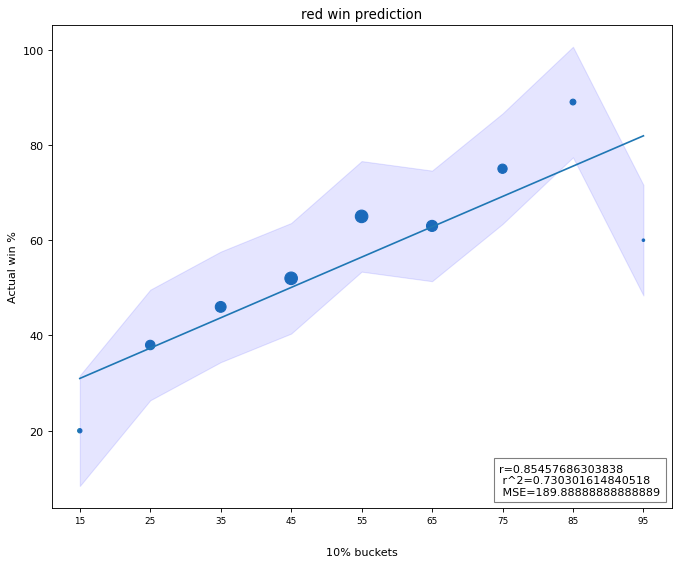

In [16]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
r_square = r_score*r_score

# plt.text(65, 40, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual win %")
plt.title("red win prediction")
plt.show()

In [17]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_dec_pct"] >= x]
    point_to_point = point_up[point_up["red_dec_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Decision"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 10%: 10% of 89 observations
10% to 20%: 23% of 191 observations
20% to 30%: 30% of 189 observations
30% to 40%: 28% of 102 observations
40% to 50%: 45% of 44 observations
50% to 60%: 42% of 26 observations
60% to 70%: 30% of 10 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


In [18]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[89, 191, 189, 102, 44, 26, 10]
[5, 15, 25, 35, 45, 55, 65]
[10, 23, 30, 28, 45, 42, 30]


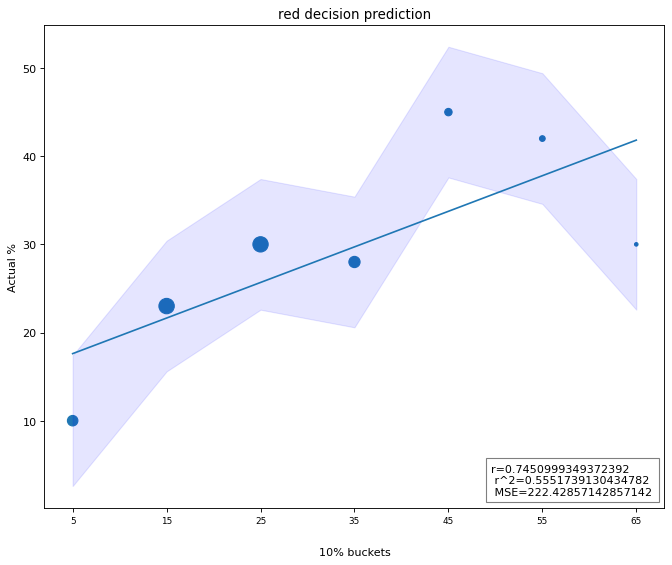

In [19]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
r_square = r_score*r_score
# plt.text(35, 20, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("red decision prediction")
plt.show()

In [20]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_ko_pct"] >= x]
    point_to_point = point_up[point_up["red_ko_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - KO/TKO"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 10%: 11% of 216 observations
10% to 20%: 18% of 224 observations
20% to 30%: 24% of 127 observations
30% to 40%: 11% of 45 observations
40% to 50%: 45% of 20 observations
50% to 60%: 36% of 14 observations
60% to 70%: 50% of 2 observations
70% to 80%: 100% of 1 observations
80% to 90%: 100% of 2 observations
90% to 100%: 0% of 0 observations


In [21]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]

print(observations)
print(half_points)
print(actual_win_pct)

[216, 224, 127, 45, 20, 14]
[5, 15, 25, 35, 45, 55]
[11, 18, 24, 11, 45, 36]


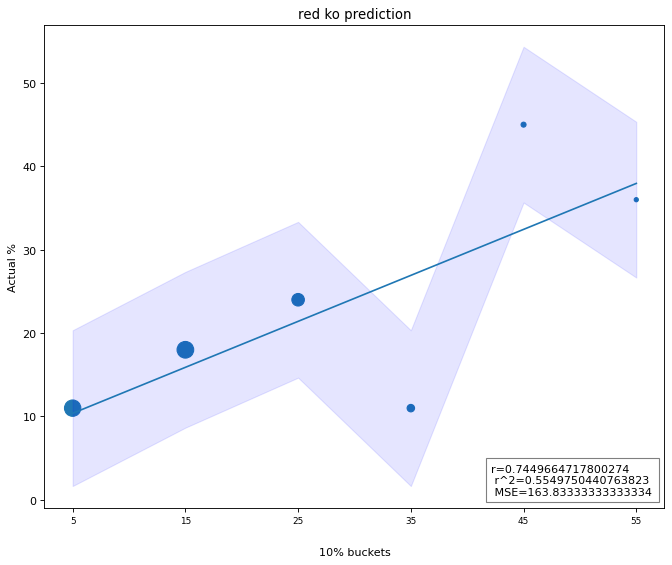

In [22]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
r_square = r_score*r_score
# plt.text(35, 10, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("red ko prediction")
plt.show()

In [23]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_sub_pct"] >= x]
    point_to_point = point_up[point_up["red_sub_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Submission"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
        
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 10%: 8% of 413 observations
10% to 20%: 14% of 161 observations
20% to 30%: 31% of 51 observations
30% to 40%: 20% of 15 observations
40% to 50%: 28% of 7 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 1 observations
70% to 80%: 33% of 3 observations
80% to 90%: 100% of 1 observations
90% to 100%: 0% of 0 observations


In [24]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i] 

print(observations)
print(half_points)
print(actual_win_pct)

[413, 161, 51, 15, 7]
[5, 15, 25, 35, 45]
[8, 14, 31, 20, 28]


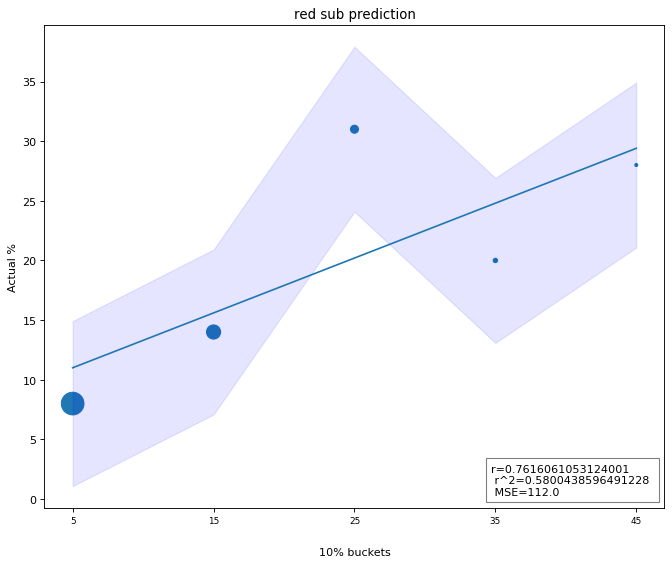

In [25]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
r_square = r_score*r_score
# plt.text(35, 10, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("red sub prediction")
plt.show()

In [26]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_total_pct"] >= x]
    point_to_point = point_up[point_up["blue_total_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "blue"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 10%: 25% of 4 observations
10% to 20%: 15% of 26 observations
20% to 30%: 23% of 80 observations
30% to 40%: 40% of 90 observations
40% to 50%: 34% of 128 observations
50% to 60%: 48% of 127 observations
60% to 70%: 55% of 99 observations
70% to 80%: 61% of 64 observations
80% to 90%: 83% of 18 observations
90% to 100%: 100% of 3 observations


In [27]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[26, 80, 90, 128, 127, 99, 64, 18]
[15, 25, 35, 45, 55, 65, 75, 85]
[15, 23, 40, 34, 48, 55, 61, 83]


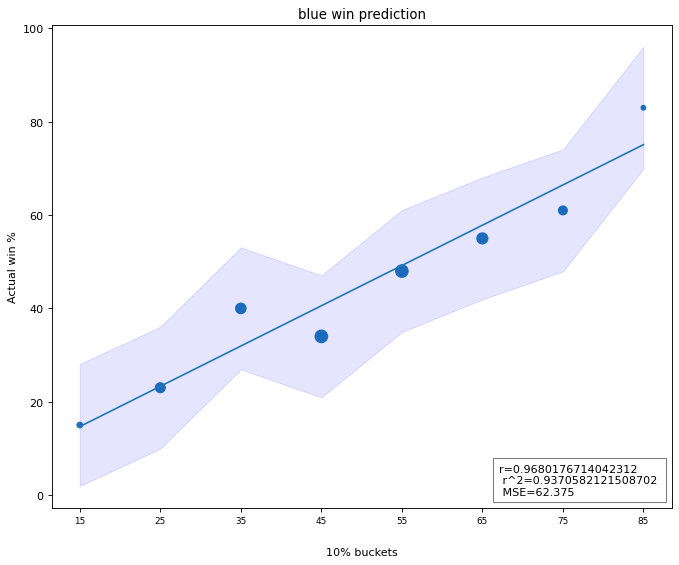

In [28]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
r_square = r_score*r_score
# plt.text(50, 30, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)

box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual win %")
plt.title("blue win prediction")
plt.show()

In [29]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_dec_pct"] >= x]
    point_to_point = point_up[point_up["blue_dec_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Decision"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 10%: 14% of 84 observations
10% to 20%: 15% of 218 observations
20% to 30%: 19% of 201 observations
30% to 40%: 23% of 86 observations
40% to 50%: 39% of 46 observations
50% to 60%: 50% of 12 observations
60% to 70%: 33% of 3 observations
70% to 80%: 100% of 1 observations
80% to 90%: 100% of 1 observations
90% to 100%: 0% of 0 observations


In [30]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[84, 218, 201, 86, 46, 12]
[5, 15, 25, 35, 45, 55]
[14, 15, 19, 23, 39, 50]


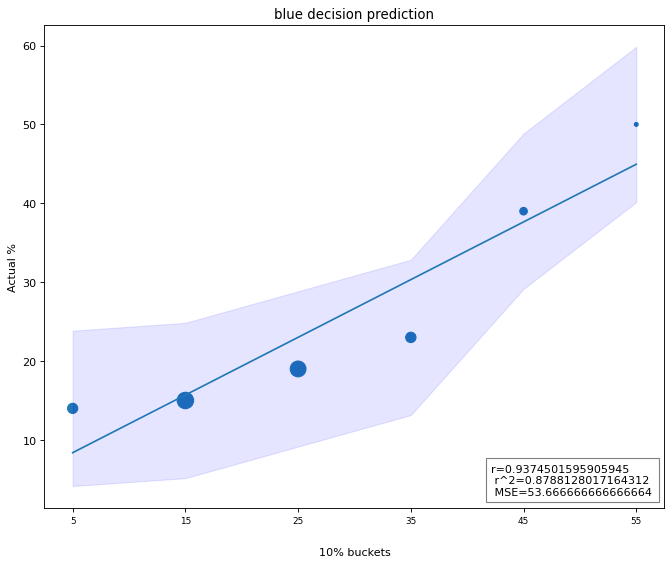

In [31]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
r_square = r_score*r_score
# plt.text(35, 15, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("blue decision prediction")
plt.show()

In [32]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_ko_pct"] >= x]
    point_to_point = point_up[point_up["blue_ko_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - KO/TKO"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 10%: 6% of 218 observations
10% to 20%: 11% of 210 observations
20% to 30%: 22% of 134 observations
30% to 40%: 22% of 45 observations
40% to 50%: 38% of 29 observations
50% to 60%: 45% of 11 observations
60% to 70%: 100% of 2 observations
70% to 80%: 0% of 1 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


In [33]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[218, 210, 134, 45, 29, 11]
[5, 15, 25, 35, 45, 55]
[6, 11, 22, 22, 38, 45]


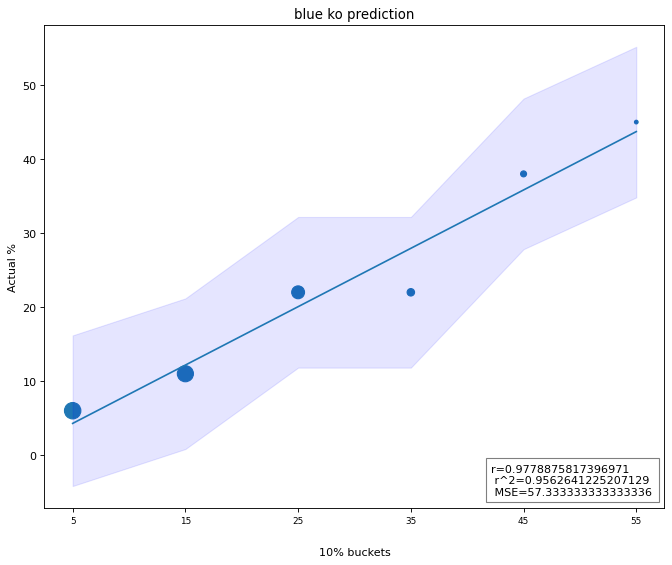

In [34]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
r_square = r_score*r_score
# plt.text(25, 10, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("blue ko prediction")
plt.show()

In [35]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_sub_pct"] >= x]
    point_to_point = point_up[point_up["blue_sub_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Submission"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 10%: 7% of 433 observations
10% to 20%: 9% of 147 observations
20% to 30%: 17% of 53 observations
30% to 40%: 23% of 13 observations
40% to 50%: 20% of 5 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 1 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


In [36]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[433, 147, 53, 13, 5]
[5, 15, 25, 35, 45]
[7, 9, 17, 23, 20]


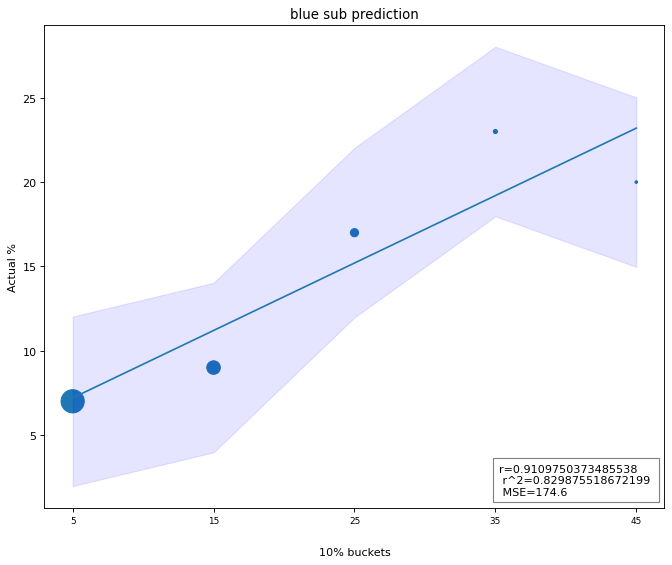

In [37]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
r_square = r_score*r_score
# plt.text(20, 5, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("blue sub prediction")
plt.show()

In [38]:
probas = model[["red_dec_pct", "red_ko_pct", "red_sub_pct", "blue_dec_pct", "blue_ko_pct", "blue_sub_pct"]]
probas

red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
104           0.35        0.15         0.02          0.21         0.22   
105           0.30        0.31         0.05          0.08         0.13   
106           0.35        0.18         0.02          0.27         0.15   
107           0.30        0.53         0.07          0.06         0.02   
108           0.26        0.21         0.12          0.23         0.07   
...            ...         ...          ...           ...          ...   
12491         0.29        0.15         0.03          0.29         0.22   
12492         0.41        0.06         0.14          0.25         0.13   
12493         0.27        0.11         0.26          0.19         0.06   
12494         0.30        0.19         0.06          0.23         0.13   
12495         0.46        0.08         0.08          0.28         0.05   

       blue_sub_pct  
104            0.05  
105            0.13  
106            0.03  
107            0.02  
108            0.11  
...             ...  
12491          0.02  
12492          0.02  
12493          0.11  
12494          0.08  
12495          0.05  

[652 rows x 6 columns]

In [39]:
# probas = model[["red_total_pct", "blue_total_pct"]]
# probas

In [40]:
predicted_prob =  probas.values
predicted_prob

array([[0.35, 0.15, 0.02, 0.21, 0.22, 0.05],
       [0.3 , 0.31, 0.05, 0.08, 0.13, 0.13],
       [0.35, 0.18, 0.02, 0.27, 0.15, 0.03],
       ...,
       [0.27, 0.11, 0.26, 0.19, 0.06, 0.11],
       [0.3 , 0.19, 0.06, 0.23, 0.13, 0.08],
       [0.46, 0.08, 0.08, 0.28, 0.05, 0.05]])

In [41]:
# prediction_labels = combined["win_pred"]

In [42]:
prediction_labels = model["win_method"]

In [43]:
# actual_result = combined["actual_winner"]

In [44]:
actual_result = model["actual_method"]

In [45]:
classes = np.unique(actual_result)
y_array = pd.get_dummies(actual_result, drop_first=False).values
y_array

array([[0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=uint8)

In [46]:
accuracy = metrics.accuracy_score(actual_result, prediction_labels)
auc = metrics.roc_auc_score(y_array, predicted_prob, 
                            multi_class="one_vs_rest")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(actual_result, prediction_labels))

Accuracy: 0.32
Auc: 0.47
Detail:
                   precision    recall  f1-score   support

  blue - Decision       0.29      0.39      0.33       130
    blue - KO/TKO       0.33      0.39      0.36        93
blue - Submission       0.18      0.09      0.12        56
   red - Decision       0.36      0.42      0.39       174
     red - KO/TKO       0.33      0.28      0.31       120
 red - Submission       0.30      0.13      0.18        79

         accuracy                           0.32       652
        macro avg       0.30      0.28      0.28       652
     weighted avg       0.31      0.32      0.31       652



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'blue - Decision'),
  Text(0, 1.5, 'blue - KO/TKO'),
  Text(0, 2.5, 'blue - Submission'),
  Text(0, 3.5, 'red - Decision'),
  Text(0, 4.5, 'red - KO/TKO'),
  Text(0, 5.5, 'red - Submission')])

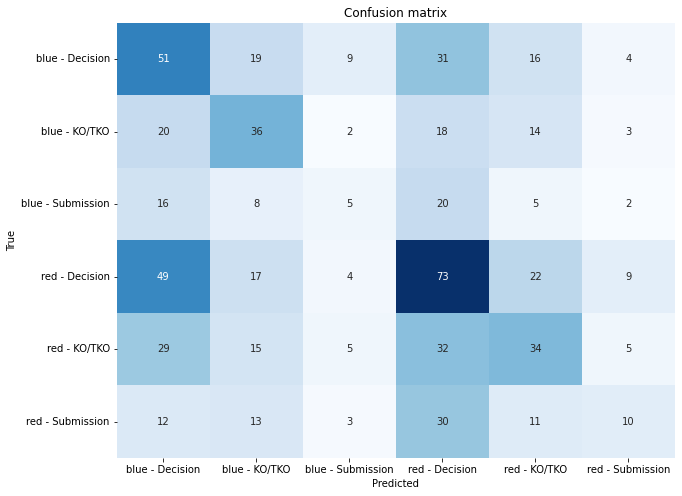

In [47]:
cm = metrics.confusion_matrix(actual_result, prediction_labels)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

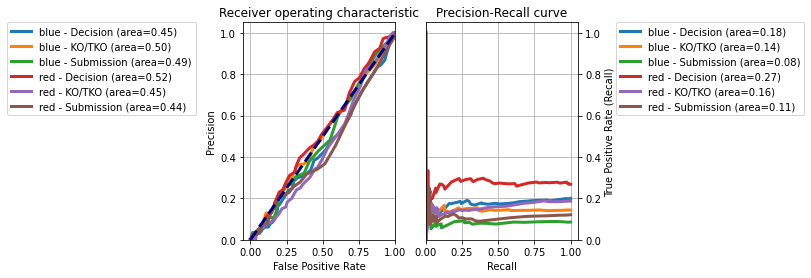

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="Precision", 
          title="Receiver operating characteristic")
ax[0].legend(bbox_to_anchor=(-1.55, 1), loc=2, borderaxespad=0.)
ax[0].grid(True)

for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="True Positive Rate (Recall)", title="Precision-Recall curve")
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)
ax[1].grid(True)
plt.show()

In [49]:
matthews_corrcoef(actual_result, prediction_labels)

0.15234783309846475

In [50]:
probas = model[["red_total_pct", "blue_total_pct"]]
probas

red_total_pct  blue_total_pct
104             0.52            0.48
105             0.66            0.34
106             0.55            0.45
107             0.90            0.10
108             0.60            0.40
...              ...             ...
12491           0.47            0.53
12492           0.60            0.40
12493           0.65            0.35
12494           0.56            0.44
12495           0.62            0.38

[652 rows x 2 columns]

In [51]:
predicted_prob =  probas.values
predicted_prob

array([[0.52, 0.48],
       [0.66, 0.34],
       [0.55, 0.45],
       ...,
       [0.65, 0.35],
       [0.56, 0.44],
       [0.62, 0.38]])

In [52]:
prediction_labels = model["win_pred"]

In [53]:
actual_result = model["actual_winner"]

In [54]:
classes = np.unique(actual_result)
y_array = pd.get_dummies(actual_result, drop_first=False).values
y_array

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [55]:
accuracy = metrics.accuracy_score(actual_result, prediction_labels)
auc = metrics.roc_auc_score(y_array, predicted_prob, 
                            multi_class="one_vs_one")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(actual_result, prediction_labels))

Accuracy: 0.62
Auc: 0.34
Detail:
              precision    recall  f1-score   support

        blue       0.55      0.62      0.59       279
         red       0.69      0.62      0.65       373

    accuracy                           0.62       652
   macro avg       0.62      0.62      0.62       652
weighted avg       0.63      0.62      0.62       652



(array([0.5, 1.5]), [Text(0, 0.5, 'blue'), Text(0, 1.5, 'red')])

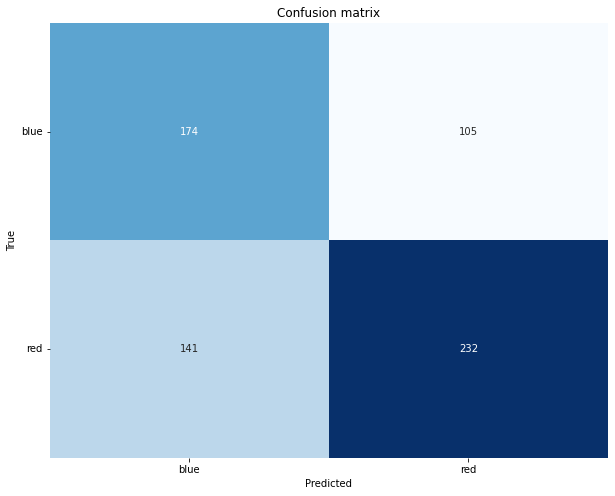

In [56]:
cm = metrics.confusion_matrix(actual_result, prediction_labels)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

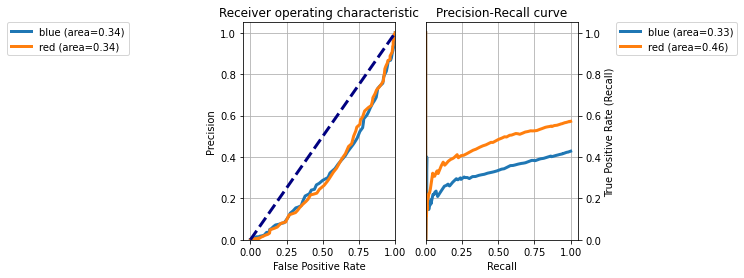

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="Precision", 
          title="Receiver operating characteristic")
ax[0].legend(bbox_to_anchor=(-1.55, 1), loc=2, borderaxespad=0.)
ax[0].grid(True)

for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="True Positive Rate (Recall)", title="Precision-Recall curve")
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)
ax[1].grid(True)
plt.show()

In [58]:
matthews_corrcoef(actual_result, prediction_labels)

0.24321204260506013

In [59]:
exact_pcts = list(np.random.randint(low=0, high=100, size=total_fights.astype(int))/100)
# exact_pcts

In [60]:
exact_true = []
for n in exact_pcts:
#     print(n)
    test = list(np.random.randint(low=0,high=100, size=1) /100)
#     print(test[0])
    if test[0] <= n:
#         print("true")
        exact_true.append(1)
    else:
#         print("false")
        exact_true.append(0)

In [61]:
sum(exact_true) 

328

In [62]:
exact_dict = {"exact_pct" : exact_pcts,
             "true" : exact_true}
exact_df = pd.DataFrame(exact_dict)
exact_df

exact_pct  true
0         0.59     1
1         0.21     0
2         0.85     1
3         0.78     1
4         0.04     0
..         ...   ...
647       0.84     1
648       0.25     0
649       0.56     1
650       0.29     0
651       0.42     1

[652 rows x 2 columns]

In [63]:
# different bucket ranges 
bucket = 0.1
# divider for getting midpoint of buckets. 1 if bucket size is 0.01 and 2 for any other bucket size
divider = 2
# minimum observations thresholds
min_obs = 5

In [64]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = exact_df[exact_df["exact_pct"] >= x]
    point_to_point = point_up[point_up["exact_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["true"] == 1]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
        
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 10%: 6% of 69 observations
10% to 20%: 12% of 59 observations
20% to 30%: 22% of 72 observations
30% to 40%: 37% of 52 observations
40% to 50%: 56% of 59 observations
50% to 60%: 54% of 90 observations
60% to 70%: 60% of 63 observations
70% to 80%: 84% of 58 observations
80% to 90%: 88% of 64 observations
90% to 100%: 93% of 59 observations


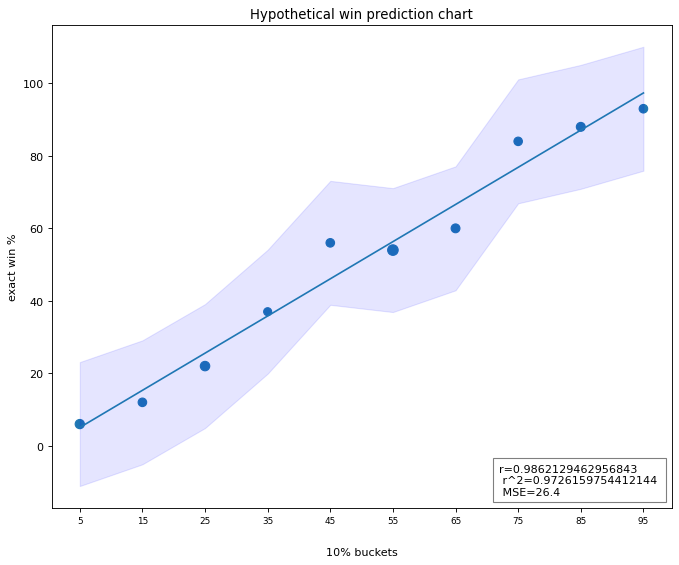

In [65]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)


mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
r_square = r_score*r_score
# plt.text(65, 20, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("exact win %")
plt.title("Hypothetical win prediction chart")
plt.show()

In [66]:
models = list(model_results_df["model_v"].unique())
models

['knn_no',
 'knn_rand',
 'knn_up',
 'log_no',
 'log_rand',
 'log_up',
 'rf_no',
 'rf_rand',
 'rf_up',
 'mlp_no',
 'mlp_rand',
 'mlp_up',
 'nn_no',
 'nn_rand',
 'nn_up',
 'mix_no',
 'mix_rand',
 'mix_up',
 'combined']

In [67]:
# creating a list of permutations of different combinations of models with r being the number of models combined
raw_perms = list(itertools.permutations(models, r=1))
raw_perm_list = list(raw_perms)
# print(raw_perm_list)
clean_perm_list = []
for i in raw_perm_list:
    i_list = list(i)
    
    in_list = False
    if clean_perm_list:
        for x in clean_perm_list:
#             print(x)
            if set(x) == set(i_list):
                in_list = True
#     print(in_list)
    if in_list == False:
        clean_perm_list.append(i_list)
        
#     print(i_list)
# raw_perms

In [68]:
clean_perm_list

[['knn_no'],
 ['knn_rand'],
 ['knn_up'],
 ['log_no'],
 ['log_rand'],
 ['log_up'],
 ['rf_no'],
 ['rf_rand'],
 ['rf_up'],
 ['mlp_no'],
 ['mlp_rand'],
 ['mlp_up'],
 ['nn_no'],
 ['nn_rand'],
 ['nn_up'],
 ['mix_no'],
 ['mix_rand'],
 ['mix_up'],
 ['combined']]

knn_no
0% to 10%: 0% of 0 observations
10% to 20%: 0% of 0 observations
20% to 30%: 20% of 5 observations
30% to 40%: 51% of 39 observations
40% to 50%: 51% of 89 observations
50% to 60%: 54% of 169 observations
60% to 70%: 63% of 198 observations
70% to 80%: 57% of 96 observations
80% to 90%: 65% of 43 observations
90% to 100%: 71% of 7 observations


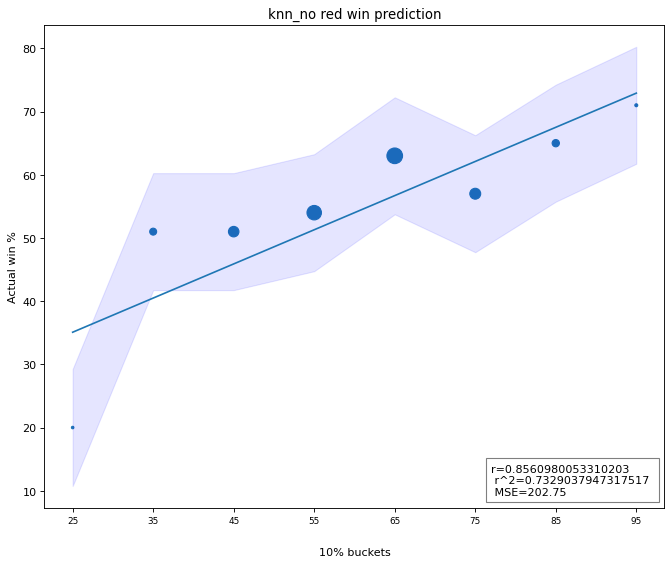

knn_rand
0% to 10%: 0% of 0 observations
10% to 20%: 33% of 6 observations
20% to 30%: 44% of 32 observations
30% to 40%: 51% of 124 observations
40% to 50%: 57% of 179 observations
50% to 60%: 62% of 153 observations
60% to 70%: 61% of 108 observations
70% to 80%: 59% of 46 observations
80% to 90%: 50% of 4 observations
90% to 100%: 0% of 0 observations


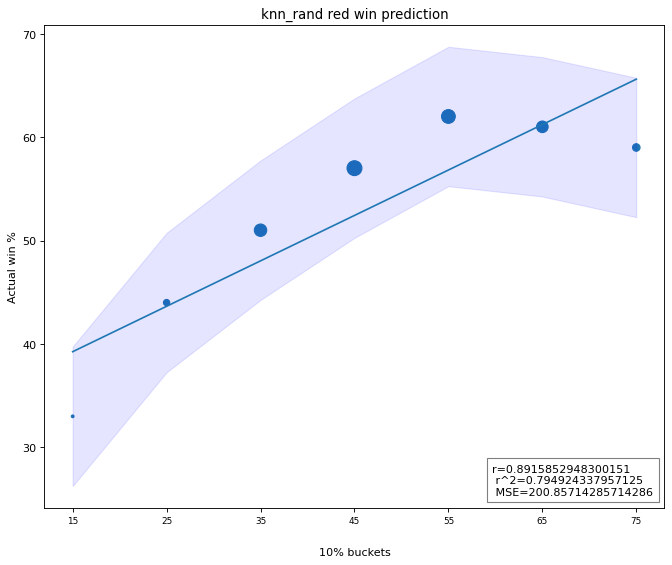

knn_up
0% to 10%: 0% of 2 observations
10% to 20%: 54% of 26 observations
20% to 30%: 45% of 76 observations
30% to 40%: 50% of 130 observations
40% to 50%: 56% of 161 observations
50% to 60%: 67% of 131 observations
60% to 70%: 67% of 72 observations
70% to 80%: 60% of 40 observations
80% to 90%: 75% of 8 observations
90% to 100%: 100% of 1 observations


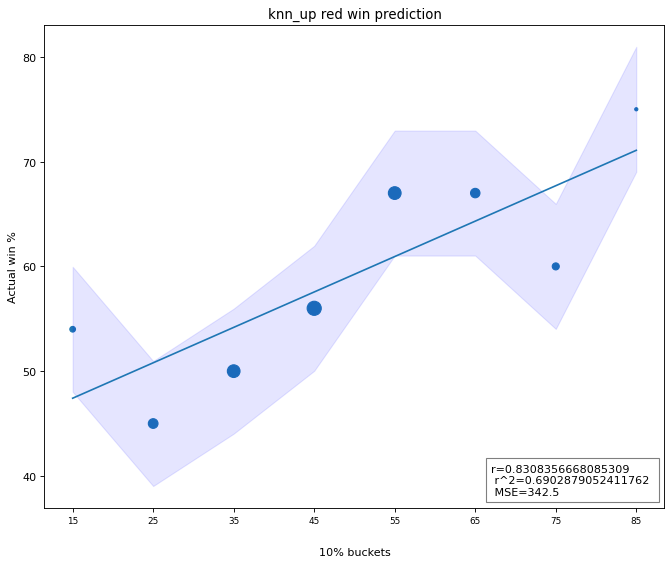

log_no
0% to 10%: 0% of 0 observations
10% to 20%: 50% of 4 observations
20% to 30%: 25% of 12 observations
30% to 40%: 56% of 32 observations
40% to 50%: 48% of 65 observations
50% to 60%: 46% of 127 observations
60% to 70%: 54% of 145 observations
70% to 80%: 64% of 131 observations
80% to 90%: 71% of 96 observations
90% to 100%: 83% of 24 observations


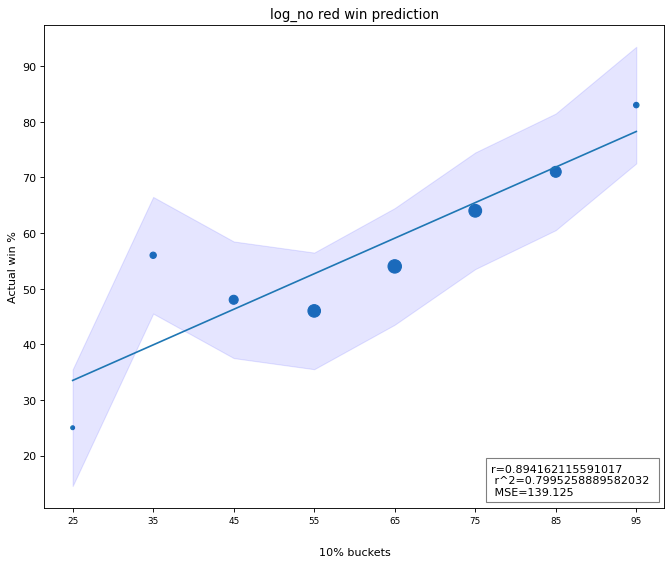

log_rand
0% to 10%: 0% of 2 observations
10% to 20%: 40% of 10 observations
20% to 30%: 36% of 53 observations
30% to 40%: 39% of 107 observations
40% to 50%: 54% of 151 observations
50% to 60%: 67% of 138 observations
60% to 70%: 68% of 104 observations
70% to 80%: 76% of 49 observations
80% to 90%: 80% of 20 observations
90% to 100%: 67% of 3 observations


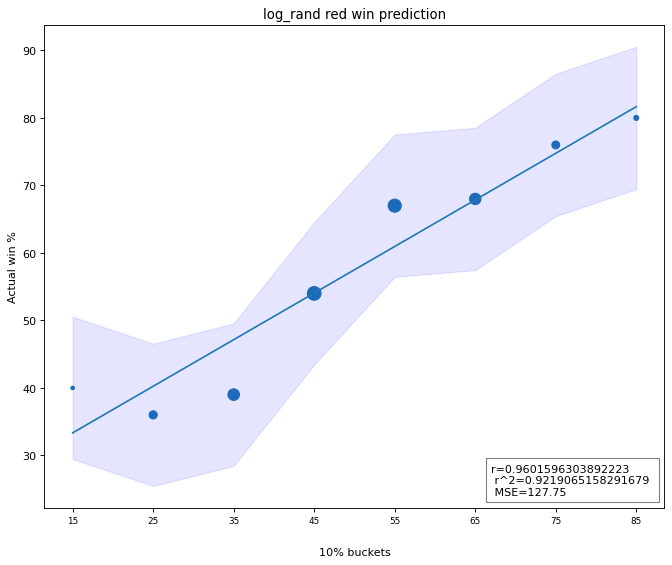

log_up
0% to 10%: 33% of 3 observations
10% to 20%: 48% of 27 observations
20% to 30%: 48% of 66 observations
30% to 40%: 47% of 107 observations
40% to 50%: 52% of 128 observations
50% to 60%: 61% of 122 observations
60% to 70%: 54% of 92 observations
70% to 80%: 84% of 56 observations
80% to 90%: 74% of 27 observations
90% to 100%: 88% of 8 observations


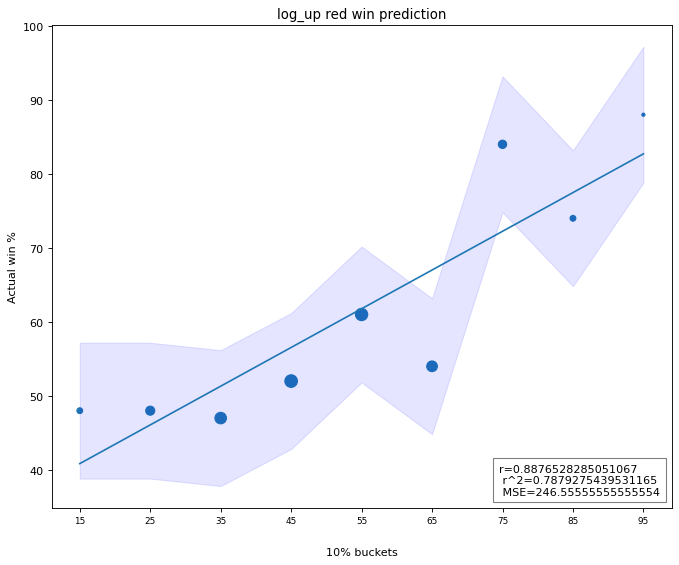

rf_no
0% to 10%: 0% of 0 observations
10% to 20%: 0% of 0 observations
20% to 30%: 0% of 0 observations
30% to 40%: 0% of 0 observations
40% to 50%: 55% of 11 observations
50% to 60%: 59% of 192 observations
60% to 70%: 60% of 354 observations
70% to 80%: 48% of 54 observations
80% to 90%: 33% of 3 observations
90% to 100%: 0% of 0 observations


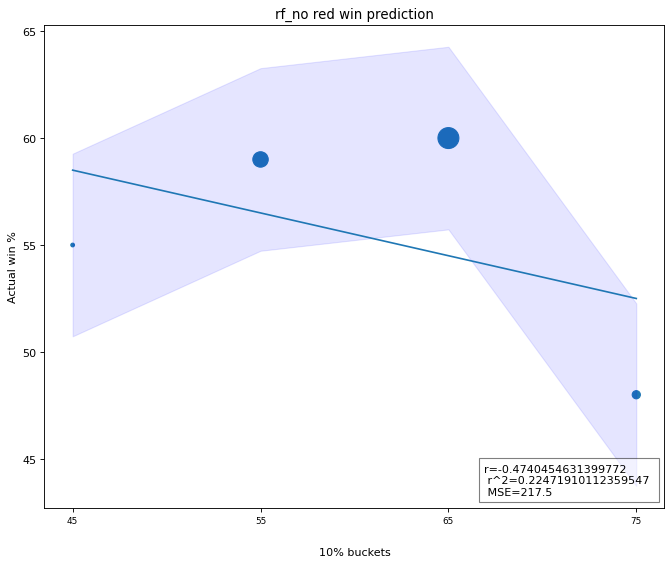

rf_rand
0% to 10%: 0% of 0 observations
10% to 20%: 0% of 0 observations
20% to 30%: 100% of 1 observations
30% to 40%: 47% of 47 observations
40% to 50%: 61% of 234 observations
50% to 60%: 55% of 296 observations
60% to 70%: 68% of 47 observations
70% to 80%: 0% of 1 observations
80% to 90%: 0% of 1 observations
90% to 100%: 0% of 0 observations


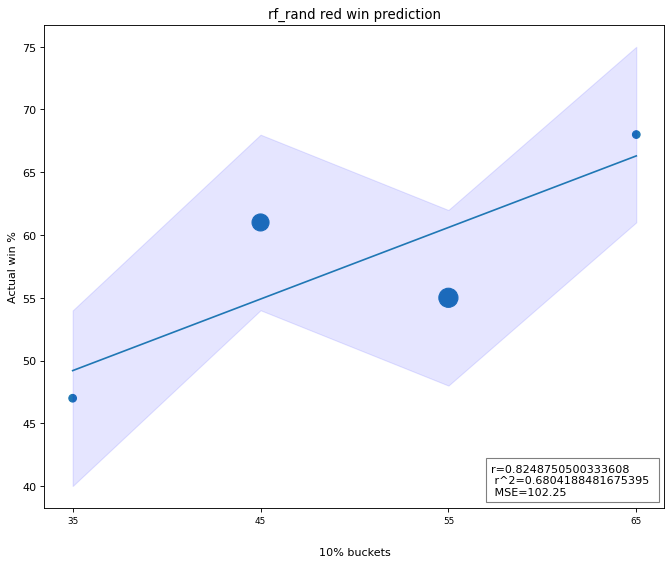

rf_up
0% to 10%: 0% of 0 observations
10% to 20%: 0% of 0 observations
20% to 30%: 0% of 0 observations
30% to 40%: 0% of 0 observations
40% to 50%: 50% of 38 observations
50% to 60%: 59% of 328 observations
60% to 70%: 56% of 227 observations
70% to 80%: 31% of 16 observations
80% to 90%: 100% of 1 observations
90% to 100%: 0% of 0 observations


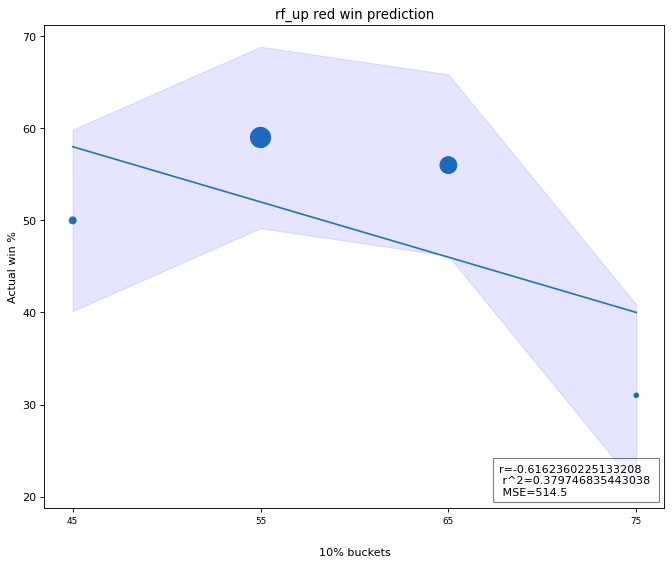

mlp_no
0% to 10%: 50% of 4 observations
10% to 20%: 24% of 21 observations
20% to 30%: 48% of 46 observations
30% to 40%: 43% of 37 observations
40% to 50%: 54% of 59 observations
50% to 60%: 61% of 79 observations
60% to 70%: 50% of 109 observations
70% to 80%: 56% of 88 observations
80% to 90%: 69% of 115 observations
90% to 100%: 70% of 87 observations


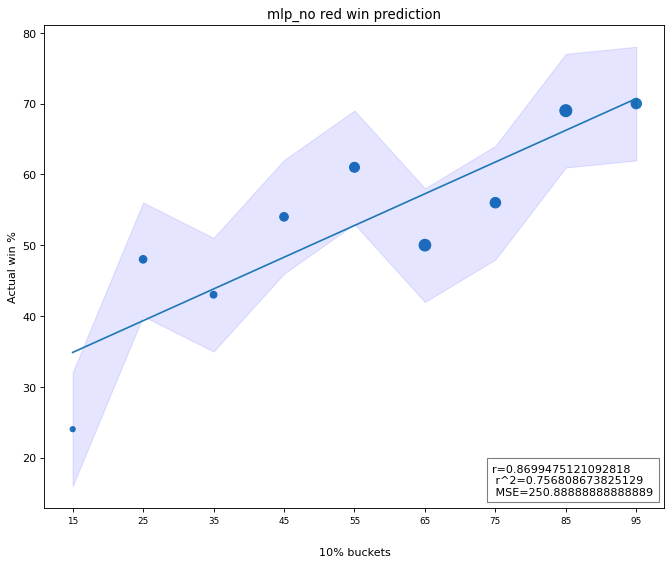

mlp_rand
0% to 10%: 20% of 20 observations
10% to 20%: 47% of 59 observations
20% to 30%: 49% of 86 observations
30% to 40%: 50% of 80 observations
40% to 50%: 55% of 83 observations
50% to 60%: 61% of 82 observations
60% to 70%: 56% of 77 observations
70% to 80%: 63% of 59 observations
80% to 90%: 72% of 57 observations
90% to 100%: 84% of 44 observations


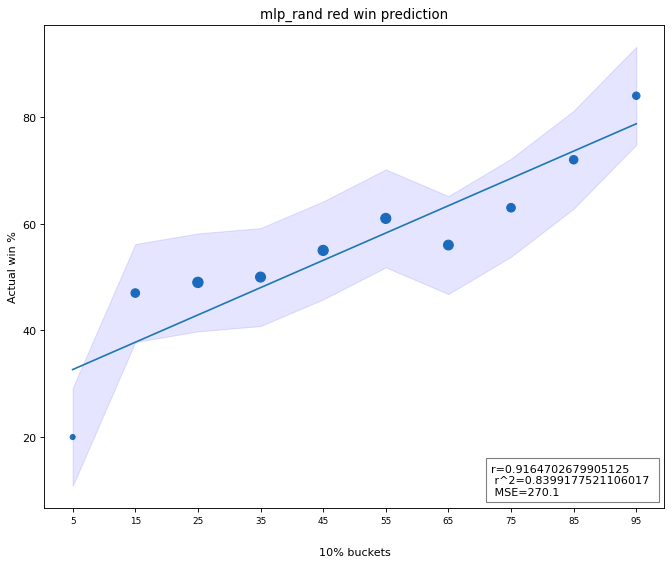

mlp_up
0% to 10%: 51% of 43 observations
10% to 20%: 48% of 46 observations
20% to 30%: 52% of 50 observations
30% to 40%: 42% of 43 observations
40% to 50%: 67% of 54 observations
50% to 60%: 50% of 72 observations
60% to 70%: 44% of 64 observations
70% to 80%: 66% of 68 observations
80% to 90%: 61% of 88 observations
90% to 100%: 68% of 109 observations


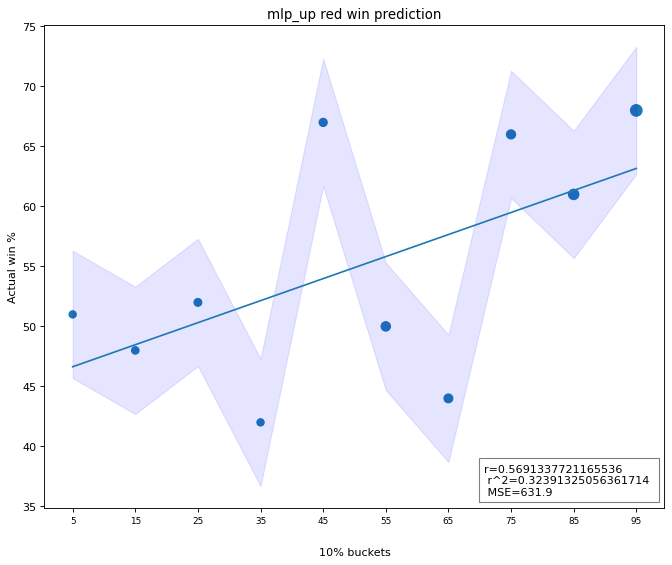

nn_no
0% to 10%: 0% of 0 observations
10% to 20%: 56% of 7 observations
20% to 30%: 20% of 10 observations
30% to 40%: 33% of 46 observations
40% to 50%: 53% of 64 observations
50% to 60%: 50% of 106 observations
60% to 70%: 56% of 134 observations
70% to 80%: 62% of 121 observations
80% to 90%: 69% of 99 observations
90% to 100%: 83% of 46 observations


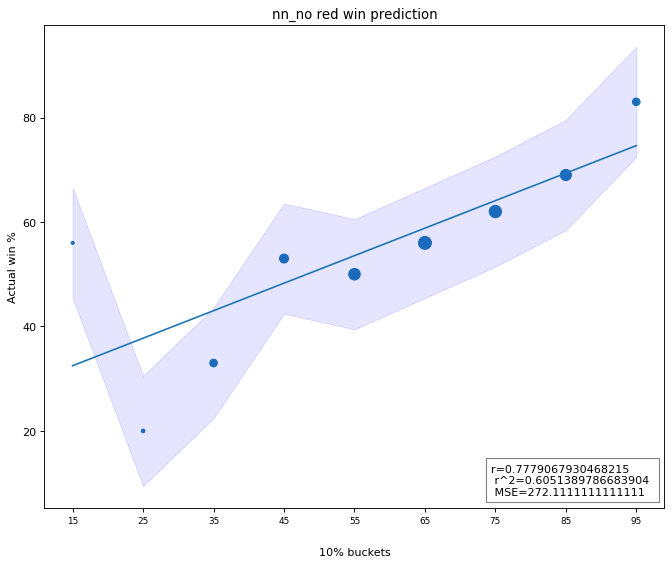

nn_rand
0% to 10%: 0% of 3 observations
10% to 20%: 20% of 15 observations
20% to 30%: 38% of 72 observations
30% to 40%: 46% of 94 observations
40% to 50%: 52% of 127 observations
50% to 60%: 65% of 127 observations
60% to 70%: 63% of 99 observations
70% to 80%: 75% of 69 observations
80% to 90%: 89% of 27 observations
90% to 100%: 60% of 5 observations


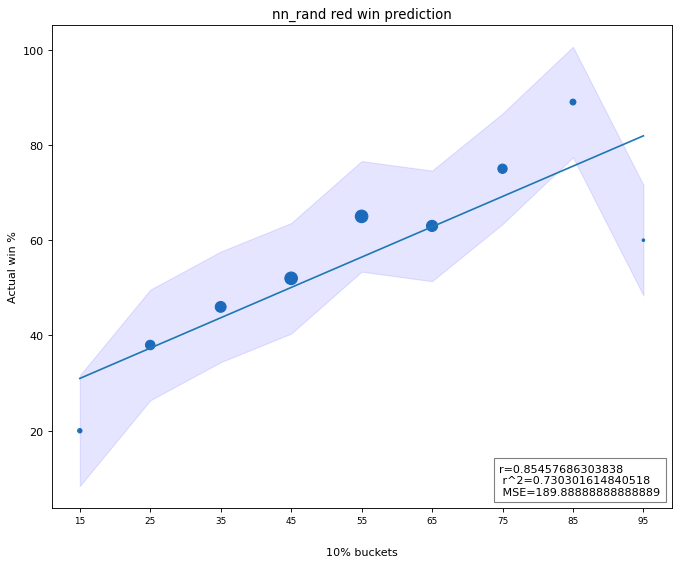

nn_up
0% to 10%: 12% of 8 observations
10% to 20%: 56% of 27 observations
20% to 30%: 43% of 72 observations
30% to 40%: 54% of 82 observations
40% to 50%: 55% of 87 observations
50% to 60%: 61% of 76 observations
60% to 70%: 51% of 103 observations
70% to 80%: 64% of 66 observations
80% to 90%: 73% of 74 observations
90% to 100%: 72% of 43 observations


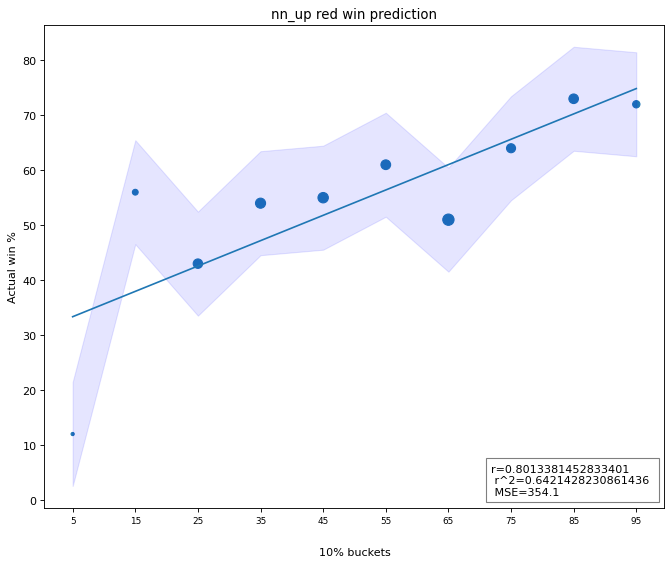

mix_no
0% to 10%: 0% of 0 observations
10% to 20%: 0% of 0 observations
20% to 30%: 0% of 1 observations
30% to 40%: 43% of 14 observations
40% to 50%: 48% of 73 observations
50% to 60%: 49% of 148 observations
60% to 70%: 55% of 205 observations
70% to 80%: 69% of 137 observations
80% to 90%: 83% of 47 observations
90% to 100%: 75% of 4 observations


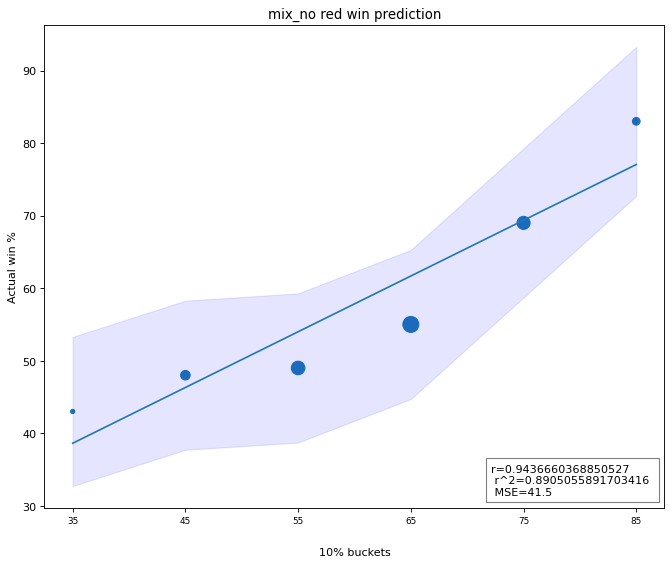

mix_rand
0% to 10%: 0% of 0 observations
10% to 20%: 0% of 2 observations
20% to 30%: 39% of 31 observations
30% to 40%: 37% of 106 observations
40% to 50%: 55% of 197 observations
50% to 60%: 64% of 167 observations
60% to 70%: 71% of 97 observations
70% to 80%: 69% of 32 observations
80% to 90%: 83% of 6 observations
90% to 100%: 0% of 0 observations


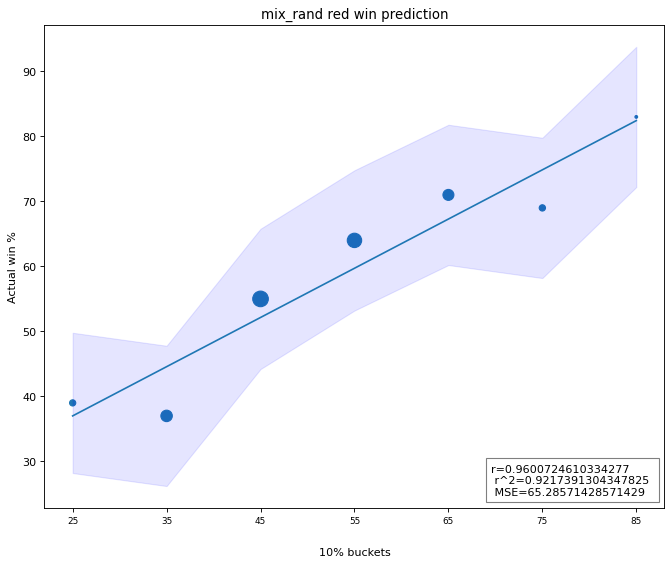

mix_up
0% to 10%: 0% of 0 observations
10% to 20%: 0% of 0 observations
20% to 30%: 0% of 1 observations
30% to 40%: 40% of 35 observations
40% to 50%: 48% of 145 observations
50% to 60%: 54% of 216 observations
60% to 70%: 62% of 149 observations
70% to 80%: 80% of 71 observations
80% to 90%: 67% of 12 observations
90% to 100%: 0% of 0 observations


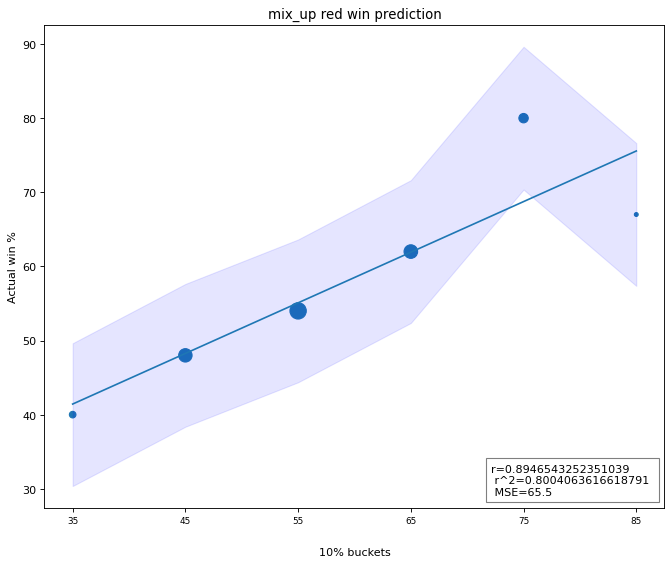

combined
0% to 10%: 0% of 0 observations
10% to 20%: 0% of 0 observations
20% to 30%: 20% of 5 observations
30% to 40%: 35% of 34 observations
40% to 50%: 43% of 162 observations
50% to 60%: 56% of 191 observations
60% to 70%: 68% of 171 observations
70% to 80%: 82% of 49 observations
80% to 90%: 67% of 9 observations
90% to 100%: 0% of 0 observations


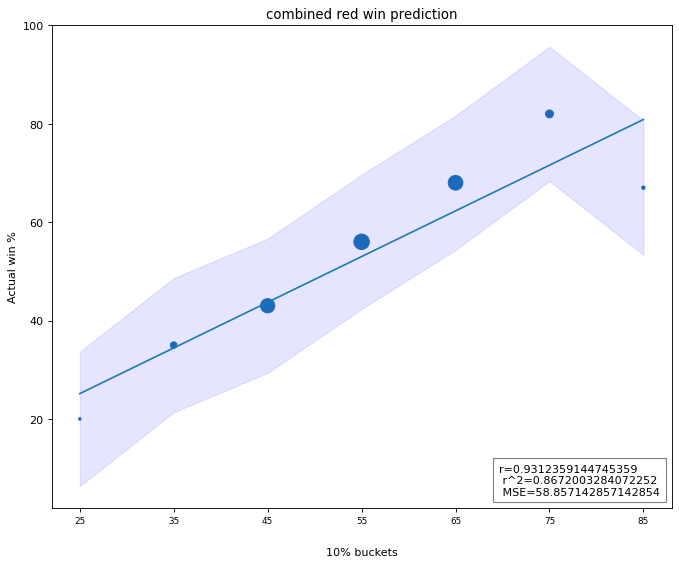

In [69]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
#     print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n]        
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["red_total_pct"] >= x]
        point_to_point = point_up[point_up["red_total_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "red"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)

    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual win %")
    plt.title(f"{perm_str} red win prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)
    
    

    
    
        


In [70]:
print(model_combo)

['knn_no', 'knn_rand', 'knn_up', 'log_no', 'log_rand', 'log_up', 'rf_no', 'rf_rand', 'rf_up', 'mlp_no', 'mlp_rand', 'mlp_up', 'nn_no', 'nn_rand', 'nn_up', 'mix_no', 'mix_rand', 'mix_up', 'combined']


In [71]:
# print(len(clean_perm_list))
# print(len(model_combo))
# print(len(r))
# print(len(r_squared))
# print(len(m_squared))
red_win_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_win_df = pd.DataFrame(red_win_dict)
red_win_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.856098   0.732904    202.750000
1     knn_rand  0.891585   0.794924    200.857143
2       knn_up  0.830836   0.690288    342.500000
3       log_no  0.894162   0.799526    139.125000
4     log_rand  0.960160   0.921907    127.750000
5       log_up  0.887653   0.787928    246.555556
6        rf_no -0.474045   0.224719    217.500000
7      rf_rand  0.824875   0.680419    102.250000
8        rf_up -0.616236   0.379747    514.500000
9       mlp_no  0.869948   0.756809    250.888889
10    mlp_rand  0.916470   0.839918    270.100000
11      mlp_up  0.569134   0.323913    631.900000
12       nn_no  0.777907   0.605139    272.111111
13     nn_rand  0.854577   0.730302    189.888889
14       nn_up  0.801338   0.642143    354.100000
15      mix_no  0.943666   0.890506     41.500000
16    mix_rand  0.960072   0.921739     65.285714
17      mix_up  0.894654   0.800406     65.500000
18    combined  0.931236   0.867200     58.857143

knn_no
0% to 10%: 50% of 6 observations
10% to 20%: 33% of 48 observations
20% to 30%: 42% of 96 observations
30% to 40%: 37% of 198 observations
40% to 50%: 46% of 171 observations
50% to 60%: 49% of 89 observations
60% to 70%: 49% of 39 observations
70% to 80%: 80% of 5 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


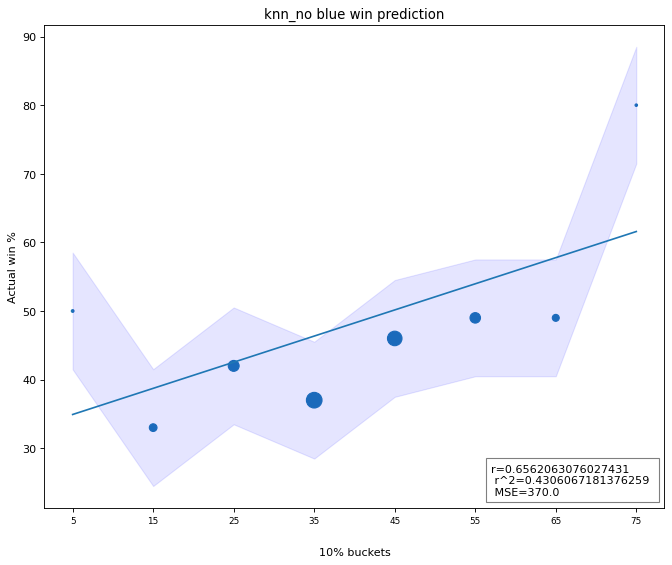

knn_rand
0% to 10%: 0% of 0 observations
10% to 20%: 50% of 4 observations
20% to 30%: 41% of 46 observations
30% to 40%: 39% of 108 observations
40% to 50%: 38% of 153 observations
50% to 60%: 42% of 179 observations
60% to 70%: 49% of 124 observations
70% to 80%: 56% of 32 observations
80% to 90%: 60% of 5 observations
90% to 100%: 100% of 1 observations


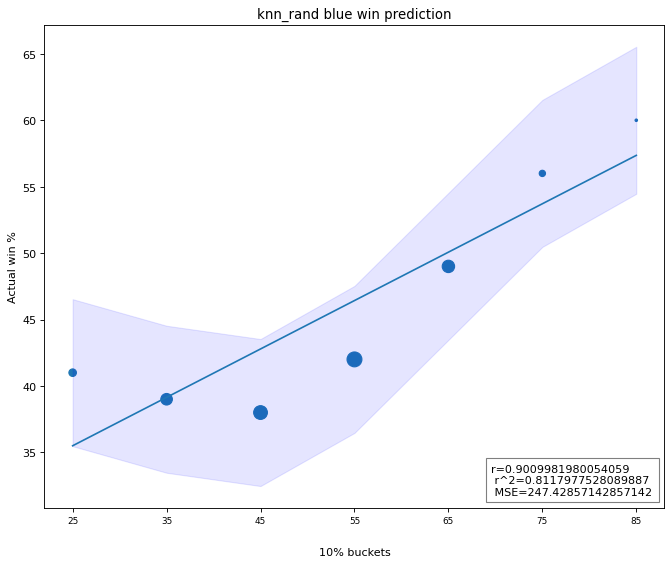

knn_up
0% to 10%: 50% of 6 observations
10% to 20%: 25% of 8 observations
20% to 30%: 40% of 40 observations
30% to 40%: 33% of 72 observations
40% to 50%: 33% of 131 observations
50% to 60%: 43% of 161 observations
60% to 70%: 50% of 130 observations
70% to 80%: 55% of 76 observations
80% to 90%: 46% of 26 observations
90% to 100%: 100% of 2 observations


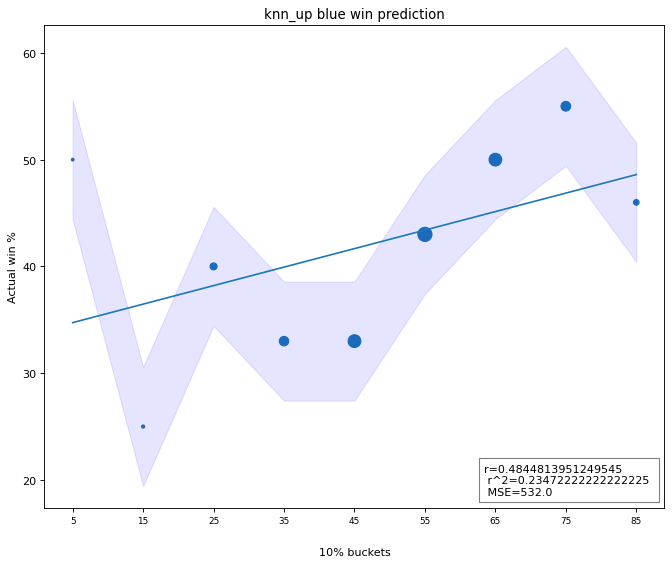

log_no
0% to 10%: 19% of 21 observations
10% to 20%: 26% of 88 observations
20% to 30%: 39% of 167 observations
30% to 40%: 44% of 120 observations
40% to 50%: 53% of 133 observations
50% to 60%: 51% of 68 observations
60% to 70%: 44% of 34 observations
70% to 80%: 80% of 10 observations
80% to 90%: 33% of 3 observations
90% to 100%: 100% of 1 observations


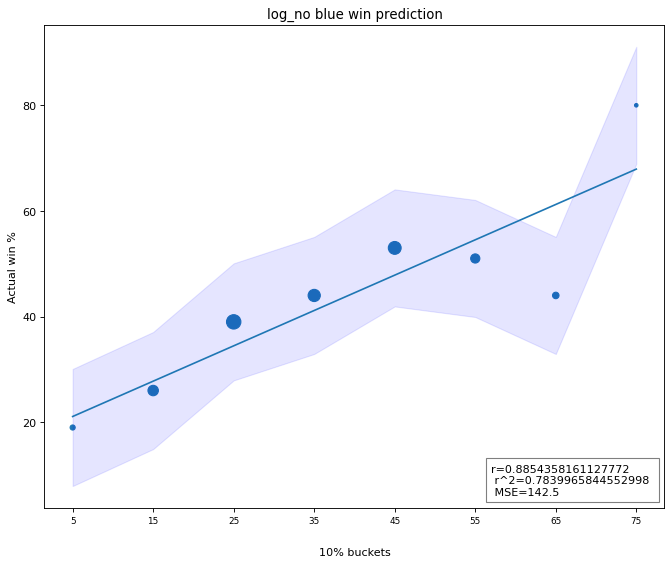

log_rand
0% to 10%: 0% of 2 observations
10% to 20%: 24% of 17 observations
20% to 30%: 25% of 60 observations
30% to 40%: 32% of 97 observations
40% to 50%: 34% of 134 observations
50% to 60%: 43% of 157 observations
60% to 70%: 62% of 113 observations
70% to 80%: 61% of 46 observations
80% to 90%: 64% of 11 observations
90% to 100%: 100% of 2 observations


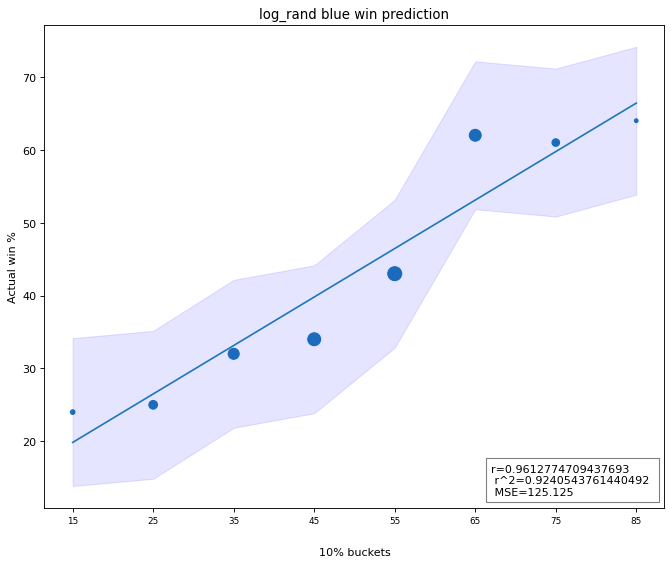

log_up
0% to 10%: 14% of 7 observations
10% to 20%: 24% of 25 observations
20% to 30%: 22% of 68 observations
30% to 40%: 45% of 83 observations
40% to 50%: 37% of 127 observations
50% to 60%: 49% of 126 observations
60% to 70%: 52% of 112 observations
70% to 80%: 53% of 57 observations
80% to 90%: 56% of 30 observations
90% to 100%: 50% of 4 observations


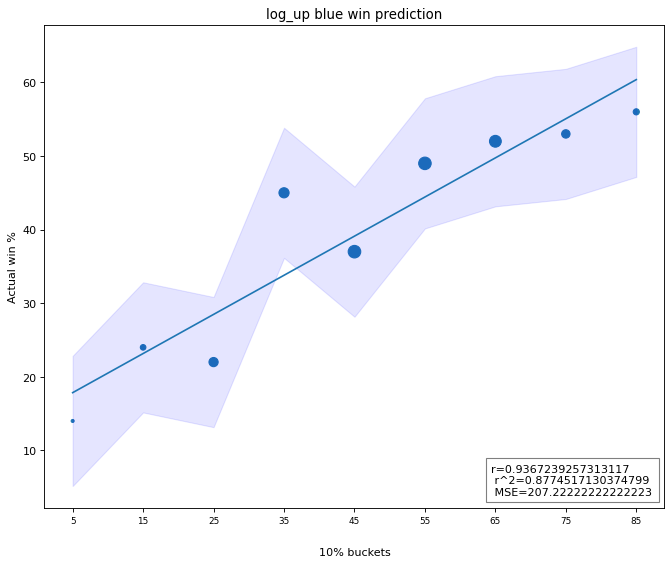

rf_no
0% to 10%: 0% of 0 observations
10% to 20%: 50% of 2 observations
20% to 30%: 47% of 73 observations
30% to 40%: 41% of 336 observations
40% to 50%: 44% of 223 observations
50% to 60%: 50% of 18 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


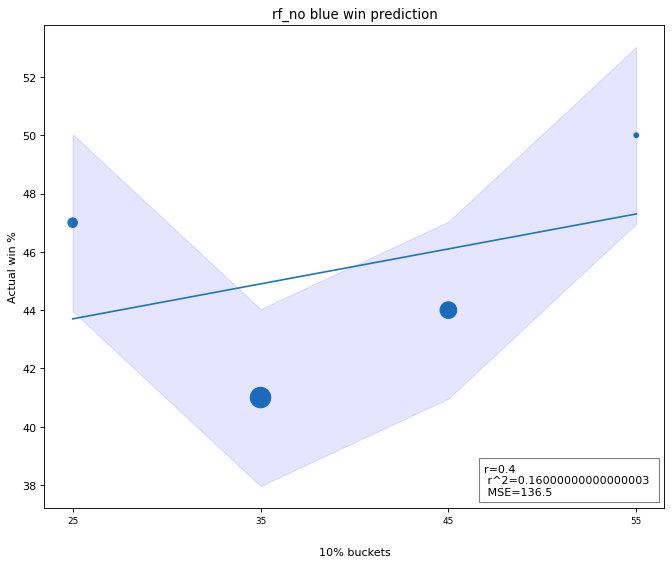

rf_rand
0% to 10%: 0% of 0 observations
10% to 20%: 0% of 0 observations
20% to 30%: 100% of 3 observations
30% to 40%: 30% of 46 observations
40% to 50%: 46% of 283 observations
50% to 60%: 40% of 260 observations
60% to 70%: 52% of 48 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


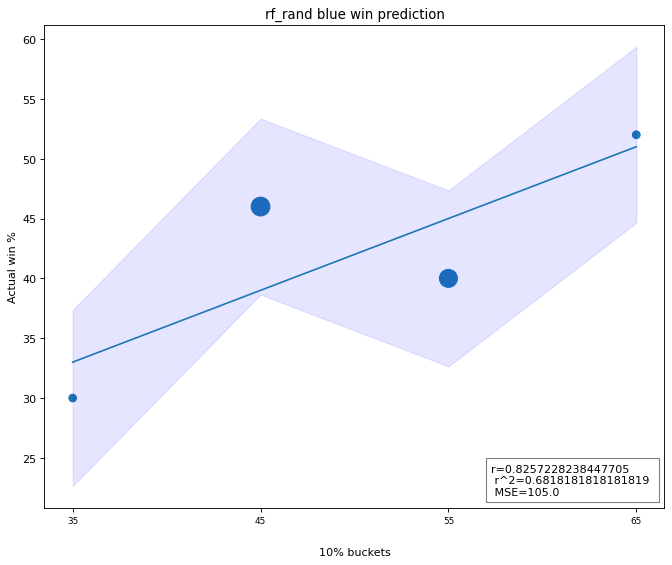

rf_up
0% to 10%: 0% of 0 observations
10% to 20%: 0% of 0 observations
20% to 30%: 62% of 26 observations
30% to 40%: 44% of 218 observations
40% to 50%: 39% of 351 observations
50% to 60%: 53% of 57 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


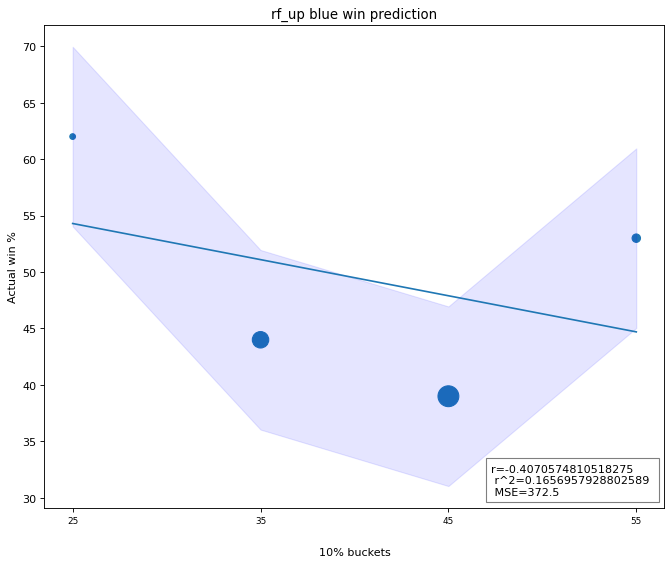

mlp_no
0% to 10%: 33% of 76 observations
10% to 20%: 26% of 111 observations
20% to 30%: 48% of 114 observations
30% to 40%: 47% of 100 observations
40% to 50%: 39% of 75 observations
50% to 60%: 47% of 59 observations
60% to 70%: 53% of 40 observations
70% to 80%: 55% of 42 observations
80% to 90%: 77% of 22 observations
90% to 100%: 50% of 4 observations


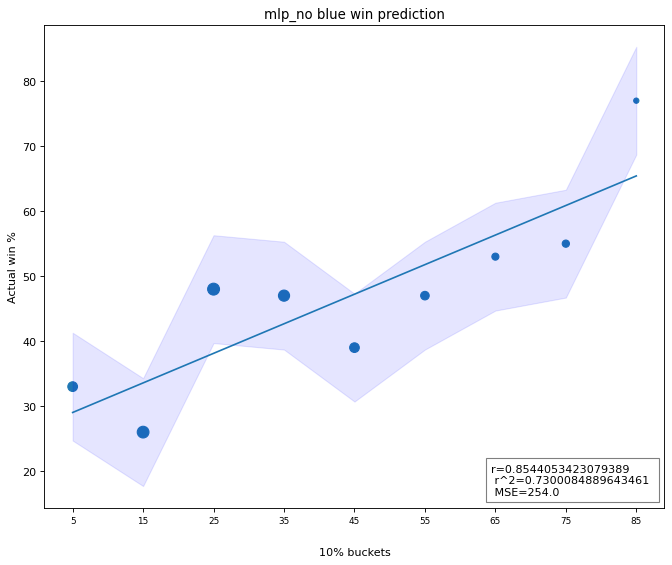

mlp_rand
0% to 10%: 15% of 41 observations
10% to 20%: 30% of 54 observations
20% to 30%: 38% of 74 observations
30% to 40%: 41% of 68 observations
40% to 50%: 34% of 76 observations
50% to 60%: 46% of 87 observations
60% to 70%: 49% of 86 observations
70% to 80%: 53% of 75 observations
80% to 90%: 53% of 58 observations
90% to 100%: 68% of 25 observations


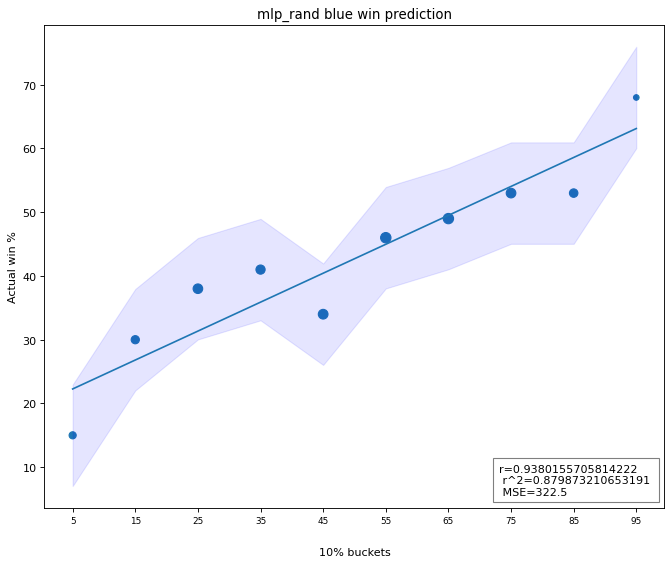

mlp_up
0% to 10%: 30% of 105 observations
10% to 20%: 39% of 93 observations
20% to 30%: 36% of 80 observations
30% to 40%: 55% of 58 observations
40% to 50%: 47% of 76 observations
50% to 60%: 37% of 54 observations
60% to 70%: 54% of 48 observations
70% to 80%: 51% of 45 observations
80% to 90%: 50% of 42 observations
90% to 100%: 51% of 47 observations


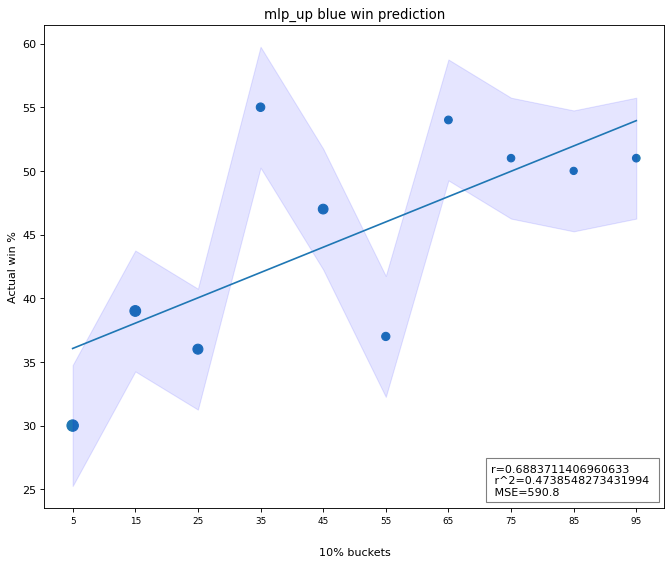

nn_no
0% to 10%: 18% of 38 observations
10% to 20%: 30% of 99 observations
20% to 30%: 36% of 146 observations
30% to 40%: 46% of 118 observations
40% to 50%: 52% of 110 observations
50% to 60%: 49% of 72 observations
60% to 70%: 68% of 47 observations
70% to 80%: 71% of 7 observations
80% to 90%: 56% of 9 observations
90% to 100%: 0% of 0 observations


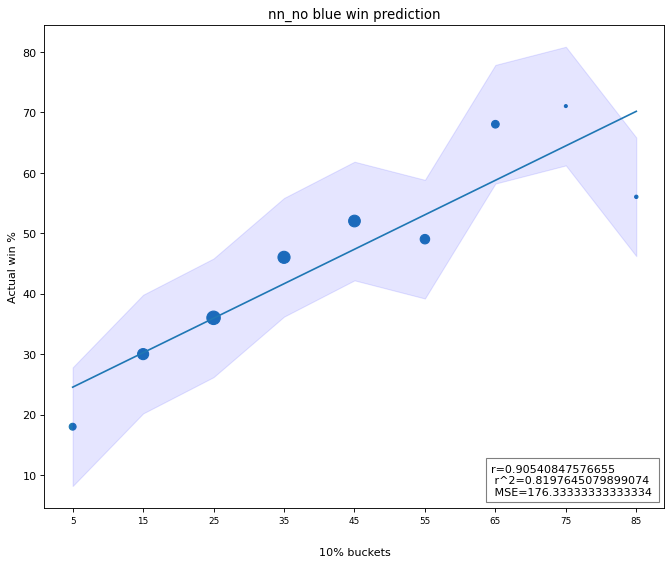

nn_rand
0% to 10%: 25% of 4 observations
10% to 20%: 15% of 26 observations
20% to 30%: 23% of 80 observations
30% to 40%: 40% of 90 observations
40% to 50%: 34% of 128 observations
50% to 60%: 48% of 127 observations
60% to 70%: 55% of 99 observations
70% to 80%: 61% of 64 observations
80% to 90%: 83% of 18 observations
90% to 100%: 100% of 3 observations


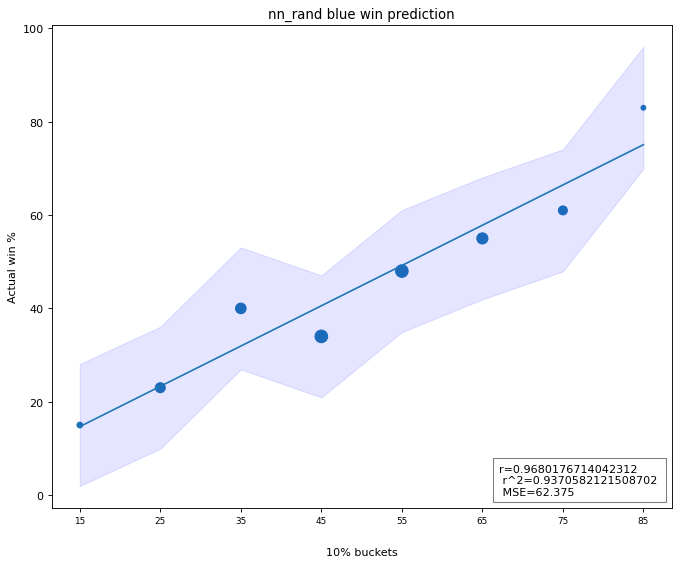

nn_up
0% to 10%: 27% of 41 observations
10% to 20%: 32% of 62 observations
20% to 30%: 34% of 89 observations
30% to 40%: 48% of 94 observations
40% to 50%: 40% of 78 observations
50% to 60%: 44% of 90 observations
60% to 70%: 45% of 93 observations
70% to 80%: 61% of 57 observations
80% to 90%: 48% of 29 observations
90% to 100%: 70% of 10 observations


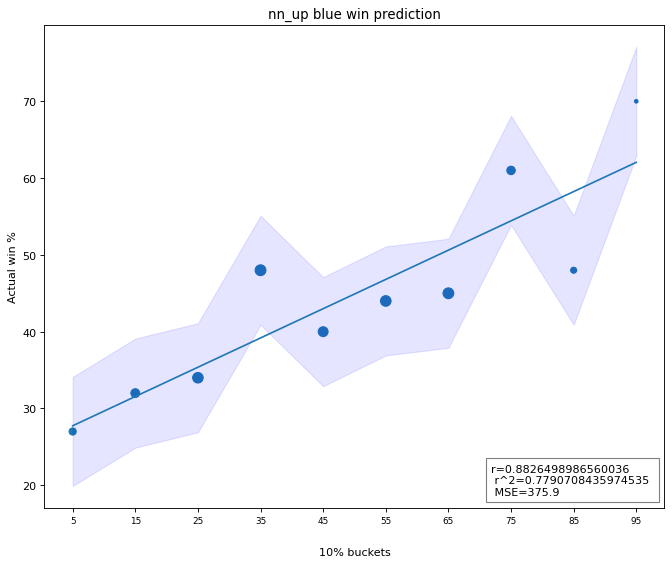

mix_no
0% to 10%: 25% of 4 observations
10% to 20%: 21% of 38 observations
20% to 30%: 31% of 170 observations
30% to 40%: 45% of 181 observations
40% to 50%: 51% of 158 observations
50% to 60%: 54% of 83 observations
60% to 70%: 60% of 15 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


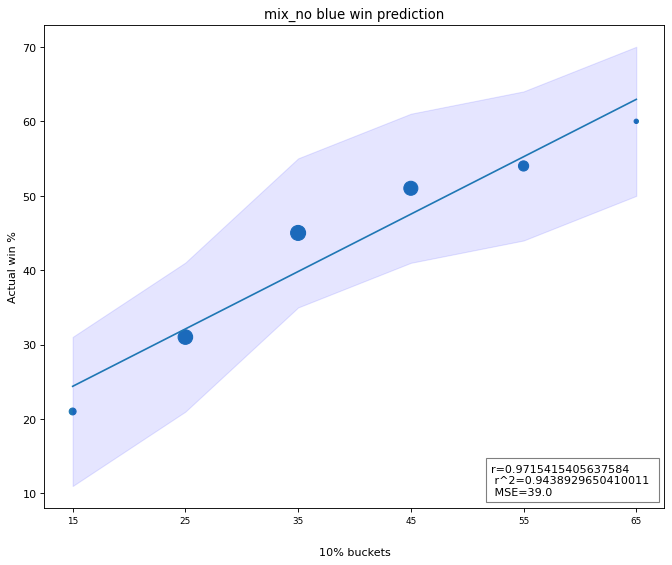

mix_rand
0% to 10%: 0% of 0 observations
10% to 20%: 0% of 4 observations
20% to 30%: 31% of 42 observations
30% to 40%: 28% of 89 observations
40% to 50%: 36% of 166 observations
50% to 60%: 41% of 188 observations
60% to 70%: 62% of 117 observations
70% to 80%: 68% of 19 observations
80% to 90%: 100% of 3 observations
90% to 100%: 0% of 0 observations


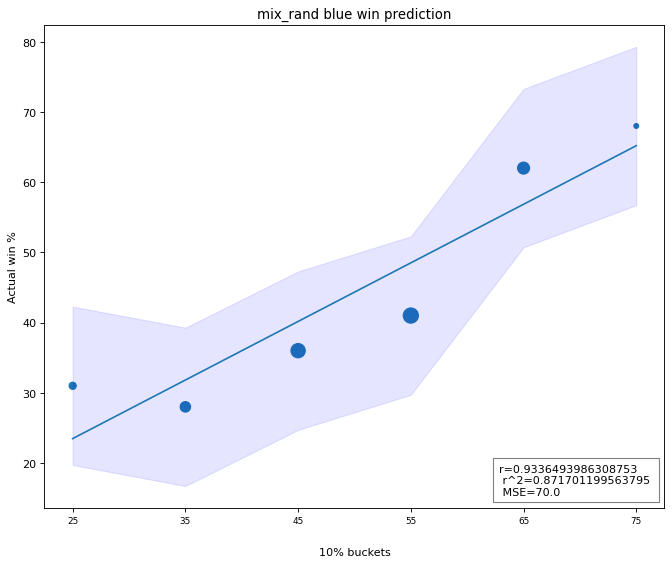

mix_up
0% to 10%: 0% of 0 observations
10% to 20%: 36% of 11 observations
20% to 30%: 23% of 80 observations
30% to 40%: 38% of 141 observations
40% to 50%: 44% of 226 observations
50% to 60%: 52% of 151 observations
60% to 70%: 60% of 35 observations
70% to 80%: 100% of 1 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


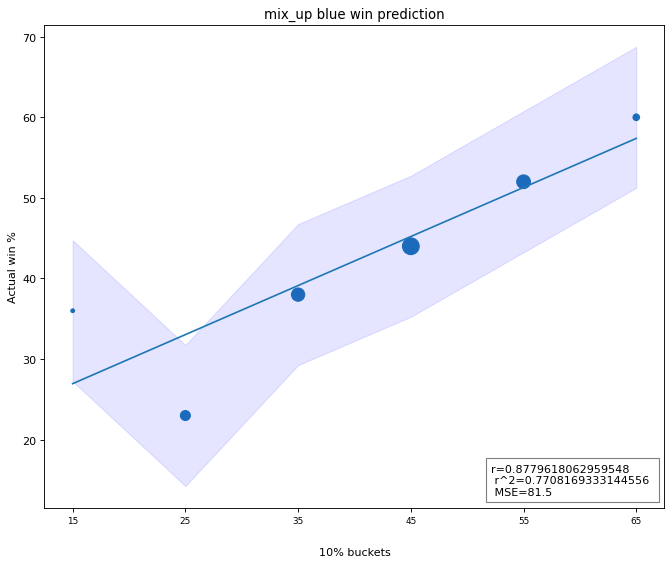

combined
0% to 10%: 0% of 0 observations
10% to 20%: 33% of 6 observations
20% to 30%: 16% of 62 observations
30% to 40%: 34% of 160 observations
40% to 50%: 42% of 204 observations
50% to 60%: 56% of 168 observations
60% to 70%: 64% of 36 observations
70% to 80%: 75% of 4 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


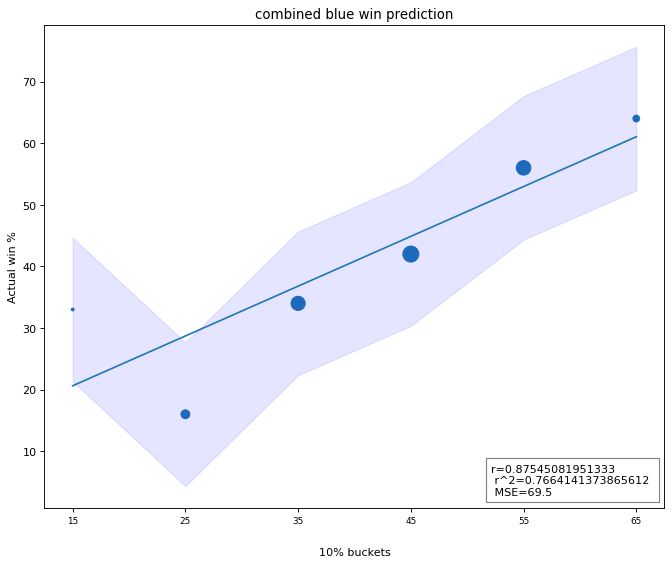

In [72]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
#     print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["blue_total_pct"] >= x]
        point_to_point = point_up[point_up["blue_total_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "blue"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    
    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual win %")
    plt.title(f"{perm_str} blue win prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [73]:
blue_win_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_win_df = pd.DataFrame(blue_win_dict)
blue_win_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.656206   0.430607    370.000000
1     knn_rand  0.900998   0.811798    247.428571
2       knn_up  0.484481   0.234722    532.000000
3       log_no  0.885436   0.783997    142.500000
4     log_rand  0.961277   0.924054    125.125000
5       log_up  0.936724   0.877452    207.222222
6        rf_no  0.400000   0.160000    136.500000
7      rf_rand  0.825723   0.681818    105.000000
8        rf_up -0.407057   0.165696    372.500000
9       mlp_no  0.854405   0.730008    254.000000
10    mlp_rand  0.938016   0.879873    322.500000
11      mlp_up  0.688371   0.473855    590.800000
12       nn_no  0.905408   0.819765    176.333333
13     nn_rand  0.968018   0.937058     62.375000
14       nn_up  0.882650   0.779071    375.900000
15      mix_no  0.971542   0.943893     39.000000
16    mix_rand  0.933649   0.871701     70.000000
17      mix_up  0.877962   0.770817     81.500000
18    combined  0.875451   0.766414     69.500000

['knn_no']
knn_no
0% to 10%: 0% of 7 observations
10% to 20%: 27% of 128 observations
20% to 30%: 23% of 185 observations
30% to 40%: 28% of 183 observations
40% to 50%: 32% of 104 observations
50% to 60%: 28% of 35 observations
60% to 70%: 40% of 10 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


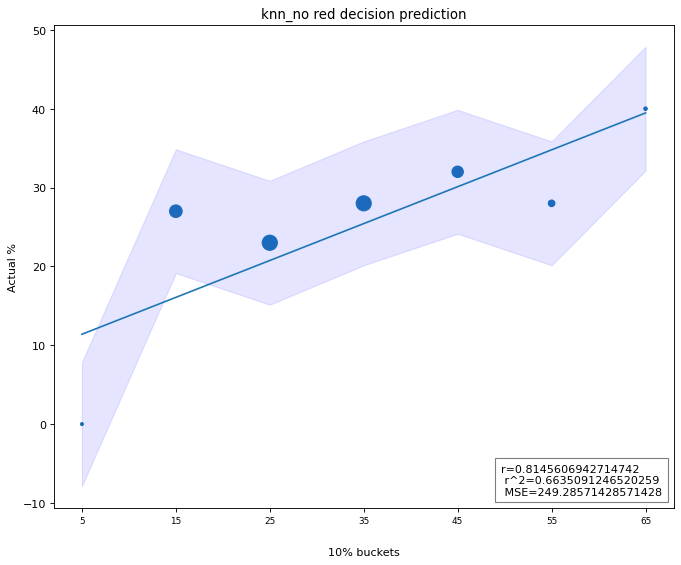

['knn_rand']
knn_rand
0% to 10%: 10% of 21 observations
10% to 20%: 26% of 212 observations
20% to 30%: 22% of 232 observations
30% to 40%: 35% of 124 observations
40% to 50%: 36% of 47 observations
50% to 60%: 43% of 14 observations
60% to 70%: 0% of 2 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


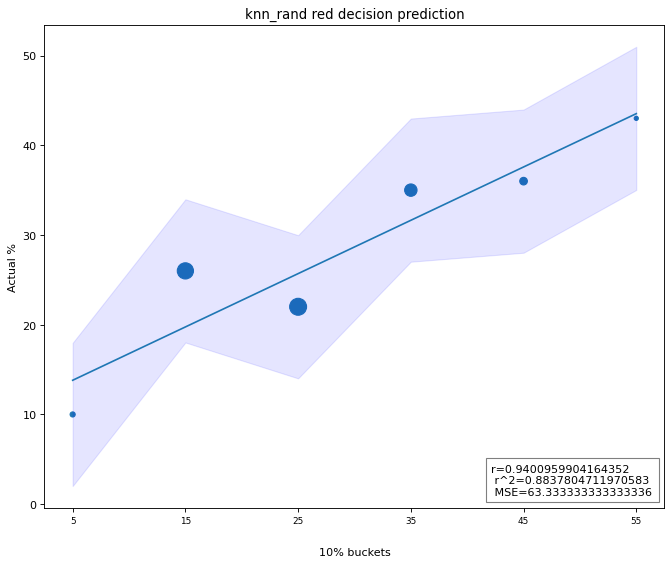

['knn_up']
knn_up
0% to 10%: 16% of 45 observations
10% to 20%: 28% of 180 observations
20% to 30%: 22% of 208 observations
30% to 40%: 34% of 145 observations
40% to 50%: 27% of 52 observations
50% to 60%: 38% of 16 observations
60% to 70%: 17% of 6 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


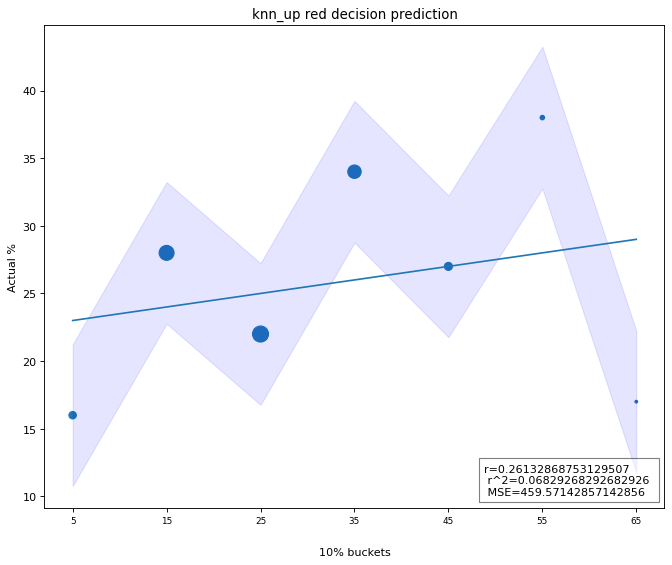

['log_no']
log_no
0% to 10%: 17% of 12 observations
10% to 20%: 26% of 112 observations
20% to 30%: 21% of 240 observations
30% to 40%: 33% of 177 observations
40% to 50%: 32% of 85 observations
50% to 60%: 32% of 22 observations
60% to 70%: 0% of 3 observations
70% to 80%: 0% of 1 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


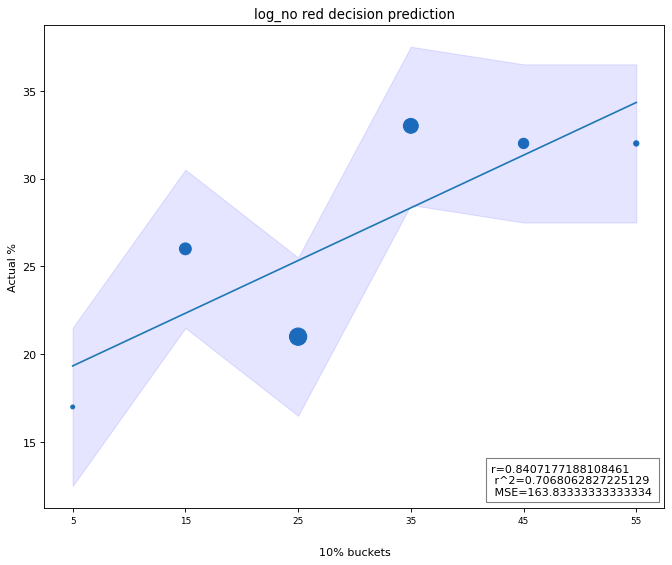

['log_rand']
log_rand
0% to 10%: 19% of 68 observations
10% to 20%: 20% of 190 observations
20% to 30%: 28% of 226 observations
30% to 40%: 34% of 111 observations
40% to 50%: 36% of 42 observations
50% to 60%: 22% of 9 observations
60% to 70%: 50% of 4 observations
70% to 80%: 0% of 2 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


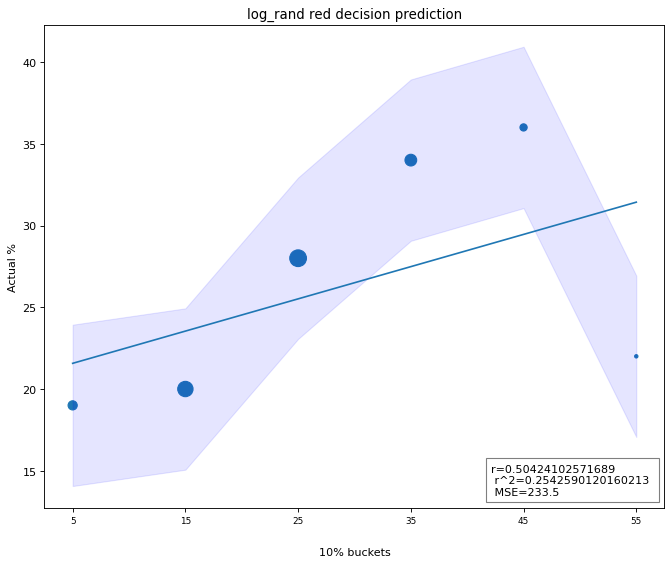

['log_up']
log_up
0% to 10%: 24% of 42 observations
10% to 20%: 25% of 215 observations
20% to 30%: 26% of 270 observations
30% to 40%: 36% of 90 observations
40% to 50%: 32% of 28 observations
50% to 60%: 0% of 5 observations
60% to 70%: 0% of 2 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


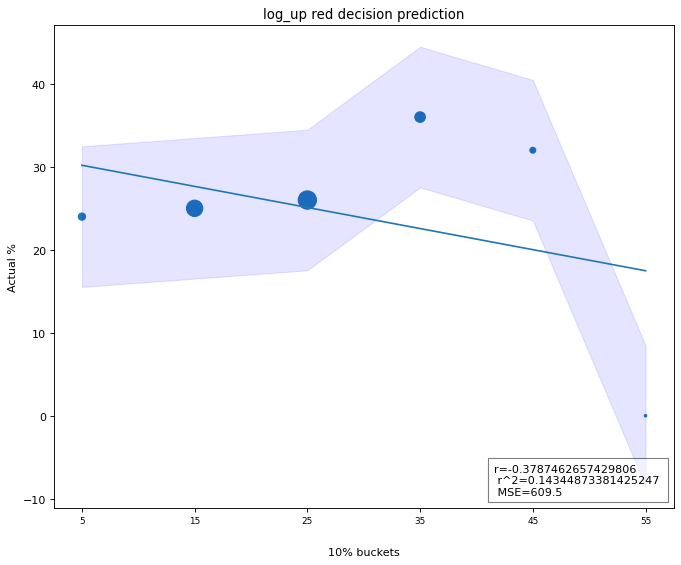

['rf_no']
rf_no
0% to 10%: 0% of 0 observations
10% to 20%: 30% of 27 observations
20% to 30%: 27% of 446 observations
30% to 40%: 27% of 161 observations
40% to 50%: 17% of 18 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


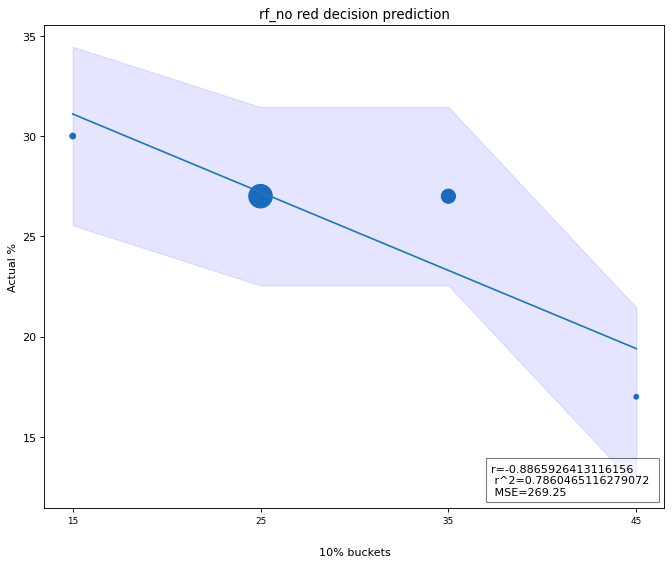

['rf_rand']
rf_rand
0% to 10%: 25% of 4 observations
10% to 20%: 26% of 185 observations
20% to 30%: 28% of 402 observations
30% to 40%: 16% of 56 observations
40% to 50%: 80% of 5 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


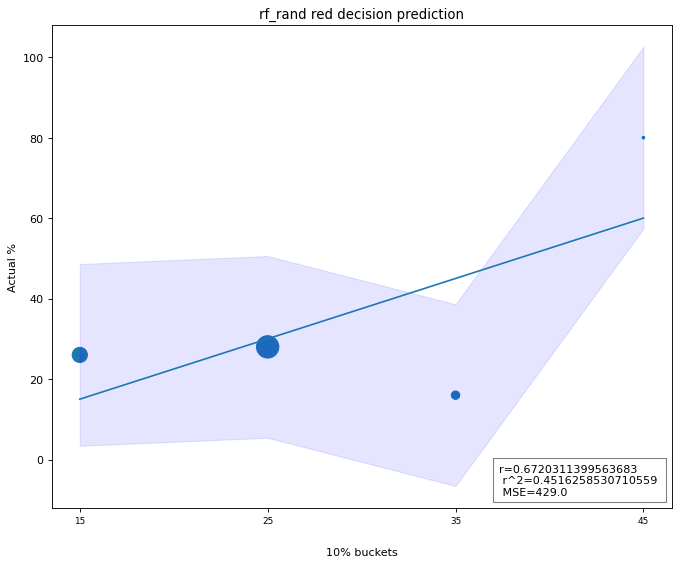

['rf_up']
rf_up
0% to 10%: 0% of 0 observations
10% to 20%: 27% of 44 observations
20% to 30%: 27% of 457 observations
30% to 40%: 27% of 144 observations
40% to 50%: 0% of 7 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


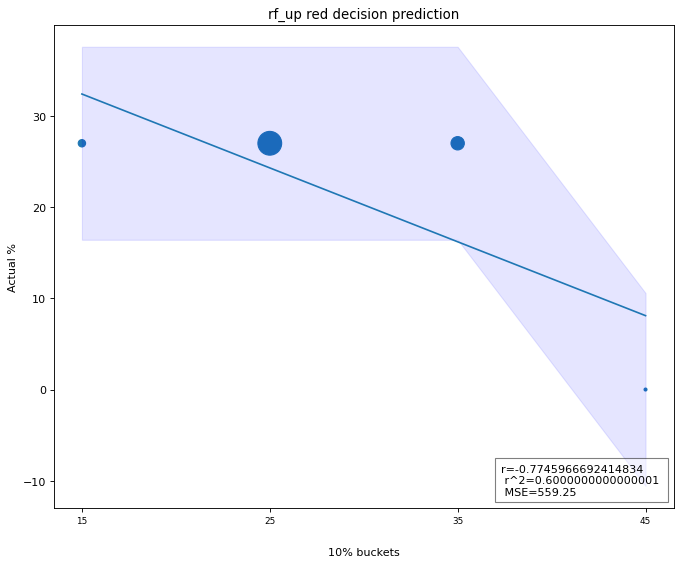

['mlp_no']
mlp_no
0% to 10%: 20% of 126 observations
10% to 20%: 26% of 127 observations
20% to 30%: 24% of 127 observations
30% to 40%: 37% of 90 observations
40% to 50%: 26% of 84 observations
50% to 60%: 34% of 53 observations
60% to 70%: 14% of 22 observations
70% to 80%: 62% of 13 observations
80% to 90%: 25% of 4 observations
90% to 100%: 33% of 3 observations


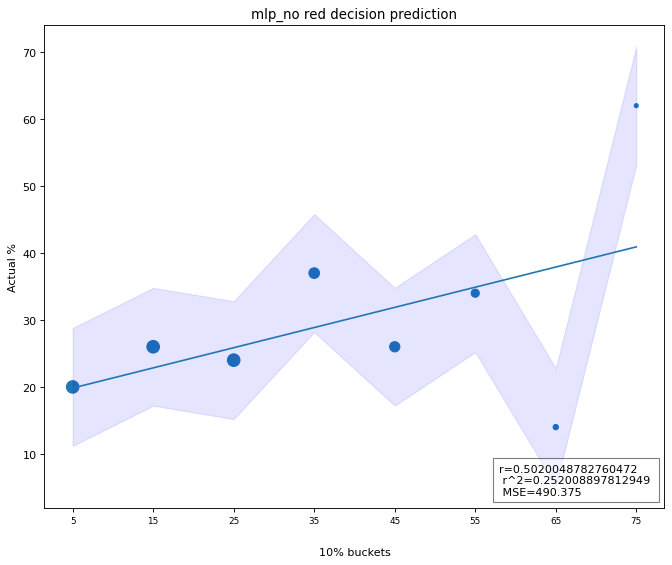

['mlp_rand']
mlp_rand
0% to 10%: 21% of 189 observations
10% to 20%: 23% of 153 observations
20% to 30%: 33% of 124 observations
30% to 40%: 27% of 52 observations
40% to 50%: 26% of 35 observations
50% to 60%: 39% of 41 observations
60% to 70%: 32% of 19 observations
70% to 80%: 31% of 16 observations
80% to 90%: 47% of 15 observations
90% to 100%: 0% of 3 observations


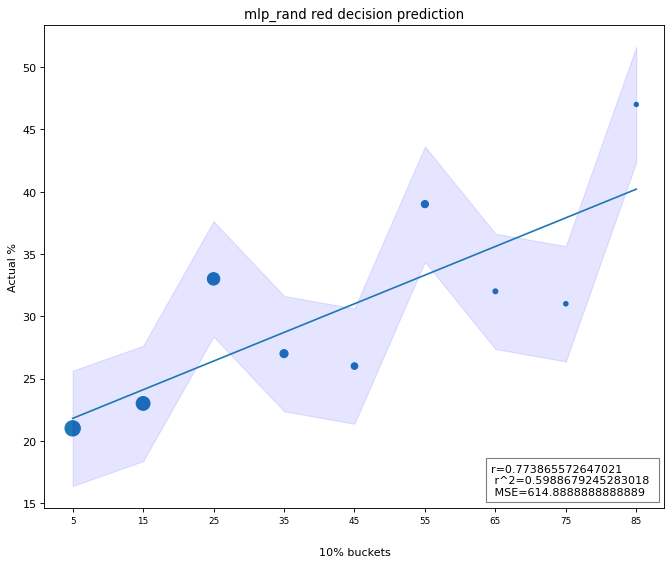

['mlp_up']
mlp_up
0% to 10%: 27% of 171 observations
10% to 20%: 23% of 128 observations
20% to 30%: 24% of 116 observations
30% to 40%: 30% of 77 observations
40% to 50%: 28% of 47 observations
50% to 60%: 30% of 43 observations
60% to 70%: 32% of 31 observations
70% to 80%: 28% of 18 observations
80% to 90%: 33% of 12 observations
90% to 100%: 40% of 5 observations


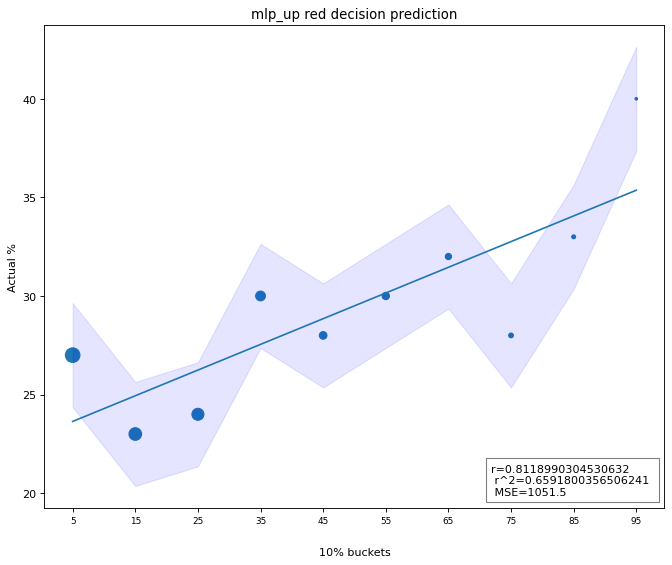

['nn_no']
nn_no
0% to 10%: 27% of 30 observations
10% to 20%: 18% of 120 observations
20% to 30%: 26% of 215 observations
30% to 40%: 28% of 137 observations
40% to 50%: 31% of 94 observations
50% to 60%: 41% of 34 observations
60% to 70%: 38% of 13 observations
70% to 80%: 0% of 5 observations
80% to 90%: 50% of 2 observations
90% to 100%: 0% of 0 observations


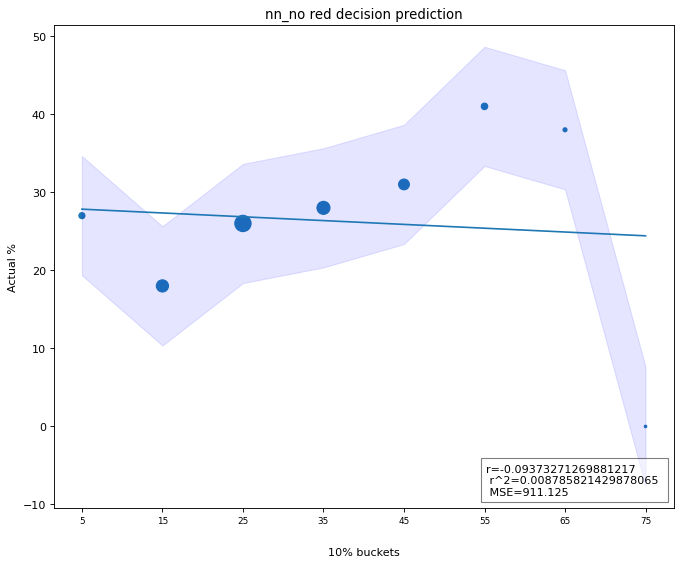

['nn_rand']
nn_rand
0% to 10%: 10% of 89 observations
10% to 20%: 23% of 191 observations
20% to 30%: 30% of 189 observations
30% to 40%: 28% of 102 observations
40% to 50%: 45% of 44 observations
50% to 60%: 42% of 26 observations
60% to 70%: 30% of 10 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


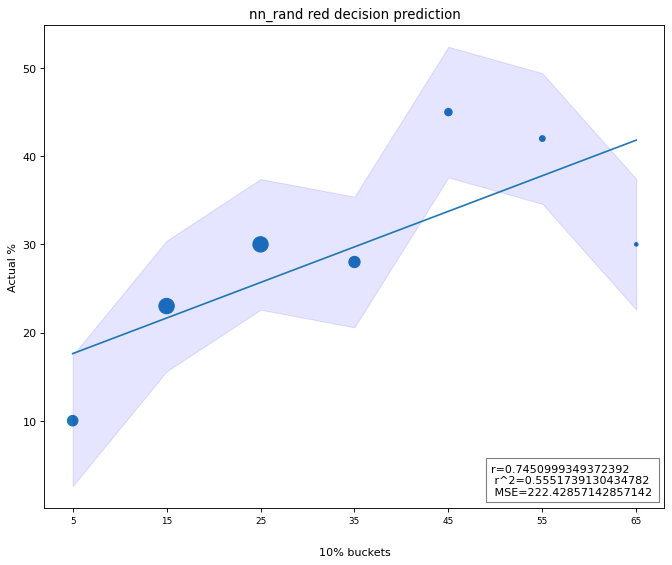

['nn_up']
nn_up
0% to 10%: 19% of 85 observations
10% to 20%: 23% of 200 observations
20% to 30%: 28% of 156 observations
30% to 40%: 39% of 101 observations
40% to 50%: 28% of 63 observations
50% to 60%: 18% of 33 observations
60% to 70%: 0% of 6 observations
70% to 80%: 67% of 3 observations
80% to 90%: 50% of 2 observations
90% to 100%: 0% of 0 observations


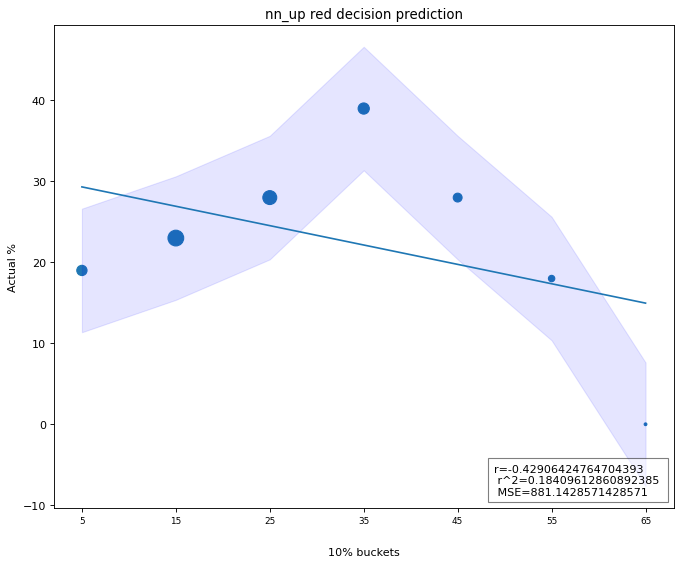

['mix_no']
mix_no
0% to 10%: 50% of 2 observations
10% to 20%: 17% of 101 observations
20% to 30%: 27% of 286 observations
30% to 40%: 32% of 192 observations
40% to 50%: 26% of 65 observations
50% to 60%: 33% of 6 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


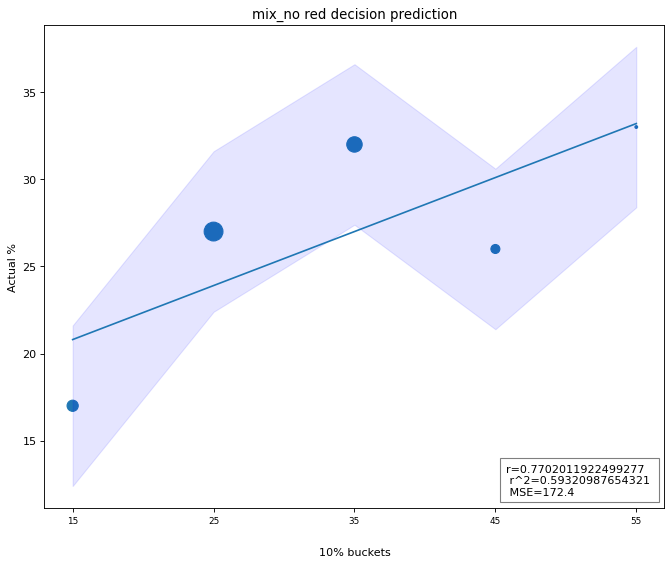

['mix_rand']
mix_rand
0% to 10%: 16% of 25 observations
10% to 20%: 18% of 221 observations
20% to 30%: 30% of 275 observations
30% to 40%: 38% of 96 observations
40% to 50%: 34% of 29 observations
50% to 60%: 40% of 5 observations
60% to 70%: 0% of 1 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


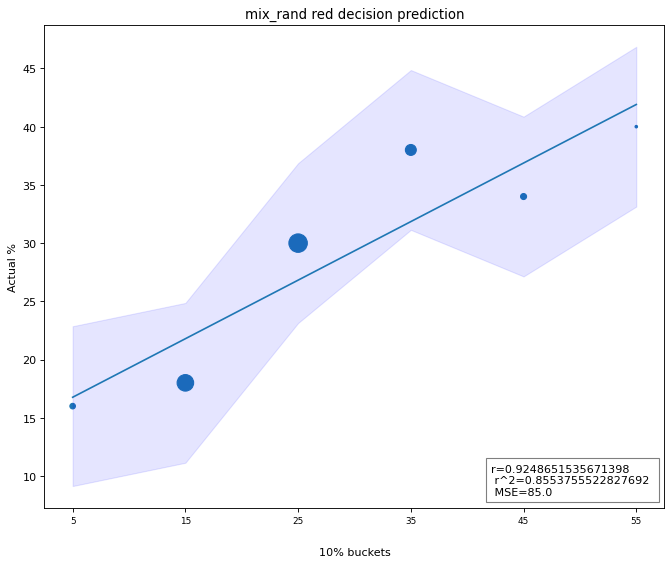

['mix_up']
mix_up
0% to 10%: 0% of 1 observations
10% to 20%: 16% of 137 observations
20% to 30%: 26% of 356 observations
30% to 40%: 36% of 139 observations
40% to 50%: 42% of 19 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


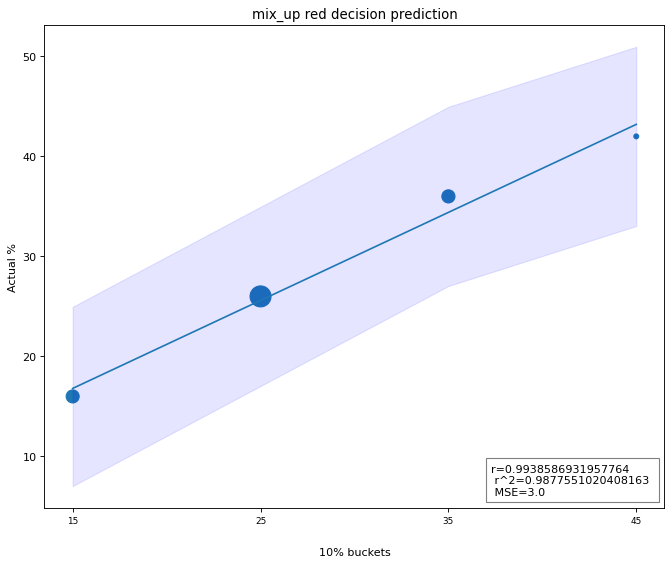

['combined']
combined
0% to 10%: 0% of 1 observations
10% to 20%: 18% of 132 observations
20% to 30%: 25% of 348 observations
30% to 40%: 37% of 139 observations
40% to 50%: 37% of 27 observations
50% to 60%: 20% of 5 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


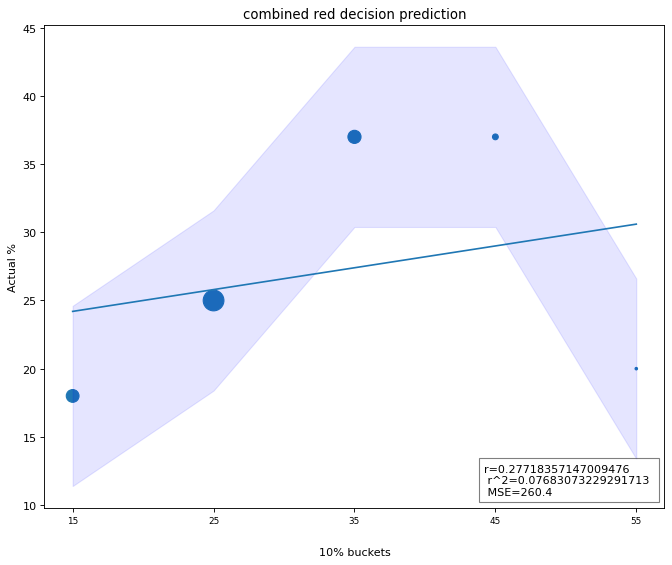

In [74]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["red_dec_pct"] >= x]
        point_to_point = point_up[point_up["red_dec_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Decision"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)

    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} red decision prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [75]:
red_dec_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_dec_df = pd.DataFrame(red_dec_dict)
red_dec_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.814561   0.663509    249.285714
1     knn_rand  0.940096   0.883780     63.333333
2       knn_up  0.261329   0.068293    459.571429
3       log_no  0.840718   0.706806    163.833333
4     log_rand  0.504241   0.254259    233.500000
5       log_up -0.378746   0.143449    609.500000
6        rf_no -0.886593   0.786047    269.250000
7      rf_rand  0.672031   0.451626    429.000000
8        rf_up -0.774597   0.600000    559.250000
9       mlp_no  0.502005   0.252009    490.375000
10    mlp_rand  0.773866   0.598868    614.888889
11      mlp_up  0.811899   0.659180   1051.500000
12       nn_no -0.093733   0.008786    911.125000
13     nn_rand  0.745100   0.555174    222.428571
14       nn_up -0.429064   0.184096    881.142857
15      mix_no  0.770201   0.593210    172.400000
16    mix_rand  0.924865   0.855376     85.000000
17      mix_up  0.993859   0.987755      3.000000
18    combined  0.277184   0.076831    260.400000

['knn_no']
knn_no
0% to 10%: 10% of 84 observations
10% to 20%: 16% of 341 observations
20% to 30%: 26% of 143 observations
30% to 40%: 28% of 65 observations
40% to 50%: 15% of 13 observations
50% to 60%: 17% of 6 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


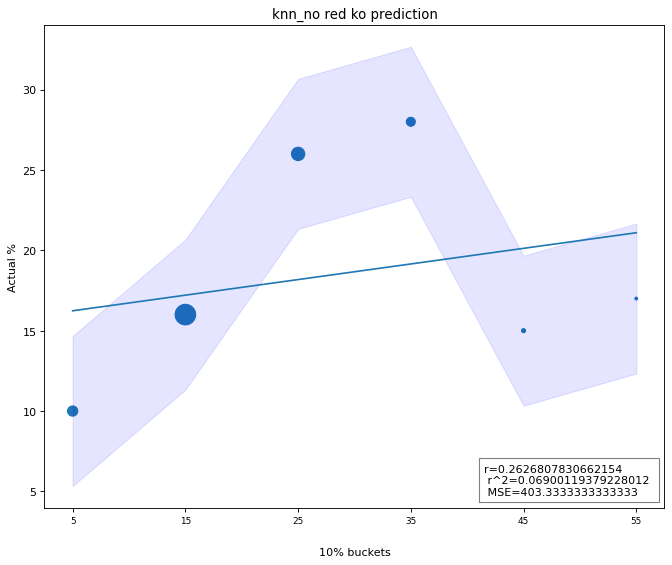

['knn_rand']
knn_rand
0% to 10%: 17% of 106 observations
10% to 20%: 17% of 372 observations
20% to 30%: 24% of 127 observations
30% to 40%: 24% of 38 observations
40% to 50%: 14% of 7 observations
50% to 60%: 0% of 2 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


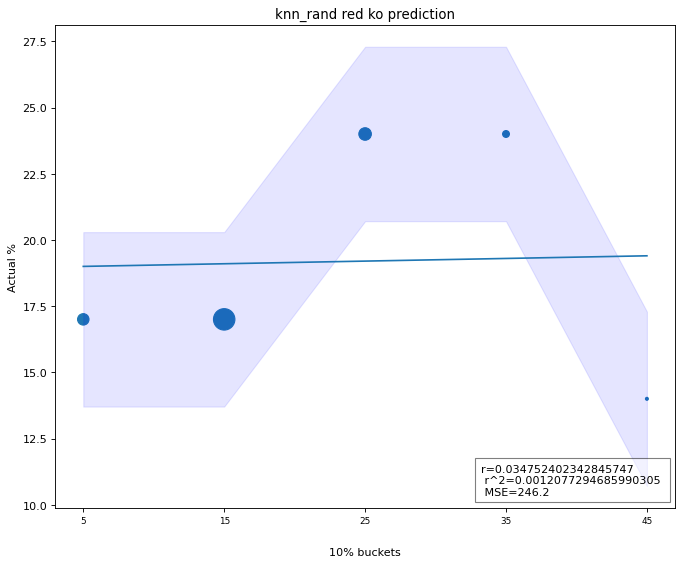

['knn_up']
knn_up
0% to 10%: 9% of 182 observations
10% to 20%: 21% of 278 observations
20% to 30%: 23% of 131 observations
30% to 40%: 28% of 52 observations
40% to 50%: 11% of 9 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


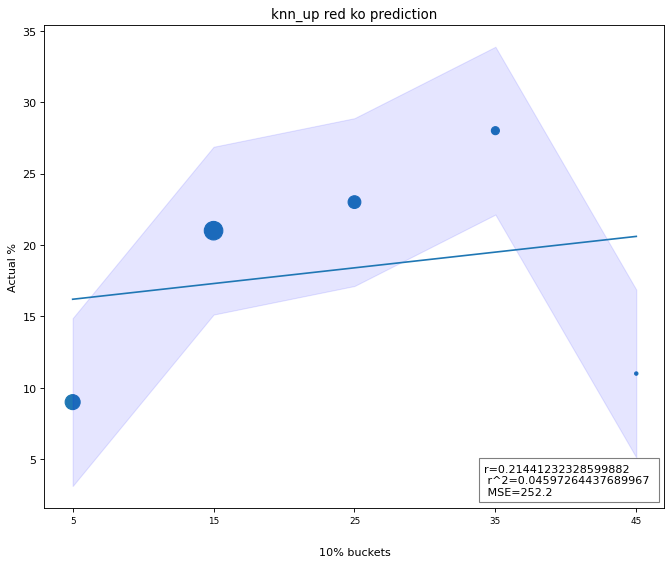

['log_no']
log_no
0% to 10%: 8% of 122 observations
10% to 20%: 13% of 206 observations
20% to 30%: 20% of 170 observations
30% to 40%: 21% of 76 observations
40% to 50%: 44% of 50 observations
50% to 60%: 53% of 17 observations
60% to 70%: 33% of 6 observations
70% to 80%: 0% of 2 observations
80% to 90%: 0% of 1 observations
90% to 100%: 0% of 0 observations


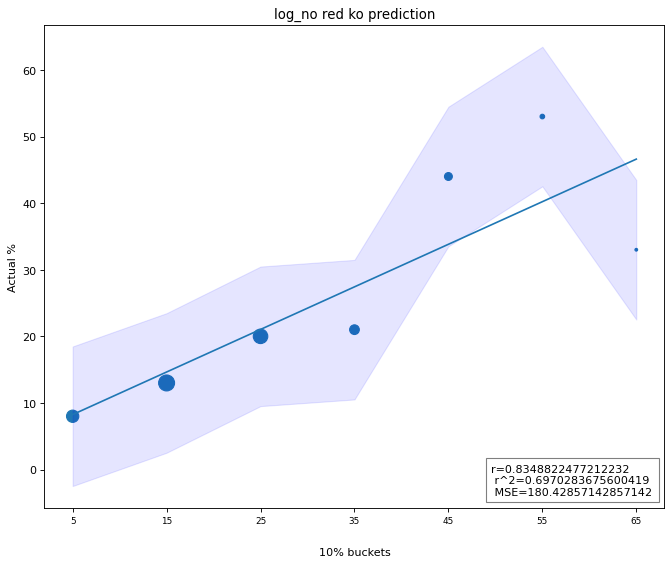

['log_rand']
log_rand
0% to 10%: 9% of 176 observations
10% to 20%: 17% of 271 observations
20% to 30%: 19% of 123 observations
30% to 40%: 44% of 57 observations
40% to 50%: 50% of 18 observations
50% to 60%: 20% of 5 observations
60% to 70%: 50% of 2 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


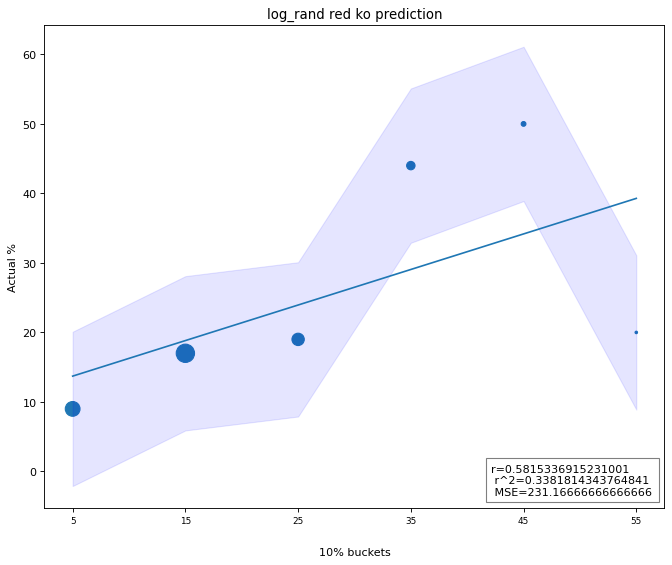

['log_up']
log_up
0% to 10%: 10% of 224 observations
10% to 20%: 15% of 208 observations
20% to 30%: 22% of 126 observations
30% to 40%: 38% of 58 observations
40% to 50%: 52% of 25 observations
50% to 60%: 43% of 7 observations
60% to 70%: 0% of 4 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


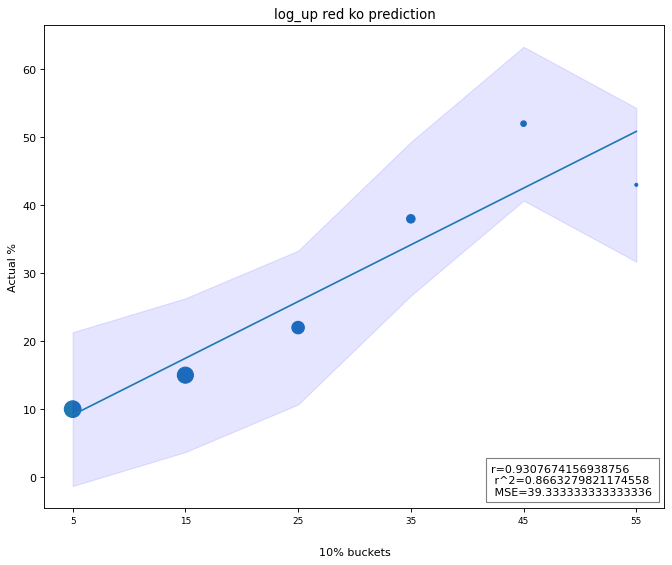

['rf_no']
rf_no
0% to 10%: 16% of 31 observations
10% to 20%: 18% of 501 observations
20% to 30%: 20% of 119 observations
30% to 40%: 0% of 1 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


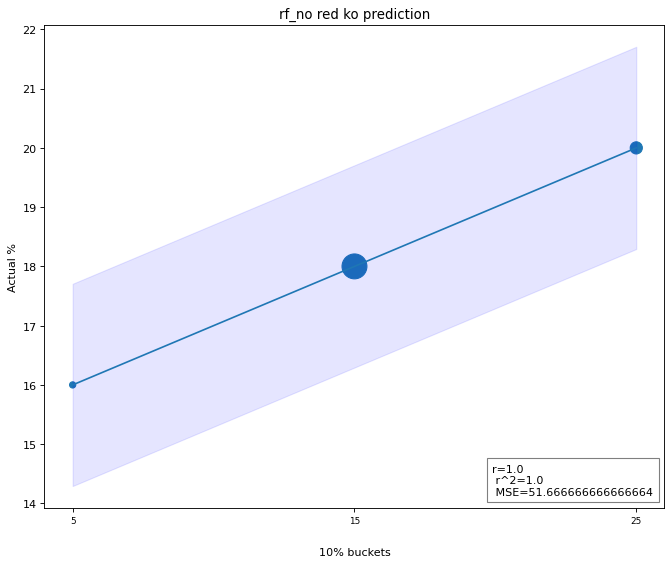

['rf_rand']
rf_rand
0% to 10%: 20% of 147 observations
10% to 20%: 17% of 455 observations
20% to 30%: 28% of 48 observations
30% to 40%: 0% of 1 observations
40% to 50%: 0% of 1 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


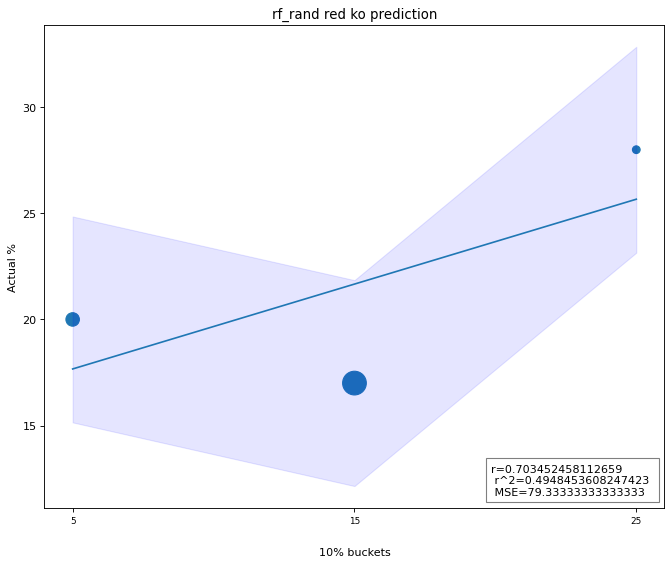

['rf_up']
rf_up
0% to 10%: 21% of 71 observations
10% to 20%: 19% of 501 observations
20% to 30%: 15% of 79 observations
30% to 40%: 0% of 1 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


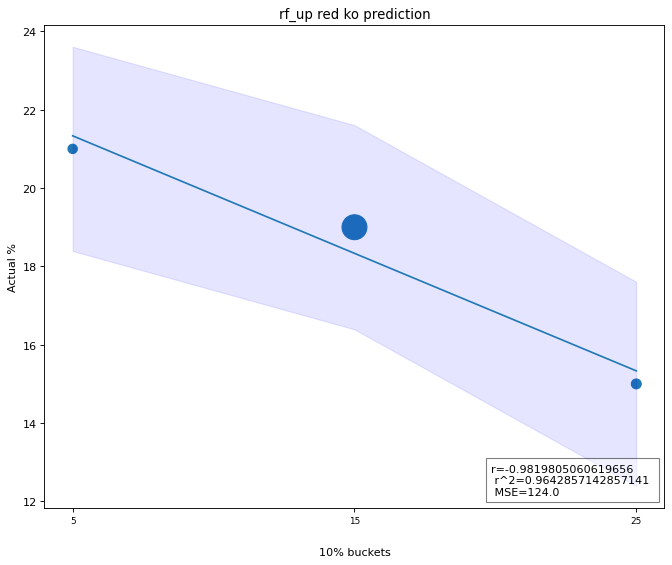

['mlp_no']
mlp_no
0% to 10%: 12% of 247 observations
10% to 20%: 16% of 142 observations
20% to 30%: 27% of 82 observations
30% to 40%: 17% of 58 observations
40% to 50%: 31% of 45 observations
50% to 60%: 24% of 25 observations
60% to 70%: 19% of 16 observations
70% to 80%: 28% of 18 observations
80% to 90%: 40% of 10 observations
90% to 100%: 50% of 6 observations


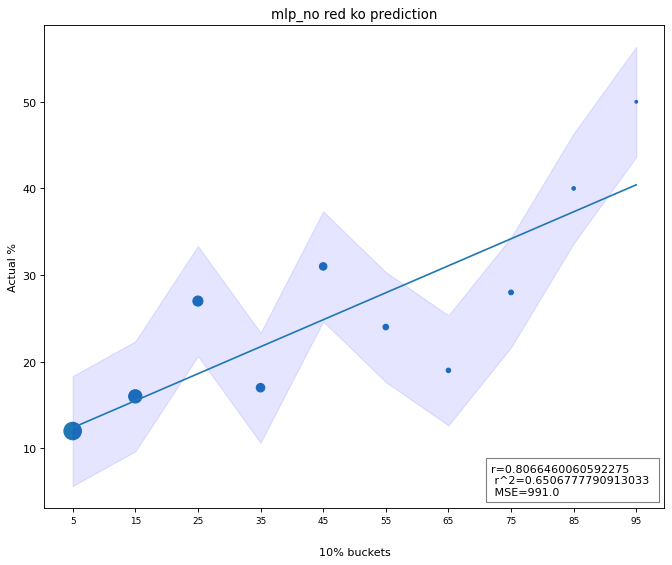

['mlp_rand']
mlp_rand
0% to 10%: 14% of 321 observations
10% to 20%: 20% of 142 observations
20% to 30%: 19% of 80 observations
30% to 40%: 17% of 36 observations
40% to 50%: 38% of 24 observations
50% to 60%: 37% of 19 observations
60% to 70%: 31% of 16 observations
70% to 80%: 50% of 6 observations
80% to 90%: 17% of 6 observations
90% to 100%: 100% of 1 observations


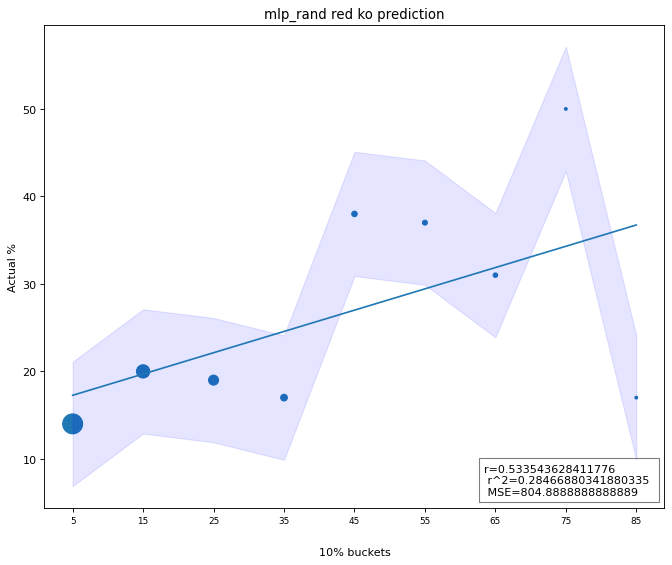

['mlp_up']
mlp_up
0% to 10%: 12% of 286 observations
10% to 20%: 16% of 138 observations
20% to 30%: 30% of 73 observations
30% to 40%: 18% of 39 observations
40% to 50%: 24% of 42 observations
50% to 60%: 23% of 30 observations
60% to 70%: 47% of 15 observations
70% to 80%: 50% of 10 observations
80% to 90%: 33% of 12 observations
90% to 100%: 75% of 4 observations


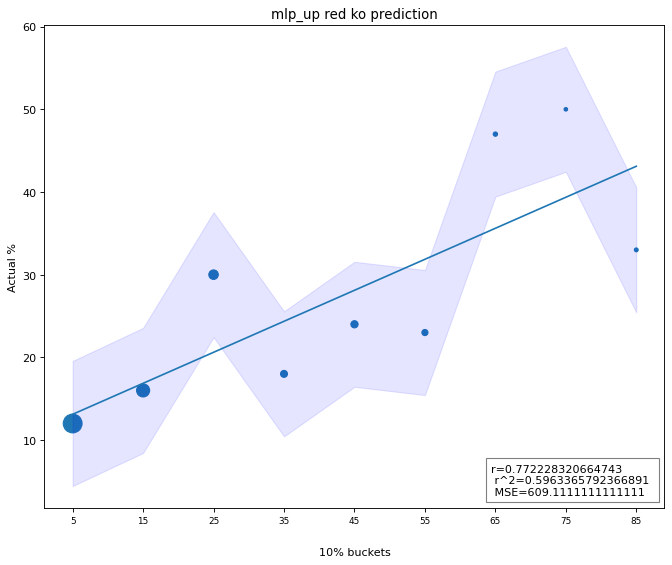

['nn_no']
nn_no
0% to 10%: 9% of 138 observations
10% to 20%: 13% of 203 observations
20% to 30%: 20% of 155 observations
30% to 40%: 20% of 71 observations
40% to 50%: 48% of 42 observations
50% to 60%: 28% of 25 observations
60% to 70%: 40% of 10 observations
70% to 80%: 75% of 4 observations
80% to 90%: 0% of 1 observations
90% to 100%: 100% of 1 observations


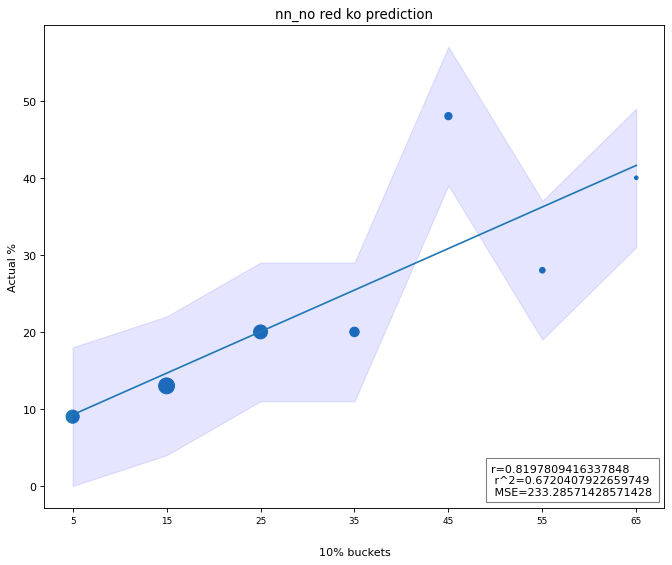

['nn_rand']
nn_rand
0% to 10%: 11% of 216 observations
10% to 20%: 18% of 224 observations
20% to 30%: 24% of 127 observations
30% to 40%: 11% of 45 observations
40% to 50%: 45% of 20 observations
50% to 60%: 36% of 14 observations
60% to 70%: 50% of 2 observations
70% to 80%: 100% of 1 observations
80% to 90%: 100% of 2 observations
90% to 100%: 0% of 0 observations


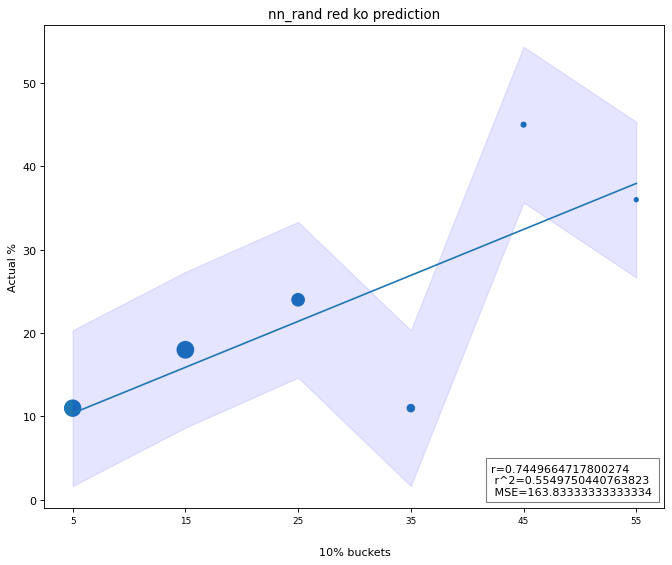

['nn_up']
nn_up
0% to 10%: 13% of 215 observations
10% to 20%: 15% of 185 observations
20% to 30%: 26% of 129 observations
30% to 40%: 18% of 57 observations
40% to 50%: 21% of 28 observations
50% to 60%: 45% of 22 observations
60% to 70%: 43% of 7 observations
70% to 80%: 50% of 6 observations
80% to 90%: 50% of 2 observations
90% to 100%: 0% of 0 observations


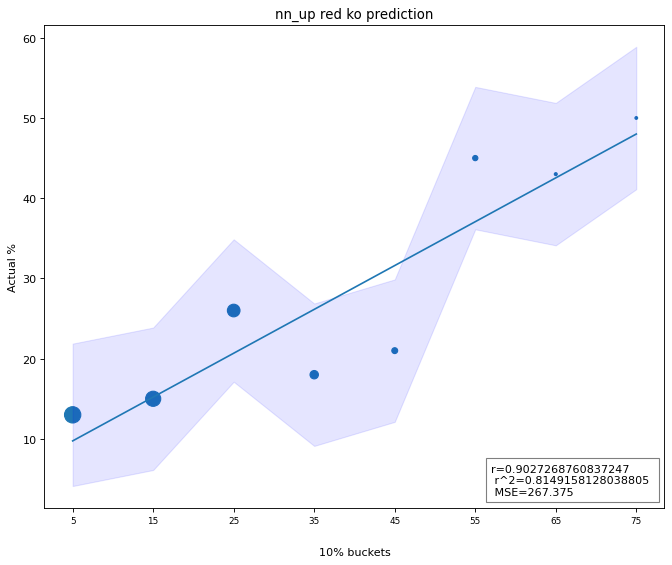

['mix_no']
mix_no
0% to 10%: 5% of 55 observations
10% to 20%: 15% of 268 observations
20% to 30%: 17% of 209 observations
30% to 40%: 33% of 88 observations
40% to 50%: 39% of 23 observations
50% to 60%: 38% of 8 observations
60% to 70%: 100% of 1 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


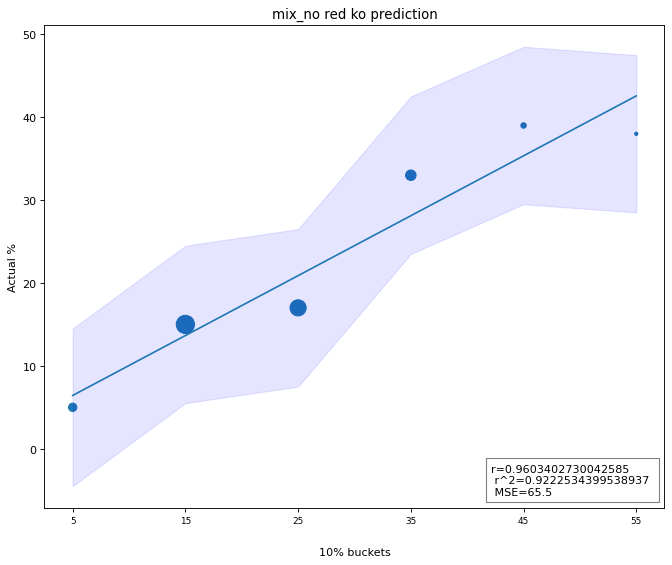

['mix_rand']
mix_rand
0% to 10%: 9% of 134 observations
10% to 20%: 16% of 308 observations
20% to 30%: 24% of 163 observations
30% to 40%: 45% of 31 observations
40% to 50%: 40% of 15 observations
50% to 60%: 100% of 1 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


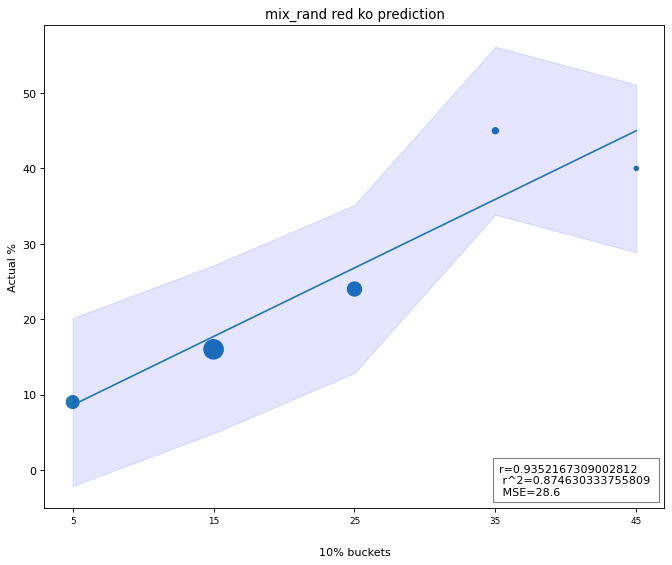

['mix_up']
mix_up
0% to 10%: 7% of 56 observations
10% to 20%: 13% of 326 observations
20% to 30%: 24% of 205 observations
30% to 40%: 31% of 51 observations
40% to 50%: 62% of 13 observations
50% to 60%: 0% of 1 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


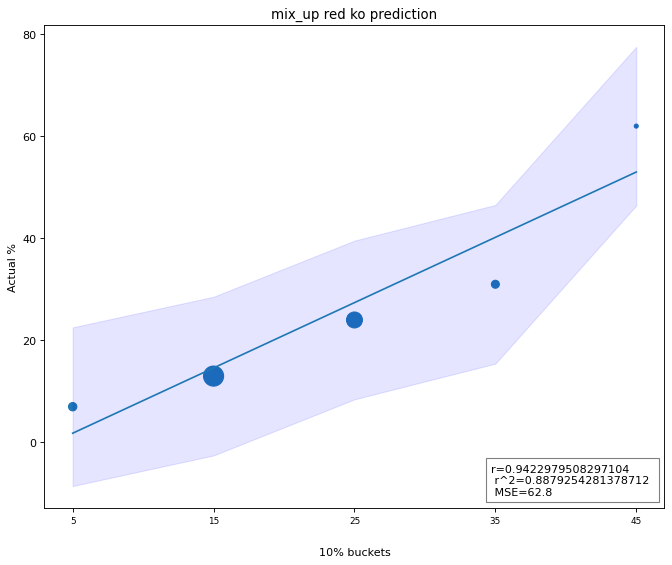

['combined']
combined
0% to 10%: 4% of 97 observations
10% to 20%: 16% of 322 observations
20% to 30%: 22% of 174 observations
30% to 40%: 40% of 50 observations
40% to 50%: 50% of 6 observations
50% to 60%: 67% of 3 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


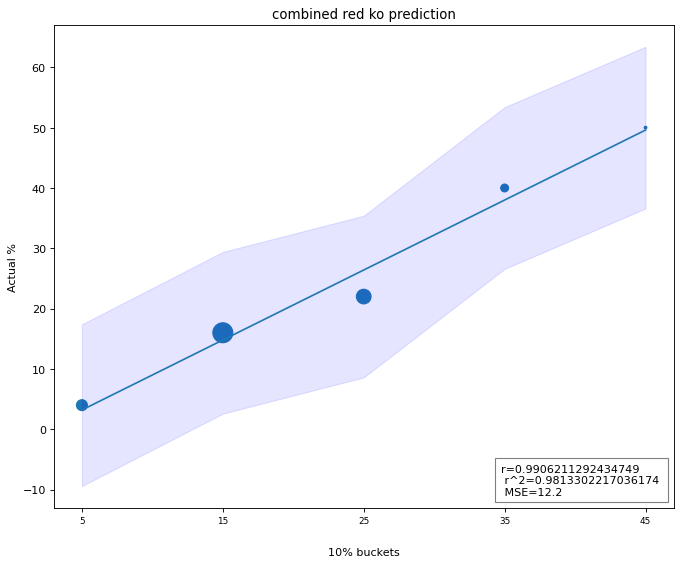

In [76]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["red_ko_pct"] >= x]
        point_to_point = point_up[point_up["red_ko_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - KO/TKO"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)

    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} red ko prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [77]:
red_ko_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_ko_df = pd.DataFrame(red_ko_dict)
red_ko_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.262681   0.069001    403.333333
1     knn_rand  0.034752   0.001208    246.200000
2       knn_up  0.214412   0.045973    252.200000
3       log_no  0.834882   0.697028    180.428571
4     log_rand  0.581534   0.338181    231.166667
5       log_up  0.930767   0.866328     39.333333
6        rf_no  1.000000   1.000000     51.666667
7      rf_rand  0.703452   0.494845     79.333333
8        rf_up -0.981981   0.964286    124.000000
9       mlp_no  0.806646   0.650678    991.000000
10    mlp_rand  0.533544   0.284669    804.888889
11      mlp_up  0.772228   0.596337    609.111111
12       nn_no  0.819781   0.672041    233.285714
13     nn_rand  0.744966   0.554975    163.833333
14       nn_up  0.902727   0.814916    267.375000
15      mix_no  0.960340   0.922253     65.500000
16    mix_rand  0.935217   0.874630     28.600000
17      mix_up  0.942298   0.887925     62.800000
18    combined  0.990621   0.981330     12.200000

['knn_no']
knn_no
0% to 10%: 10% of 271 observations
10% to 20%: 13% of 319 observations
20% to 30%: 18% of 51 observations
30% to 40%: 27% of 11 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


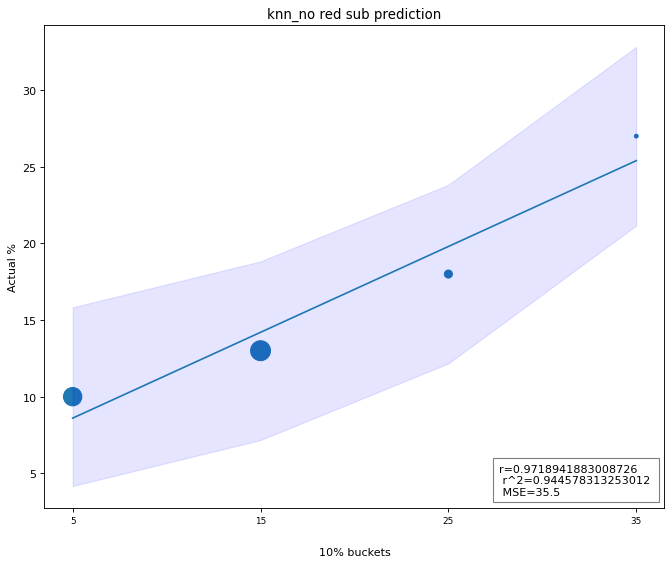

['knn_rand']
knn_rand
0% to 10%: 9% of 340 observations
10% to 20%: 15% of 282 observations
20% to 30%: 30% of 23 observations
30% to 40%: 14% of 7 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


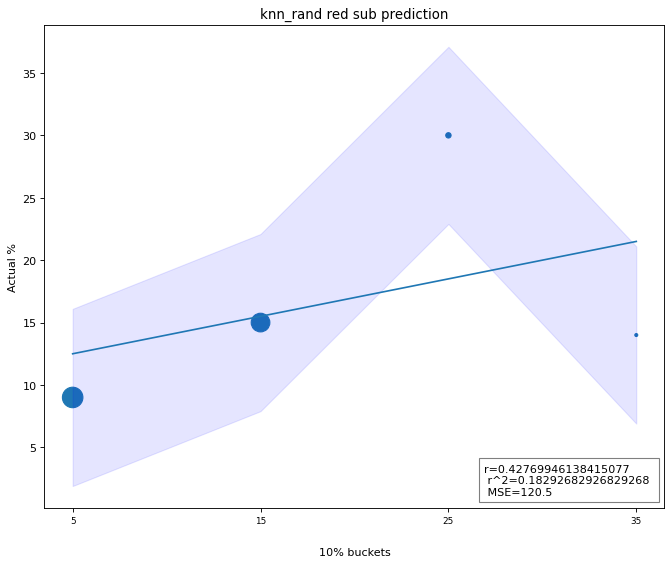

['knn_up']
knn_up
0% to 10%: 10% of 377 observations
10% to 20%: 15% of 223 observations
20% to 30%: 16% of 44 observations
30% to 40%: 28% of 7 observations
40% to 50%: 0% of 1 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


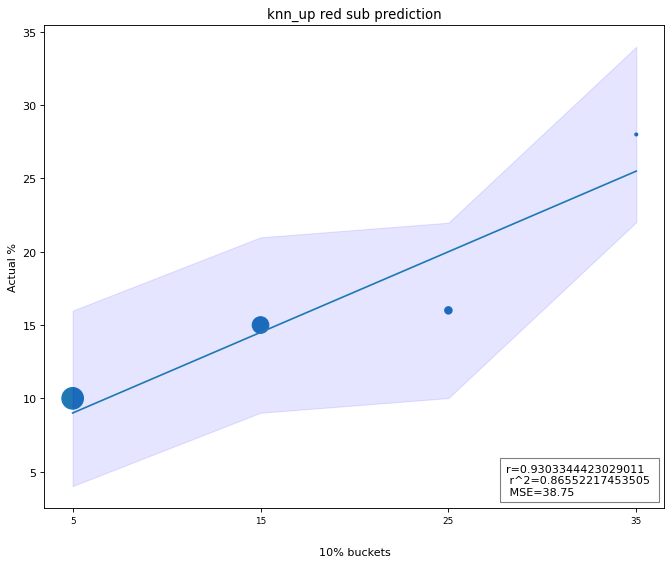

['log_no']
log_no
0% to 10%: 6% of 317 observations
10% to 20%: 15% of 207 observations
20% to 30%: 16% of 82 observations
30% to 40%: 36% of 28 observations
40% to 50%: 22% of 9 observations
50% to 60%: 40% of 5 observations
60% to 70%: 0% of 1 observations
70% to 80%: 0% of 1 observations
80% to 90%: 50% of 2 observations
90% to 100%: 0% of 0 observations


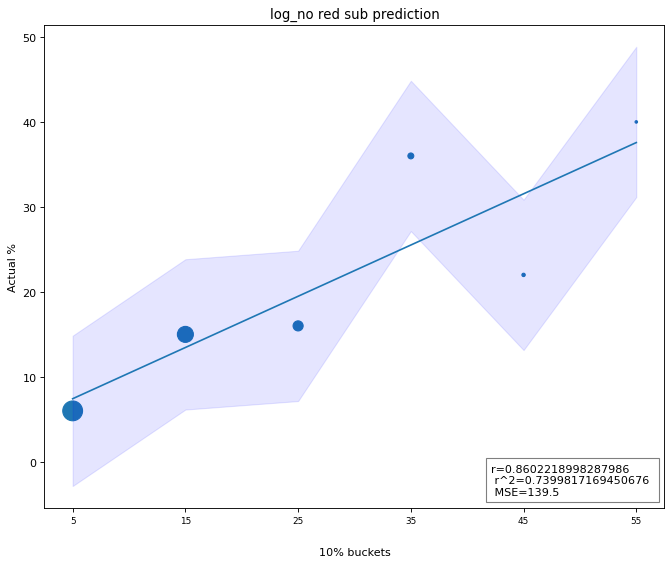

['log_rand']
log_rand
0% to 10%: 8% of 429 observations
10% to 20%: 17% of 152 observations
20% to 30%: 23% of 44 observations
30% to 40%: 28% of 14 observations
40% to 50%: 43% of 7 observations
50% to 60%: 0% of 2 observations
60% to 70%: 100% of 1 observations
70% to 80%: 33% of 3 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


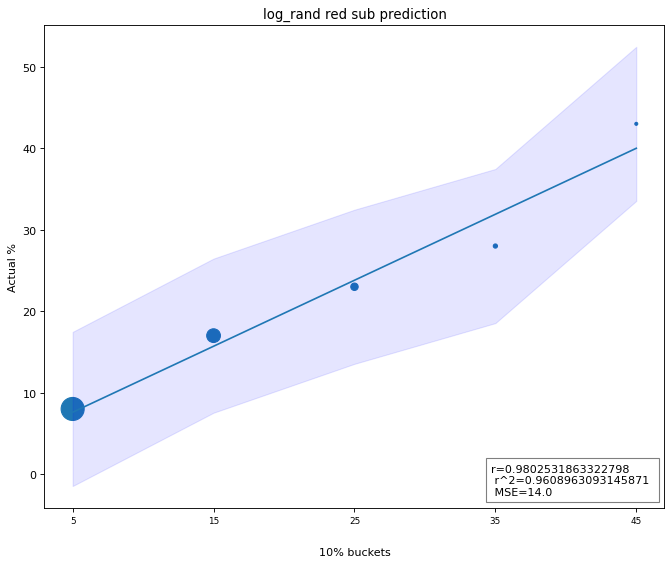

['log_up']
log_up
0% to 10%: 8% of 409 observations
10% to 20%: 15% of 163 observations
20% to 30%: 25% of 53 observations
30% to 40%: 40% of 15 observations
40% to 50%: 25% of 8 observations
50% to 60%: 0% of 1 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 1 observations
80% to 90%: 50% of 2 observations
90% to 100%: 0% of 0 observations


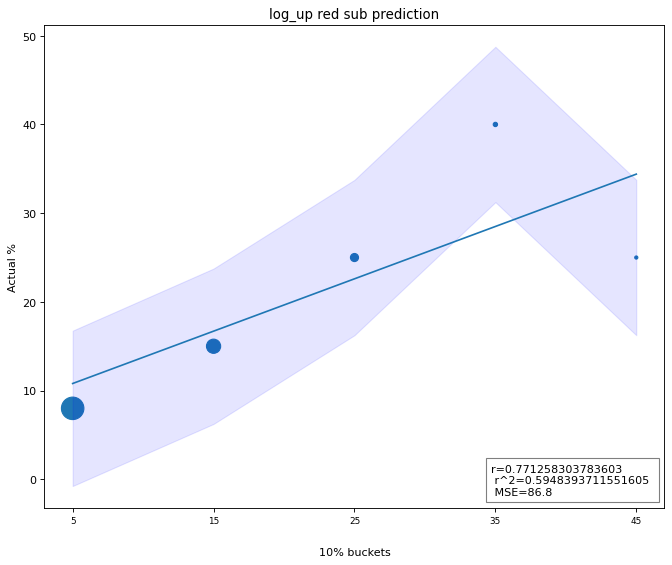

['rf_no']
rf_no
0% to 10%: 0% of 6 observations
10% to 20%: 11% of 354 observations
20% to 30%: 13% of 286 observations
30% to 40%: 50% of 6 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


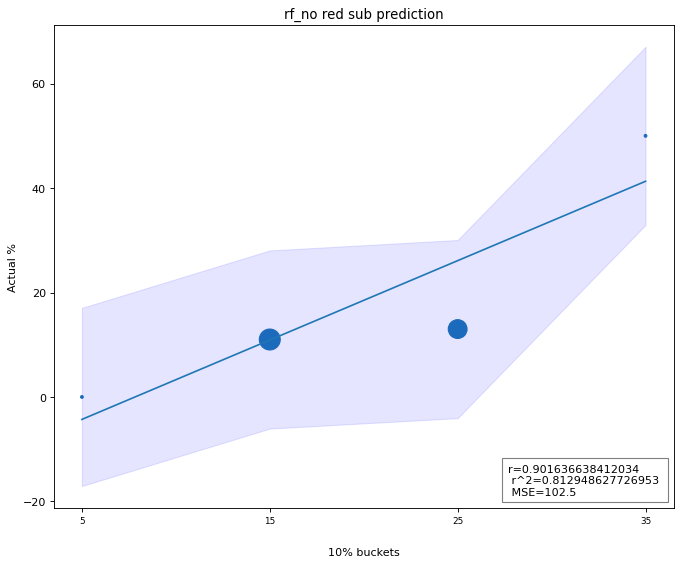

['rf_rand']
rf_rand
0% to 10%: 15% of 75 observations
10% to 20%: 10% of 496 observations
20% to 30%: 20% of 79 observations
30% to 40%: 0% of 2 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


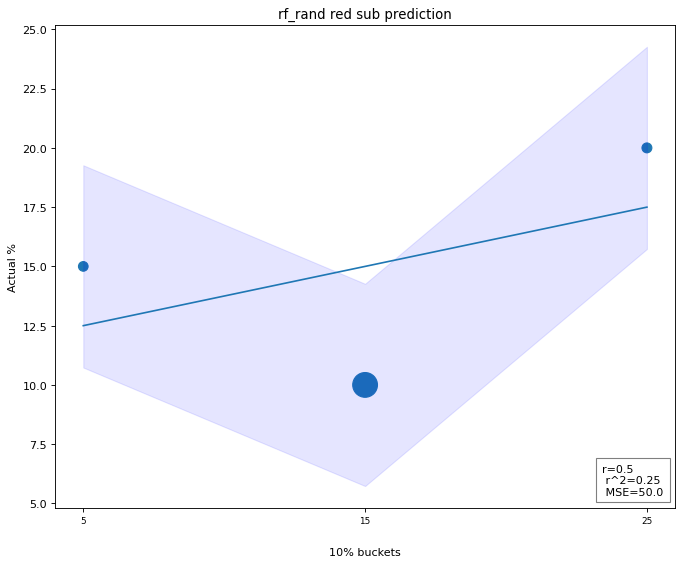

['rf_up']
rf_up
0% to 10%: 0% of 16 observations
10% to 20%: 12% of 461 observations
20% to 30%: 13% of 173 observations
30% to 40%: 50% of 2 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


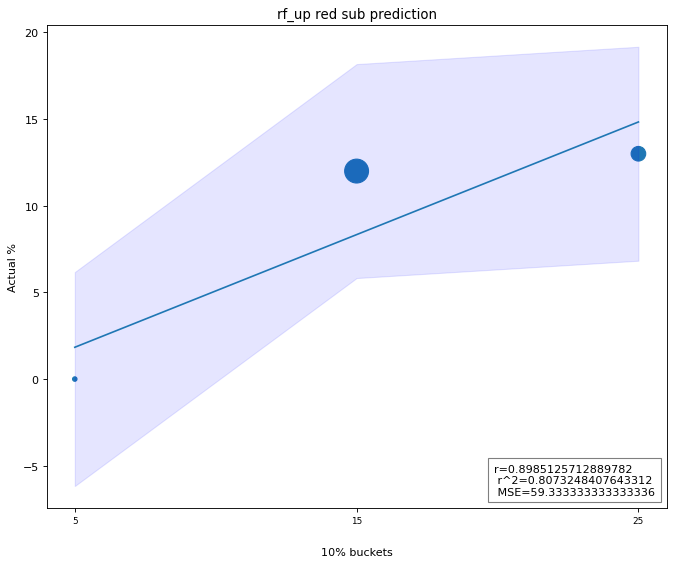

['mlp_no']
mlp_no
0% to 10%: 8% of 386 observations
10% to 20%: 18% of 115 observations
20% to 30%: 11% of 62 observations
30% to 40%: 43% of 23 observations
40% to 50%: 12% of 24 observations
50% to 60%: 4% of 23 observations
60% to 70%: 12% of 8 observations
70% to 80%: 50% of 4 observations
80% to 90%: 0% of 1 observations
90% to 100%: 67% of 3 observations


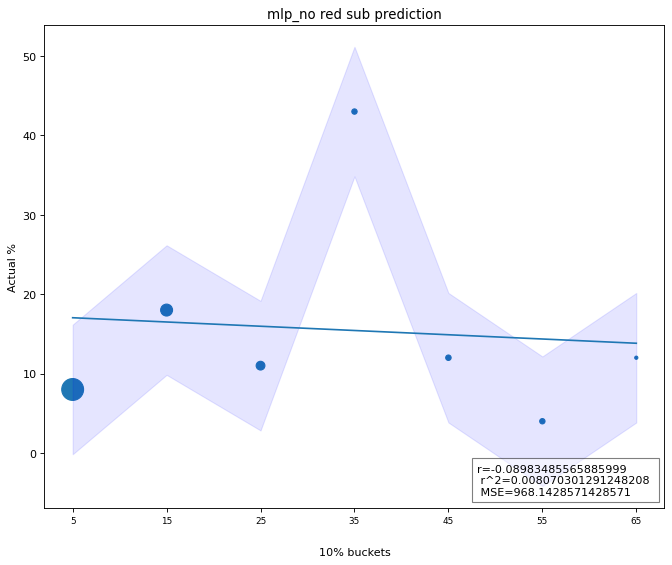

['mlp_rand']
mlp_rand
0% to 10%: 10% of 469 observations
10% to 20%: 11% of 97 observations
20% to 30%: 25% of 40 observations
30% to 40%: 18% of 17 observations
40% to 50%: 40% of 10 observations
50% to 60%: 22% of 9 observations
60% to 70%: 33% of 3 observations
70% to 80%: 0% of 3 observations
80% to 90%: 0% of 1 observations
90% to 100%: 50% of 2 observations


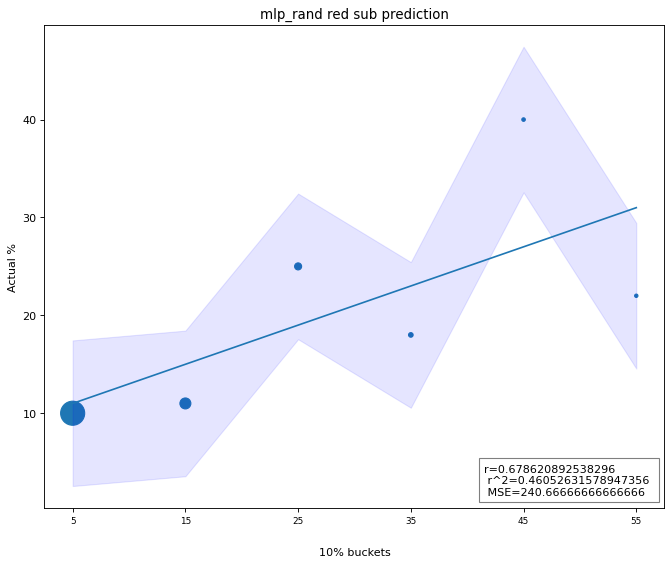

['mlp_up']
mlp_up
0% to 10%: 9% of 416 observations
10% to 20%: 17% of 103 observations
20% to 30%: 16% of 56 observations
30% to 40%: 15% of 26 observations
40% to 50%: 35% of 20 observations
50% to 60%: 20% of 10 observations
60% to 70%: 20% of 10 observations
70% to 80%: 20% of 5 observations
80% to 90%: 20% of 5 observations
90% to 100%: 0% of 0 observations


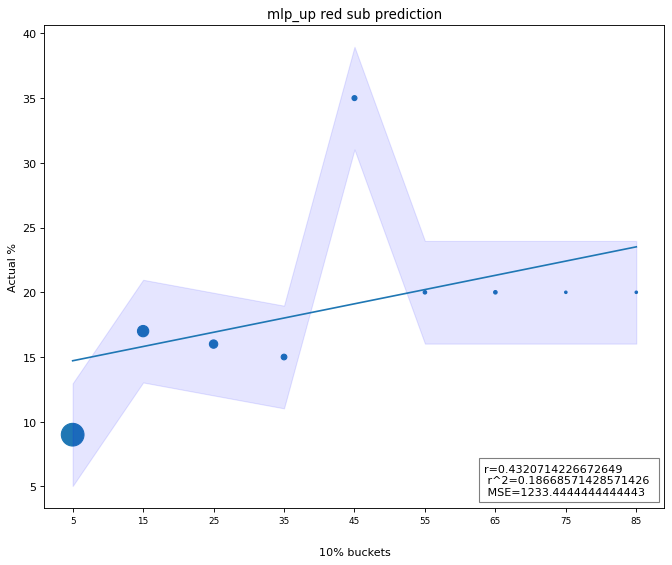

['nn_no']
nn_no
0% to 10%: 7% of 338 observations
10% to 20%: 17% of 180 observations
20% to 30%: 17% of 80 observations
30% to 40%: 17% of 30 observations
40% to 50%: 38% of 13 observations
50% to 60%: 0% of 5 observations
60% to 70%: 25% of 4 observations
70% to 80%: 100% of 2 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


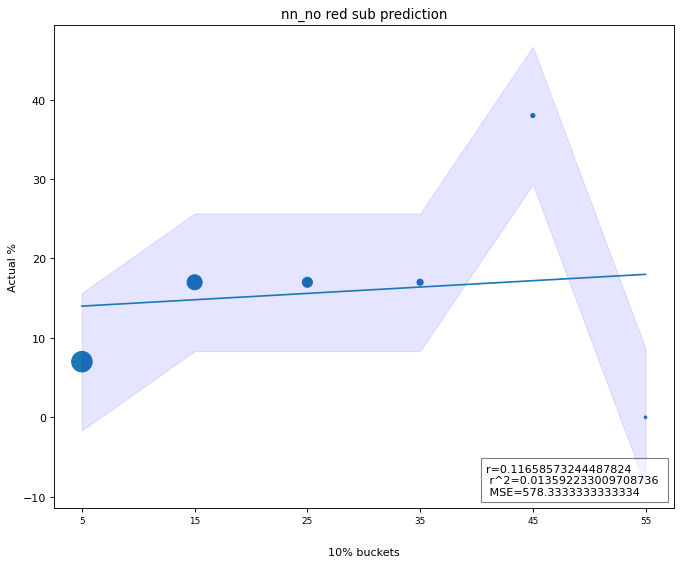

['nn_rand']
nn_rand
0% to 10%: 8% of 413 observations
10% to 20%: 14% of 161 observations
20% to 30%: 31% of 51 observations
30% to 40%: 20% of 15 observations
40% to 50%: 28% of 7 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 1 observations
70% to 80%: 33% of 3 observations
80% to 90%: 100% of 1 observations
90% to 100%: 0% of 0 observations


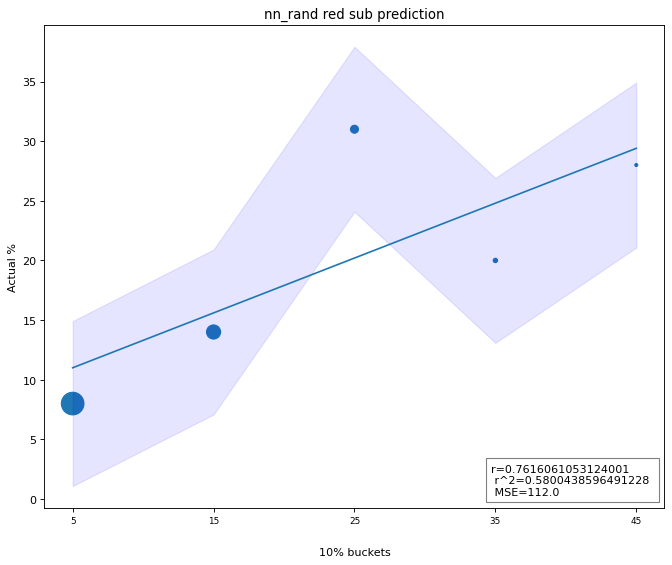

['nn_up']
nn_up
0% to 10%: 8% of 395 observations
10% to 20%: 19% of 153 observations
20% to 30%: 15% of 65 observations
30% to 40%: 22% of 18 observations
40% to 50%: 33% of 12 observations
50% to 60%: 33% of 3 observations
60% to 70%: 0% of 3 observations
70% to 80%: 33% of 3 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


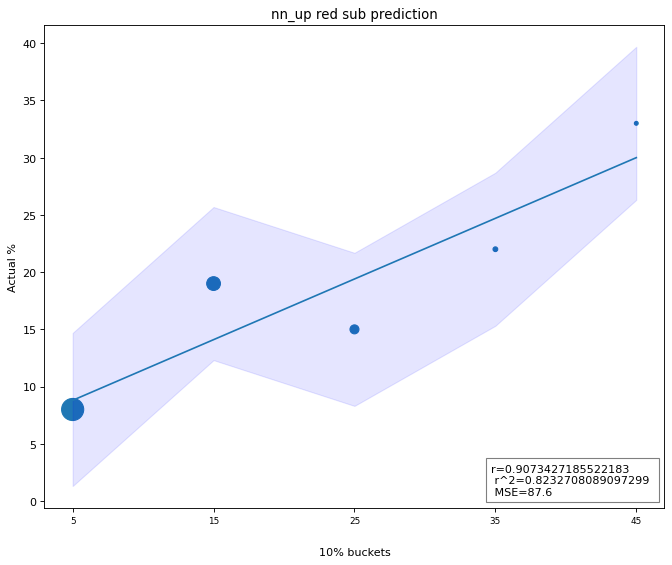

['mix_no']
mix_no
0% to 10%: 5% of 256 observations
10% to 20%: 13% of 268 observations
20% to 30%: 23% of 99 observations
30% to 40%: 26% of 19 observations
40% to 50%: 25% of 8 observations
50% to 60%: 0% of 2 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


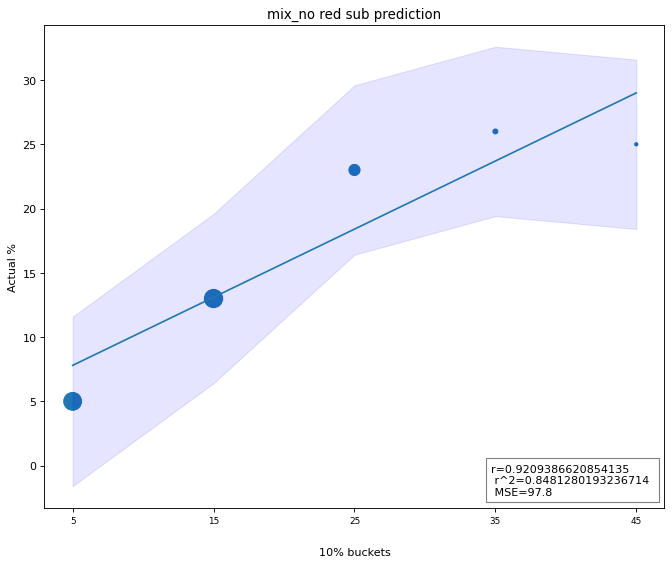

['mix_rand']
mix_rand
0% to 10%: 8% of 404 observations
10% to 20%: 16% of 196 observations
20% to 30%: 32% of 38 observations
30% to 40%: 38% of 8 observations
40% to 50%: 20% of 5 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 1 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


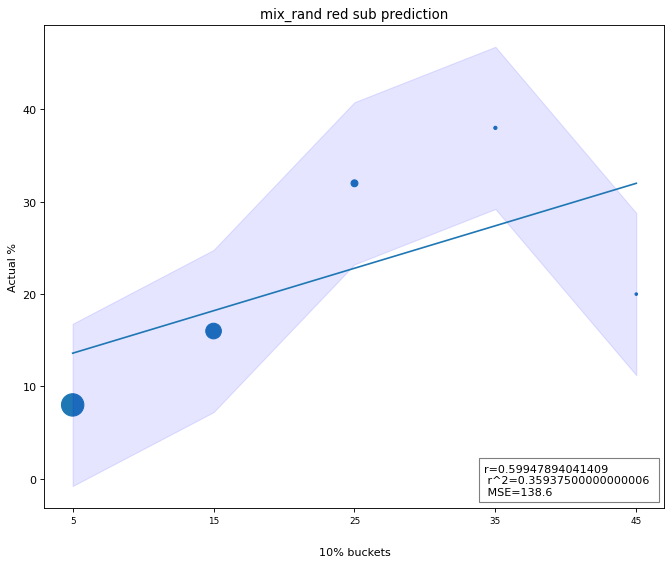

['mix_up']
mix_up
0% to 10%: 5% of 264 observations
10% to 20%: 14% of 307 observations
20% to 30%: 30% of 69 observations
30% to 40%: 17% of 6 observations
40% to 50%: 17% of 6 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


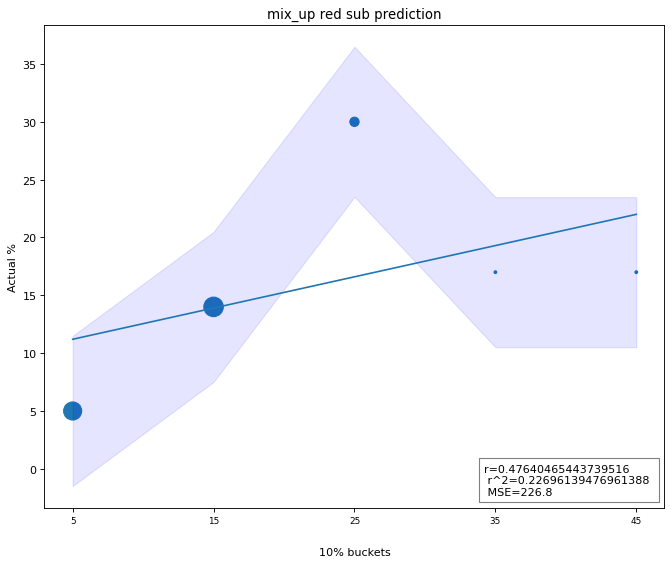

['combined']
combined
0% to 10%: 6% of 305 observations
10% to 20%: 14% of 266 observations
20% to 30%: 30% of 66 observations
30% to 40%: 25% of 8 observations
40% to 50%: 33% of 6 observations
50% to 60%: 0% of 1 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


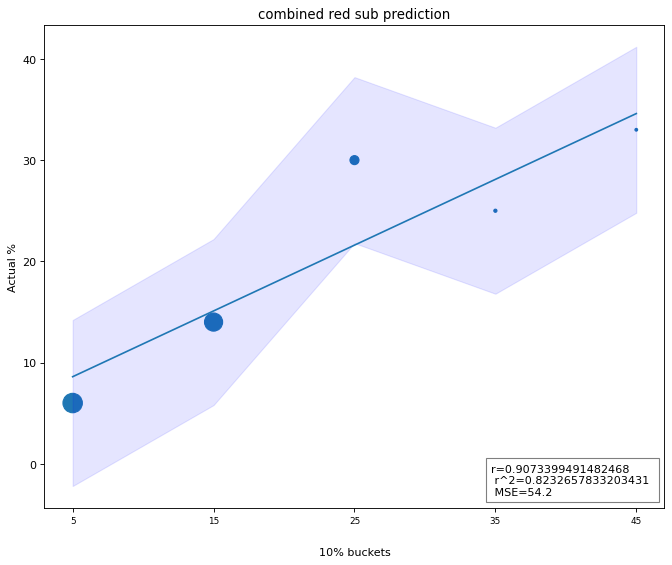

In [78]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["red_sub_pct"] >= x]
        point_to_point = point_up[point_up["red_sub_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Submission"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)

    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} red sub prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [79]:
red_sub_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_sub_df = pd.DataFrame(red_sub_dict)
red_sub_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.971894   0.944578     35.500000
1     knn_rand  0.427699   0.182927    120.500000
2       knn_up  0.930334   0.865522     38.750000
3       log_no  0.860222   0.739982    139.500000
4     log_rand  0.980253   0.960896     14.000000
5       log_up  0.771258   0.594839     86.800000
6        rf_no  0.901637   0.812949    102.500000
7      rf_rand  0.500000   0.250000     50.000000
8        rf_up  0.898513   0.807325     59.333333
9       mlp_no -0.089835   0.008070    968.142857
10    mlp_rand  0.678621   0.460526    240.666667
11      mlp_up  0.432071   0.186686   1233.444444
12       nn_no  0.116586   0.013592    578.333333
13     nn_rand  0.761606   0.580044    112.000000
14       nn_up  0.907343   0.823271     87.600000
15      mix_no  0.920939   0.848128     97.800000
16    mix_rand  0.599479   0.359375    138.600000
17      mix_up  0.476405   0.226961    226.800000
18    combined  0.907340   0.823266     54.200000

['knn_no']
knn_no
0% to 10%: 23% of 65 observations
10% to 20%: 17% of 296 observations
20% to 30%: 18% of 184 observations
30% to 40%: 28% of 76 observations
40% to 50%: 39% of 28 observations
50% to 60%: 0% of 3 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


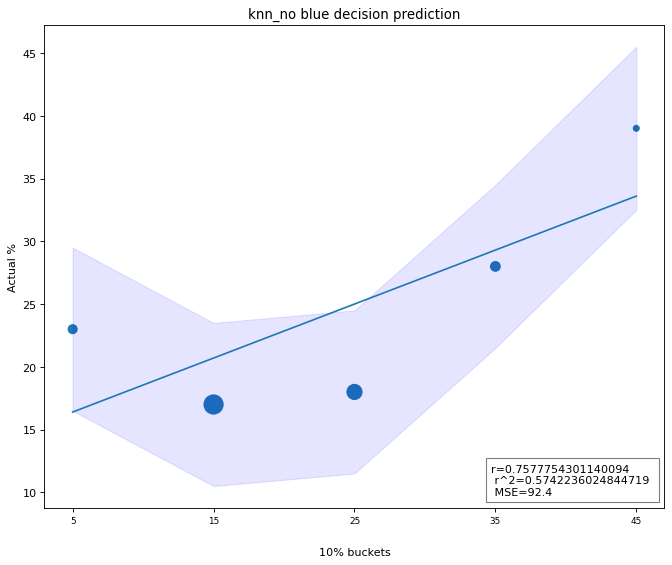

['knn_rand']
knn_rand
0% to 10%: 17% of 18 observations
10% to 20%: 18% of 197 observations
20% to 30%: 19% of 215 observations
30% to 40%: 20% of 160 observations
40% to 50%: 25% of 48 observations
50% to 60%: 33% of 12 observations
60% to 70%: 100% of 2 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


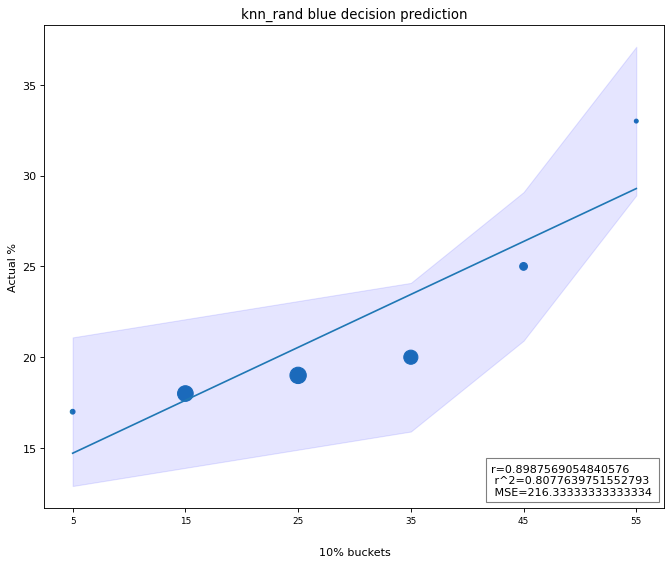

['knn_up']
knn_up
0% to 10%: 17% of 89 observations
10% to 20%: 15% of 123 observations
20% to 30%: 17% of 148 observations
30% to 40%: 17% of 126 observations
40% to 50%: 28% of 89 observations
50% to 60%: 34% of 50 observations
60% to 70%: 26% of 19 observations
70% to 80%: 25% of 8 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


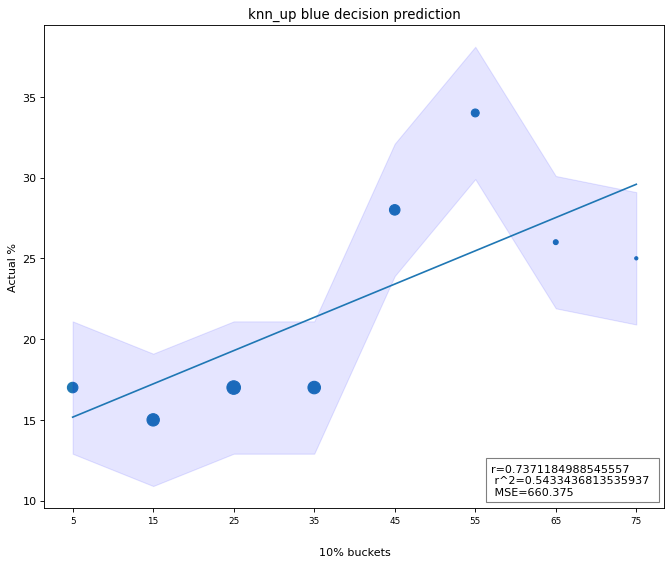

['log_no']
log_no
0% to 10%: 13% of 187 observations
10% to 20%: 20% of 244 observations
20% to 30%: 23% of 146 observations
30% to 40%: 22% of 41 observations
40% to 50%: 46% of 24 observations
50% to 60%: 25% of 4 observations
60% to 70%: 100% of 4 observations
70% to 80%: 0% of 2 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


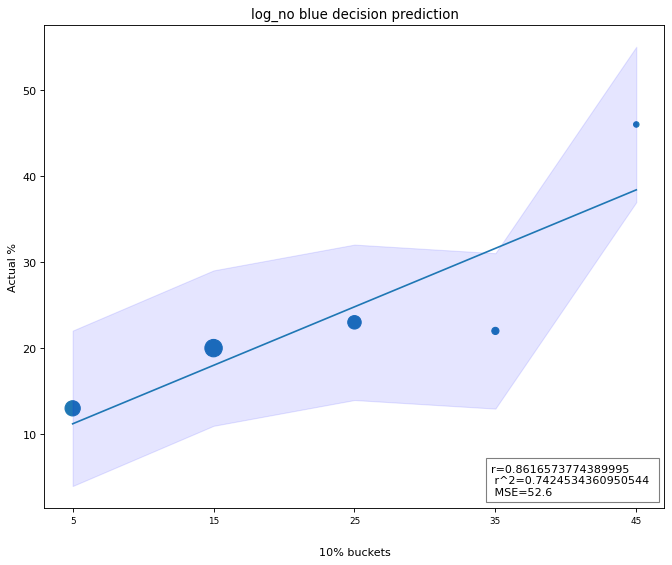

['log_rand']
log_rand
0% to 10%: 16% of 57 observations
10% to 20%: 13% of 209 observations
20% to 30%: 20% of 242 observations
30% to 40%: 24% of 90 observations
40% to 50%: 42% of 48 observations
50% to 60%: 0% of 2 observations
60% to 70%: 67% of 3 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


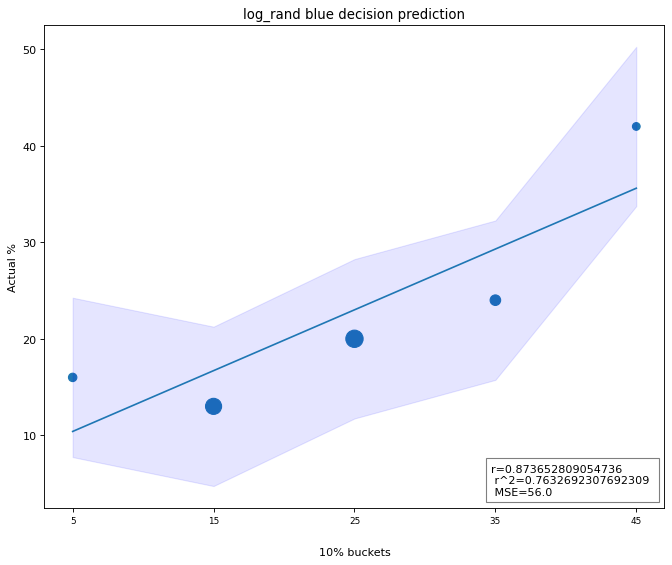

['log_up']
log_up
0% to 10%: 14% of 95 observations
10% to 20%: 16% of 185 observations
20% to 30%: 18% of 188 observations
30% to 40%: 32% of 88 observations
40% to 50%: 16% of 55 observations
50% to 60%: 35% of 26 observations
60% to 70%: 56% of 9 observations
70% to 80%: 100% of 3 observations
80% to 90%: 0% of 2 observations
90% to 100%: 0% of 0 observations


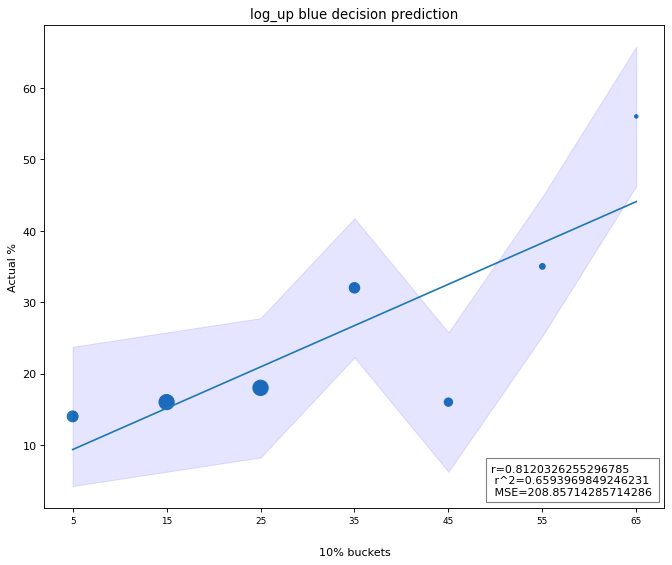

['rf_no']
rf_no
0% to 10%: 28% of 7 observations
10% to 20%: 18% of 290 observations
20% to 30%: 21% of 343 observations
30% to 40%: 33% of 12 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


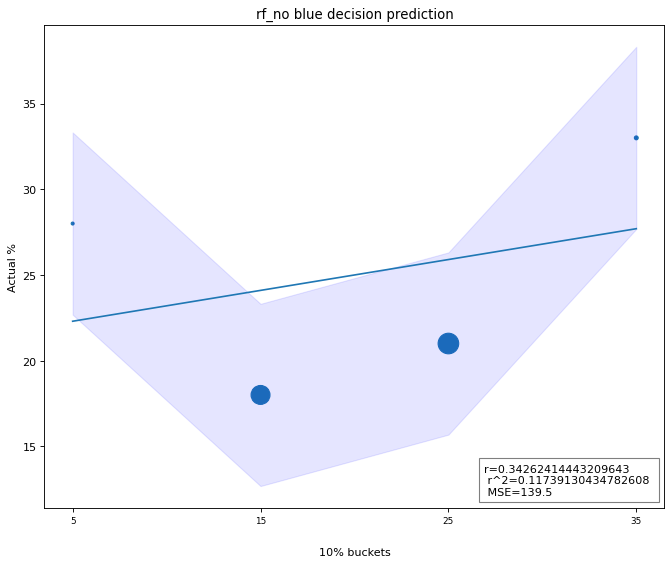

['rf_rand']
rf_rand
0% to 10%: 40% of 5 observations
10% to 20%: 22% of 192 observations
20% to 30%: 19% of 402 observations
30% to 40%: 15% of 48 observations
40% to 50%: 20% of 5 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


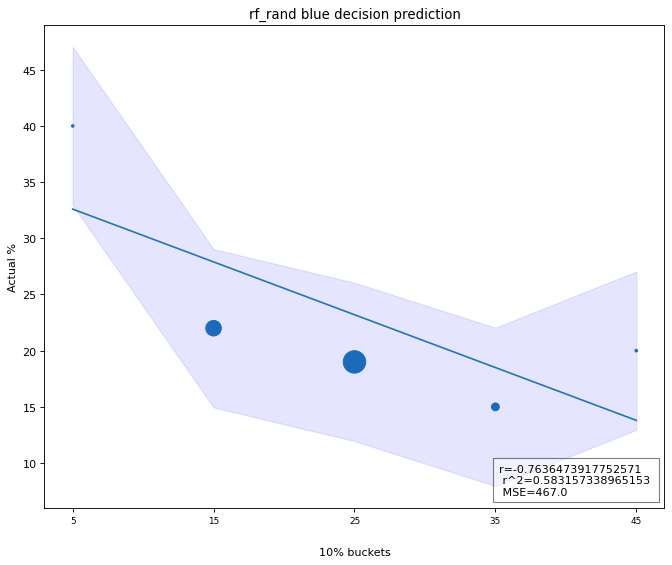

['rf_up']
rf_up
0% to 10%: 50% of 2 observations
10% to 20%: 18% of 248 observations
20% to 30%: 21% of 383 observations
30% to 40%: 21% of 19 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


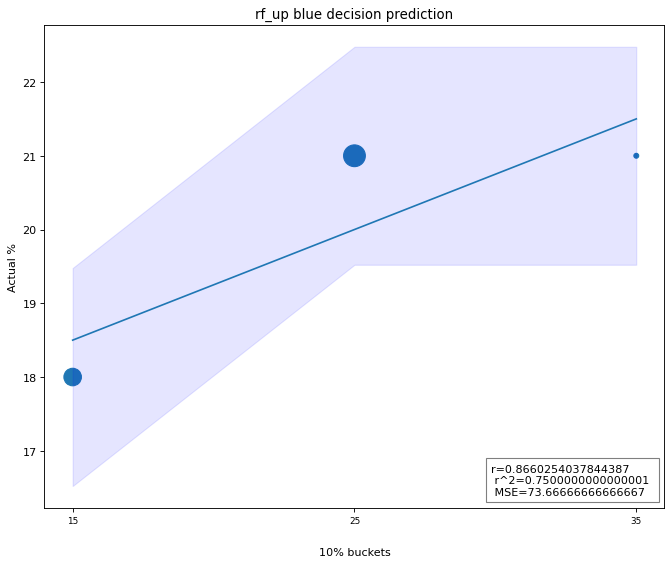

['mlp_no']
mlp_no
0% to 10%: 14% of 288 observations
10% to 20%: 17% of 139 observations
20% to 30%: 23% of 95 observations
30% to 40%: 33% of 40 observations
40% to 50%: 30% of 33 observations
50% to 60%: 28% of 29 observations
60% to 70%: 54% of 13 observations
70% to 80%: 38% of 8 observations
80% to 90%: 33% of 3 observations
90% to 100%: 100% of 1 observations


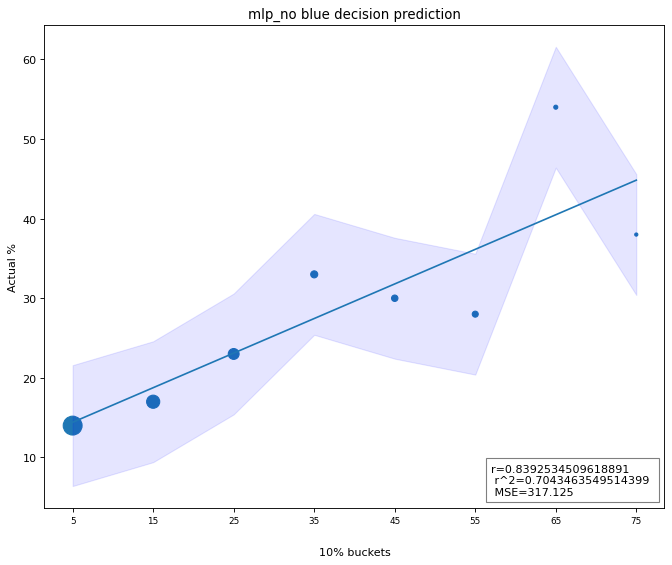

['mlp_rand']
mlp_rand
0% to 10%: 15% of 207 observations
10% to 20%: 20% of 145 observations
20% to 30%: 18% of 121 observations
30% to 40%: 18% of 56 observations
40% to 50%: 26% of 50 observations
50% to 60%: 35% of 31 observations
60% to 70%: 30% of 20 observations
70% to 80%: 38% of 16 observations
80% to 90%: 50% of 4 observations
90% to 100%: 0% of 0 observations


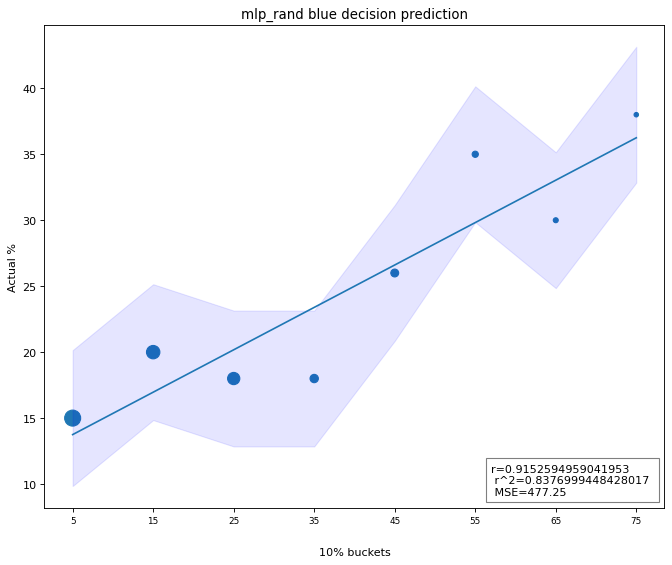

['mlp_up']
mlp_up
0% to 10%: 18% of 316 observations
10% to 20%: 21% of 89 observations
20% to 30%: 17% of 80 observations
30% to 40%: 14% of 42 observations
40% to 50%: 16% of 32 observations
50% to 60%: 28% of 25 observations
60% to 70%: 35% of 20 observations
70% to 80%: 8% of 12 observations
80% to 90%: 39% of 18 observations
90% to 100%: 46% of 13 observations


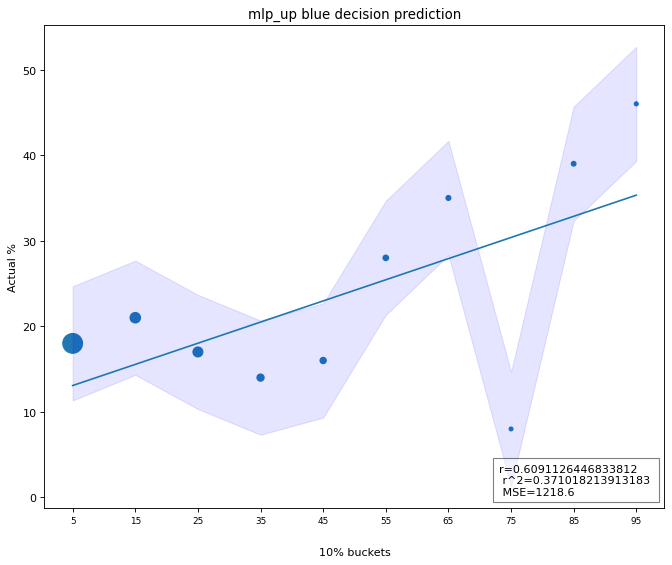

['nn_no']
nn_no
0% to 10%: 14% of 238 observations
10% to 20%: 19% of 210 observations
20% to 30%: 18% of 110 observations
30% to 40%: 39% of 51 observations
40% to 50%: 32% of 28 observations
50% to 60%: 43% of 7 observations
60% to 70%: 67% of 6 observations
70% to 80%: 0% of 1 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


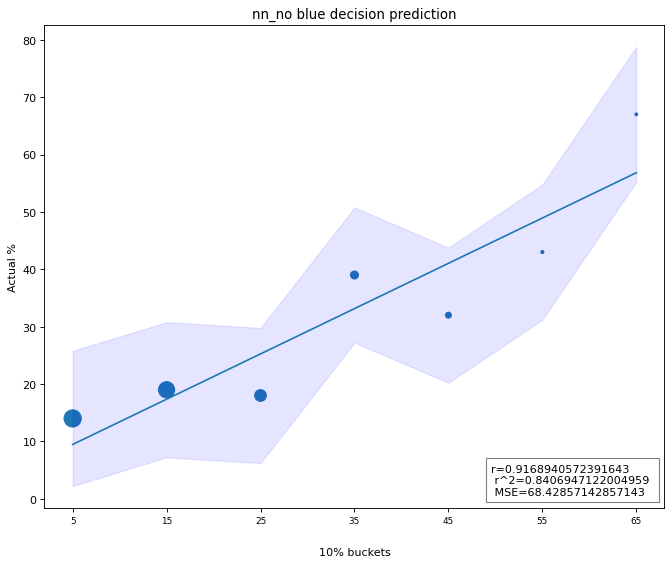

['nn_rand']
nn_rand
0% to 10%: 14% of 84 observations
10% to 20%: 15% of 218 observations
20% to 30%: 19% of 201 observations
30% to 40%: 23% of 86 observations
40% to 50%: 39% of 46 observations
50% to 60%: 50% of 12 observations
60% to 70%: 33% of 3 observations
70% to 80%: 100% of 1 observations
80% to 90%: 100% of 1 observations
90% to 100%: 0% of 0 observations


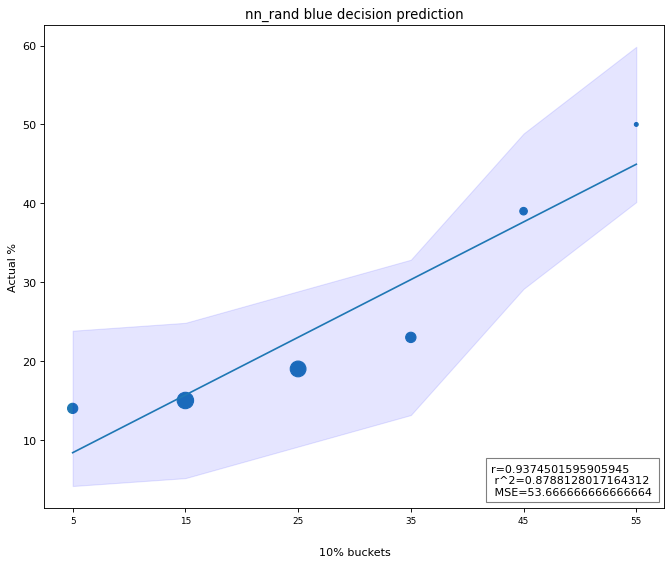

['nn_up']
nn_up
0% to 10%: 16% of 218 observations
10% to 20%: 17% of 157 observations
20% to 30%: 23% of 112 observations
30% to 40%: 25% of 61 observations
40% to 50%: 24% of 37 observations
50% to 60%: 24% of 29 observations
60% to 70%: 21% of 19 observations
70% to 80%: 38% of 8 observations
80% to 90%: 43% of 7 observations
90% to 100%: 50% of 4 observations


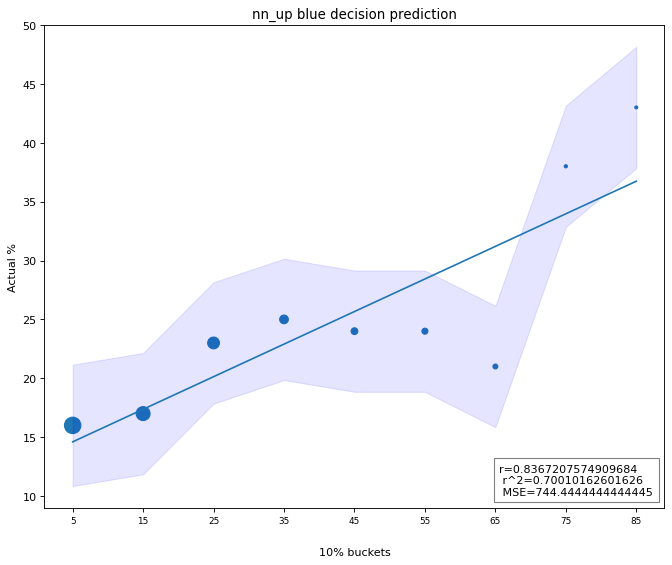

['mix_no']
mix_no
0% to 10%: 14% of 97 observations
10% to 20%: 16% of 322 observations
20% to 30%: 25% of 177 observations
30% to 40%: 30% of 44 observations
40% to 50%: 50% of 8 observations
50% to 60%: 50% of 4 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


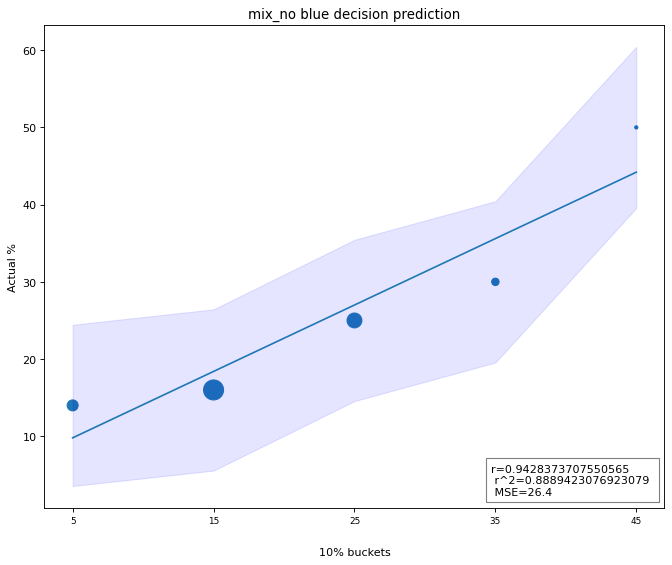

['mix_rand']
mix_rand
0% to 10%: 5% of 19 observations
10% to 20%: 14% of 229 observations
20% to 30%: 18% of 258 observations
30% to 40%: 32% of 116 observations
40% to 50%: 37% of 27 observations
50% to 60%: 50% of 2 observations
60% to 70%: 100% of 1 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


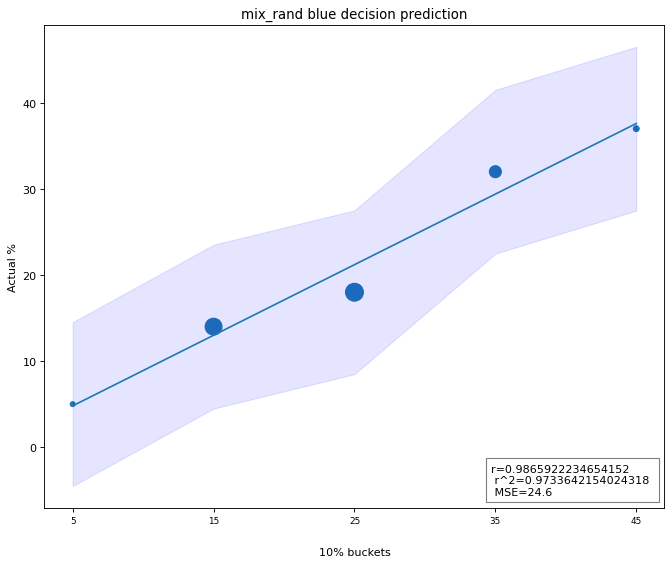

['mix_up']
mix_up
0% to 10%: 25% of 53 observations
10% to 20%: 14% of 286 observations
20% to 30%: 21% of 216 observations
30% to 40%: 28% of 74 observations
40% to 50%: 43% of 21 observations
50% to 60%: 100% of 2 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


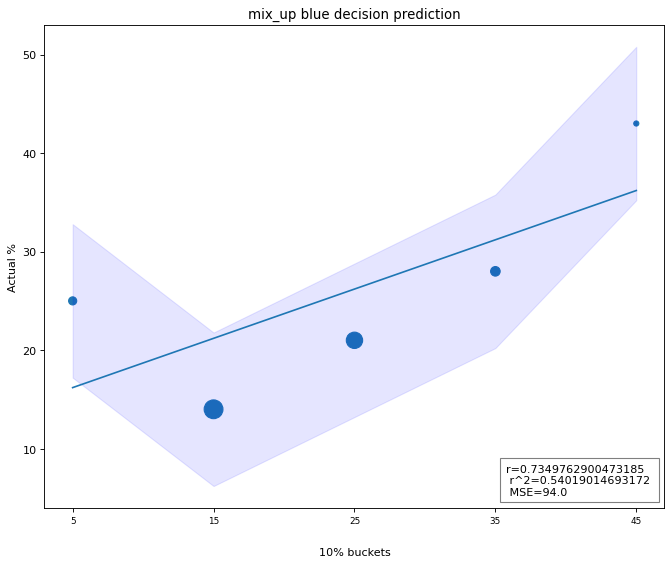

['combined']
combined
0% to 10%: 16% of 25 observations
10% to 20%: 14% of 275 observations
20% to 30%: 21% of 256 observations
30% to 40%: 34% of 74 observations
40% to 50%: 42% of 19 observations
50% to 60%: 67% of 3 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


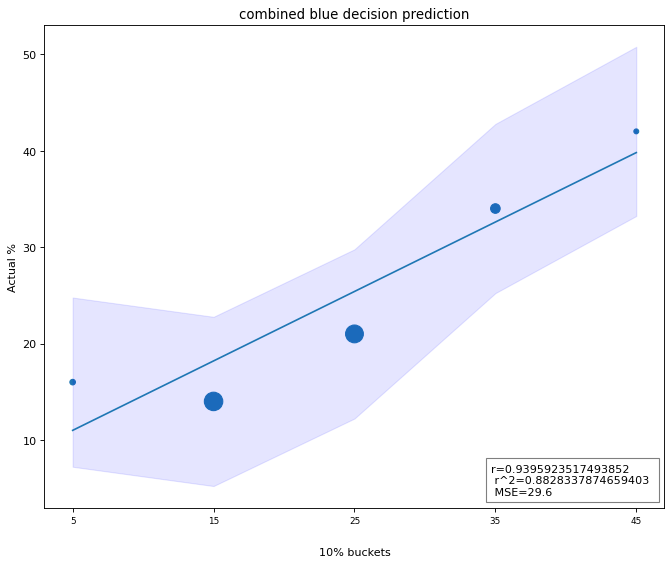

In [80]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["blue_dec_pct"] >= x]
        point_to_point = point_up[point_up["blue_dec_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Decision"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)

    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} blue decision prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [81]:
blue_dec_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_dec_df = pd.DataFrame(blue_dec_dict)
blue_dec_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.757775   0.574224     92.400000
1     knn_rand  0.898757   0.807764    216.333333
2       knn_up  0.737118   0.543344    660.375000
3       log_no  0.861657   0.742453     52.600000
4     log_rand  0.873653   0.763269     56.000000
5       log_up  0.812033   0.659397    208.857143
6        rf_no  0.342624   0.117391    139.500000
7      rf_rand -0.763647   0.583157    467.000000
8        rf_up  0.866025   0.750000     73.666667
9       mlp_no  0.839253   0.704346    317.125000
10    mlp_rand  0.915259   0.837700    477.250000
11      mlp_up  0.609113   0.371018   1218.600000
12       nn_no  0.916894   0.840695     68.428571
13     nn_rand  0.937450   0.878813     53.666667
14       nn_up  0.836721   0.700102    744.444444
15      mix_no  0.942837   0.888942     26.400000
16    mix_rand  0.986592   0.973364     24.600000
17      mix_up  0.734976   0.540190     94.000000
18    combined  0.939592   0.882834     29.600000

['knn_no']
knn_no
0% to 10%: 7% of 170 observations
10% to 20%: 14% of 388 observations
20% to 30%: 30% of 81 observations
30% to 40%: 15% of 13 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


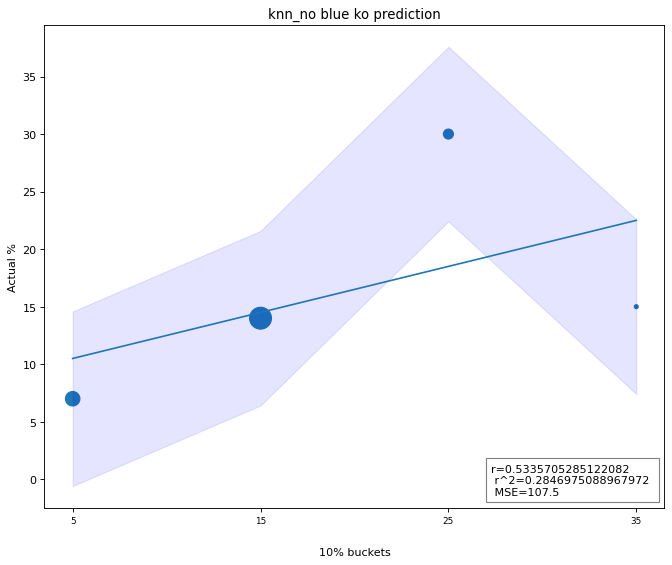

['knn_rand']
knn_rand
0% to 10%: 8% of 129 observations
10% to 20%: 14% of 361 observations
20% to 30%: 21% of 131 observations
30% to 40%: 19% of 26 observations
40% to 50%: 50% of 4 observations
50% to 60%: 0% of 1 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


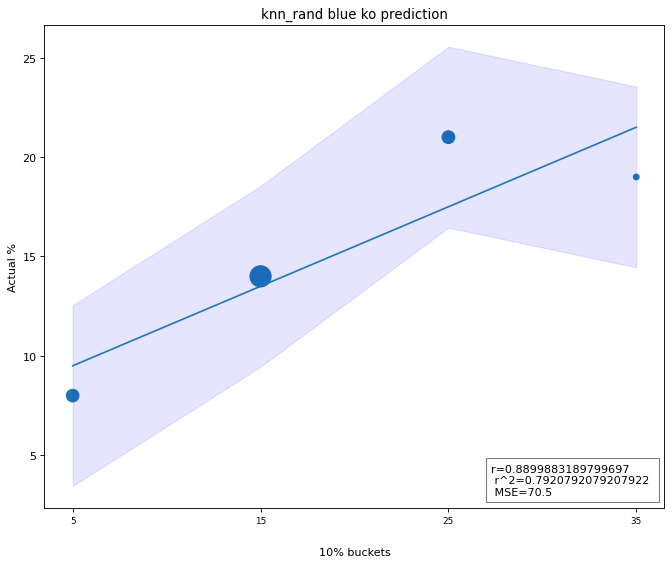

['knn_up']
knn_up
0% to 10%: 9% of 196 observations
10% to 20%: 8% of 168 observations
20% to 30%: 19% of 148 observations
30% to 40%: 20% of 79 observations
40% to 50%: 24% of 42 observations
50% to 60%: 35% of 17 observations
60% to 70%: 100% of 2 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


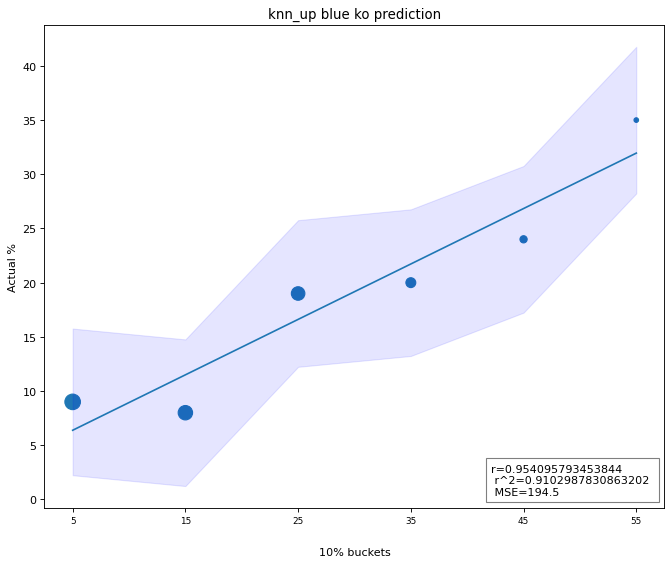

['log_no']
log_no
0% to 10%: 9% of 323 observations
10% to 20%: 17% of 209 observations
20% to 30%: 24% of 90 observations
30% to 40%: 19% of 16 observations
40% to 50%: 17% of 6 observations
50% to 60%: 43% of 7 observations
60% to 70%: 0% of 1 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


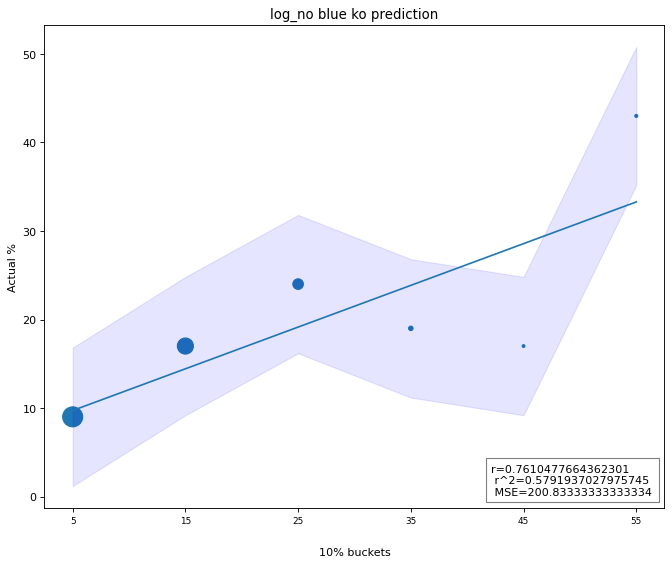

['log_rand']
log_rand
0% to 10%: 4% of 179 observations
10% to 20%: 15% of 270 observations
20% to 30%: 17% of 129 observations
30% to 40%: 33% of 42 observations
40% to 50%: 25% of 24 observations
50% to 60%: 40% of 5 observations
60% to 70%: 0% of 0 observations
70% to 80%: 100% of 1 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


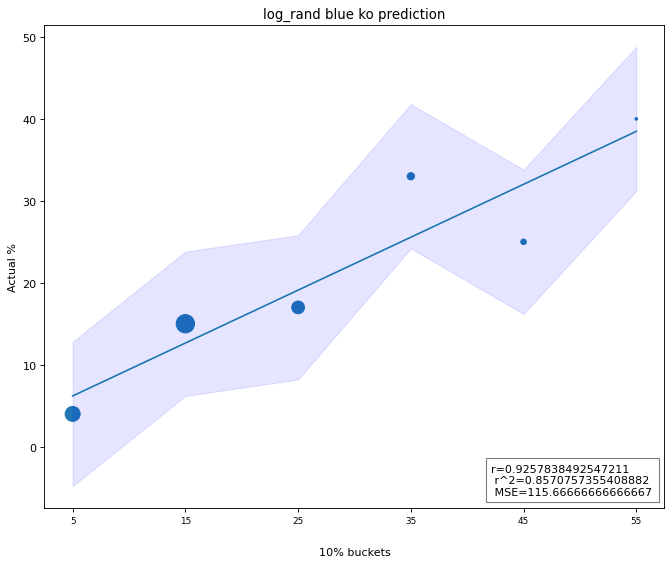

['log_up']
log_up
0% to 10%: 7% of 229 observations
10% to 20%: 18% of 200 observations
20% to 30%: 14% of 127 observations
30% to 40%: 23% of 60 observations
40% to 50%: 25% of 16 observations
50% to 60%: 18% of 11 observations
60% to 70%: 17% of 6 observations
70% to 80%: 100% of 2 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


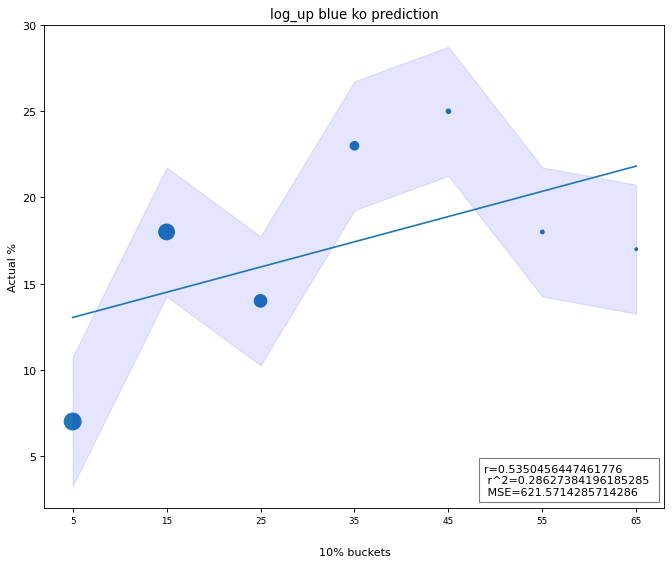

['rf_no']
rf_no
0% to 10%: 14% of 454 observations
10% to 20%: 14% of 197 observations
20% to 30%: 0% of 0 observations
30% to 40%: 0% of 1 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


C:\Users\audri\anaconda3\envs\stats\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\audri\anaconda3\envs\stats\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


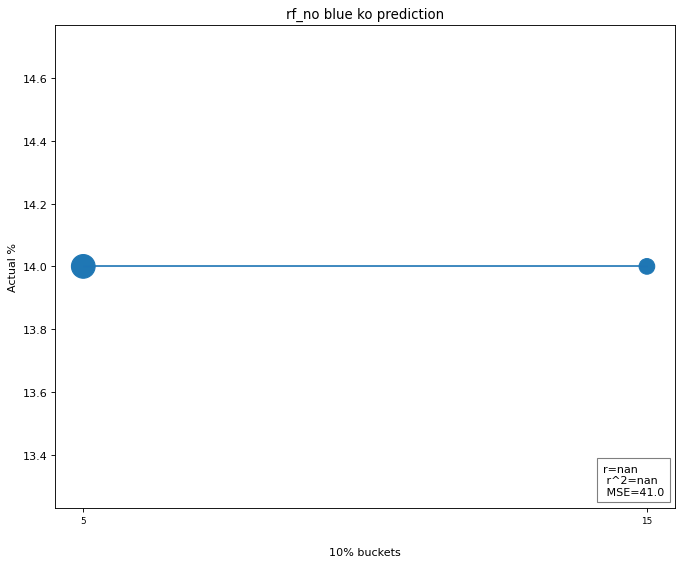

['rf_rand']
rf_rand
0% to 10%: 10% of 177 observations
10% to 20%: 17% of 448 observations
20% to 30%: 8% of 26 observations
30% to 40%: 0% of 1 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


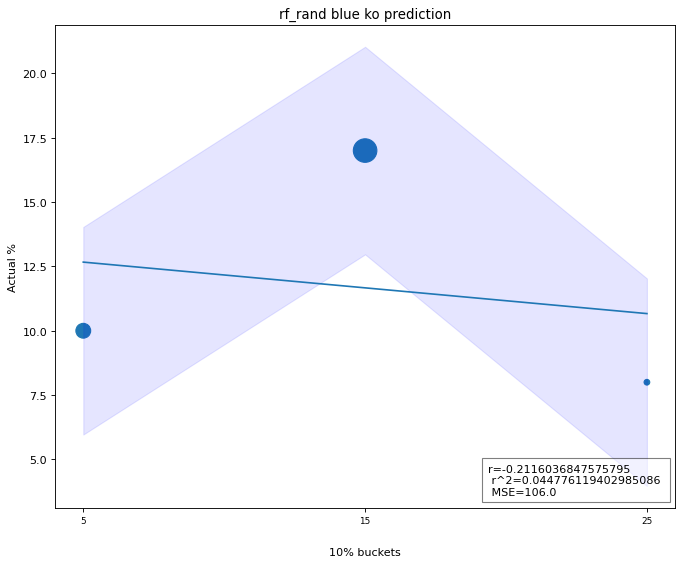

['rf_up']
rf_up
0% to 10%: 13% of 344 observations
10% to 20%: 15% of 298 observations
20% to 30%: 30% of 10 observations
30% to 40%: 0% of 0 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


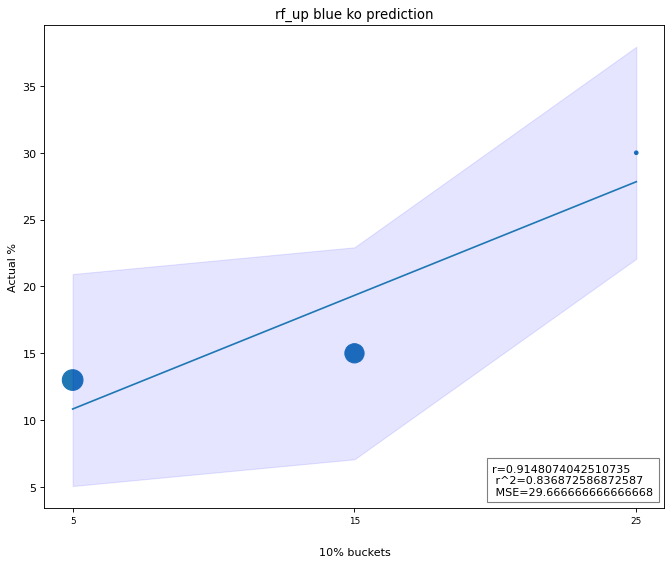

['mlp_no']
mlp_no
0% to 10%: 12% of 401 observations
10% to 20%: 19% of 119 observations
20% to 30%: 11% of 70 observations
30% to 40%: 13% of 23 observations
40% to 50%: 32% of 22 observations
50% to 60%: 12% of 8 observations
60% to 70%: 40% of 5 observations
70% to 80%: 0% of 0 observations
80% to 90%: 33% of 3 observations
90% to 100%: 0% of 0 observations


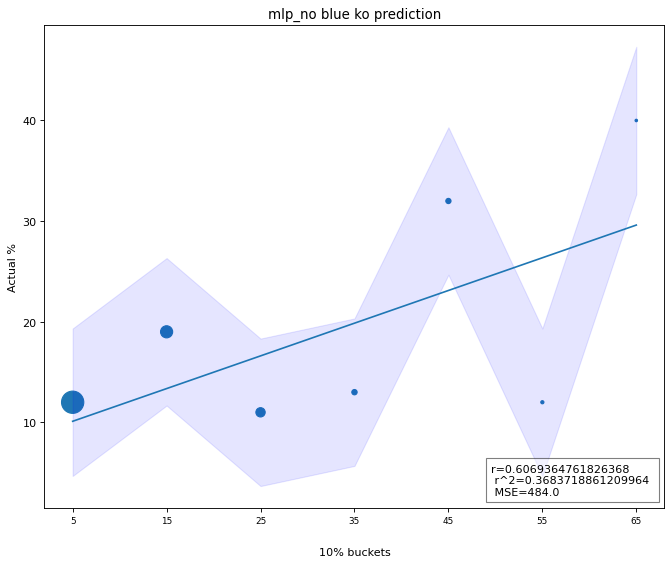

['mlp_rand']
mlp_rand
0% to 10%: 7% of 298 observations
10% to 20%: 13% of 141 observations
20% to 30%: 24% of 94 observations
30% to 40%: 18% of 50 observations
40% to 50%: 39% of 23 observations
50% to 60%: 14% of 14 observations
60% to 70%: 28% of 18 observations
70% to 80%: 28% of 7 observations
80% to 90%: 33% of 6 observations
90% to 100%: 0% of 0 observations


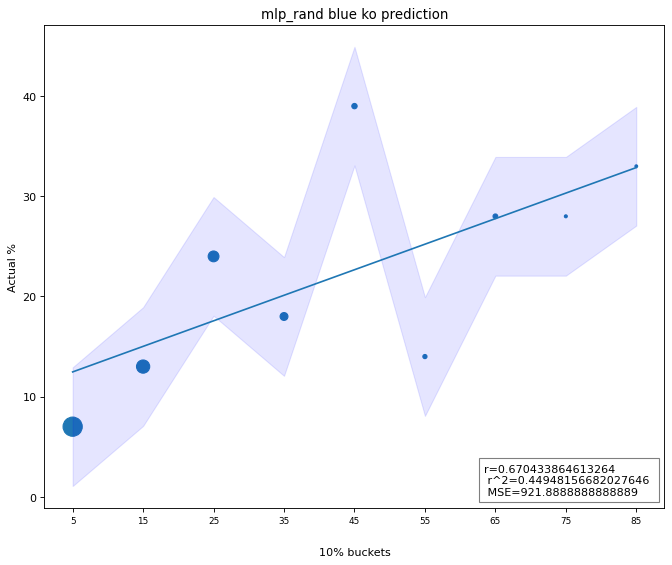

['mlp_up']
mlp_up
0% to 10%: 12% of 420 observations
10% to 20%: 19% of 75 observations
20% to 30%: 14% of 58 observations
30% to 40%: 27% of 30 observations
40% to 50%: 28% of 21 observations
50% to 60%: 12% of 16 observations
60% to 70%: 8% of 12 observations
70% to 80%: 17% of 6 observations
80% to 90%: 12% of 8 observations
90% to 100%: 25% of 4 observations


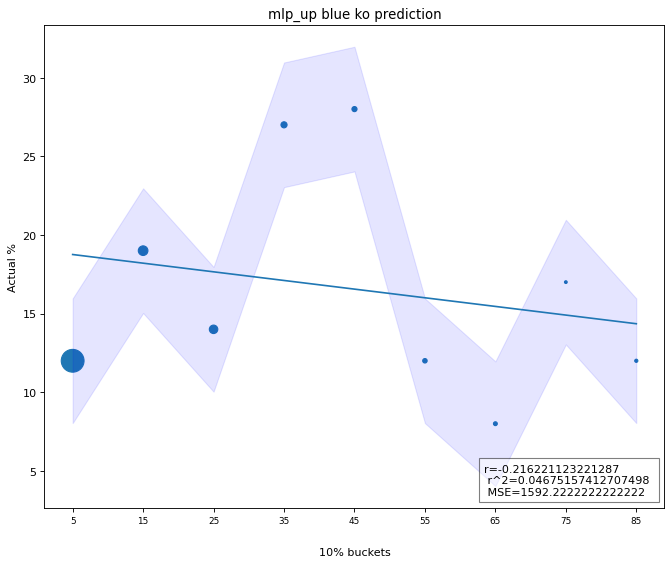

['nn_no']
nn_no
0% to 10%: 8% of 328 observations
10% to 20%: 17% of 200 observations
20% to 30%: 26% of 86 observations
30% to 40%: 39% of 23 observations
40% to 50%: 25% of 8 observations
50% to 60%: 20% of 5 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


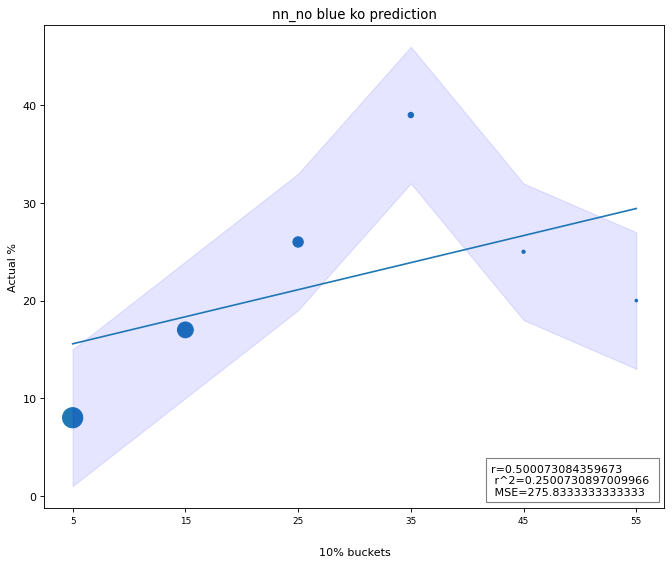

['nn_rand']
nn_rand
0% to 10%: 6% of 218 observations
10% to 20%: 11% of 210 observations
20% to 30%: 22% of 134 observations
30% to 40%: 22% of 45 observations
40% to 50%: 38% of 29 observations
50% to 60%: 45% of 11 observations
60% to 70%: 100% of 2 observations
70% to 80%: 0% of 1 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


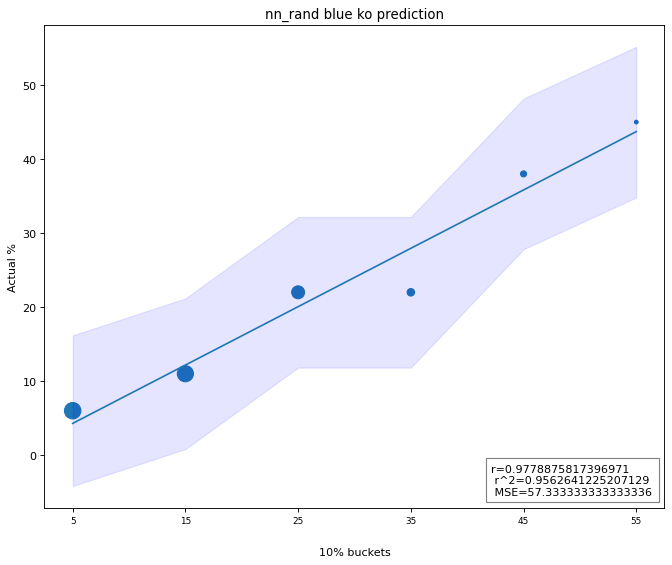

['nn_up']
nn_up
0% to 10%: 10% of 340 observations
10% to 20%: 16% of 122 observations
20% to 30%: 17% of 83 observations
30% to 40%: 25% of 40 observations
40% to 50%: 13% of 30 observations
50% to 60%: 40% of 20 observations
60% to 70%: 11% of 9 observations
70% to 80%: 20% of 5 observations
80% to 90%: 0% of 2 observations
90% to 100%: 0% of 0 observations


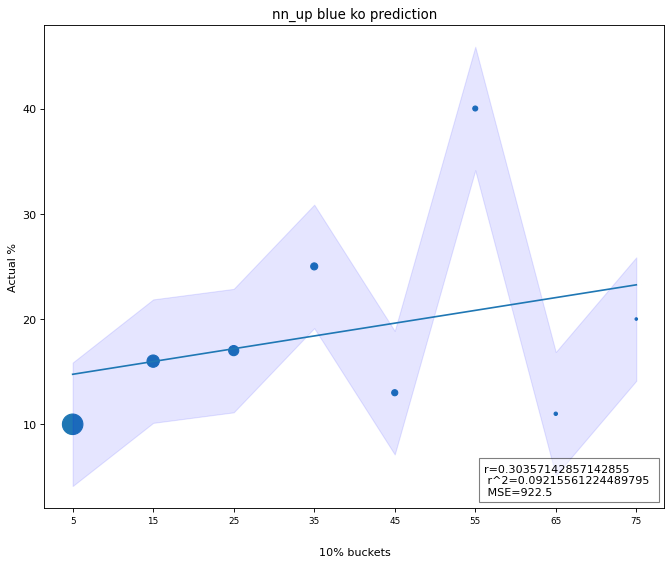

['mix_no']
mix_no
0% to 10%: 7% of 252 observations
10% to 20%: 17% of 309 observations
20% to 30%: 21% of 77 observations
30% to 40%: 50% of 12 observations
40% to 50%: 0% of 2 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


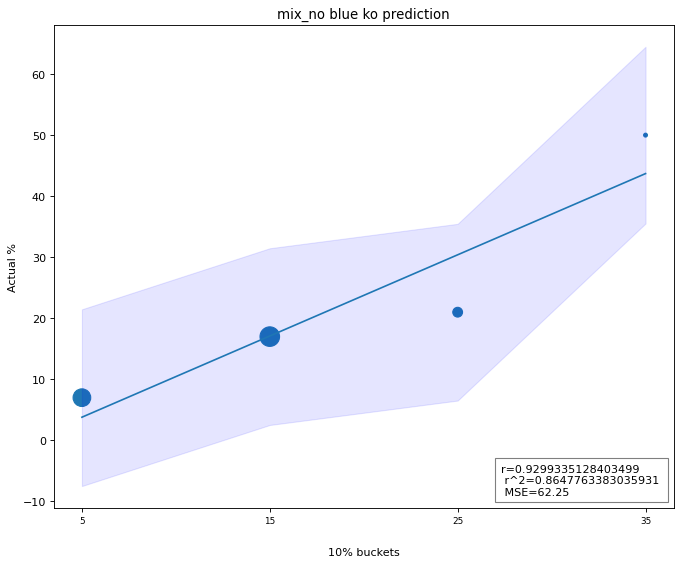

['mix_rand']
mix_rand
0% to 10%: 4% of 138 observations
10% to 20%: 12% of 317 observations
20% to 30%: 24% of 136 observations
30% to 40%: 28% of 56 observations
40% to 50%: 25% of 4 observations
50% to 60%: 100% of 1 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


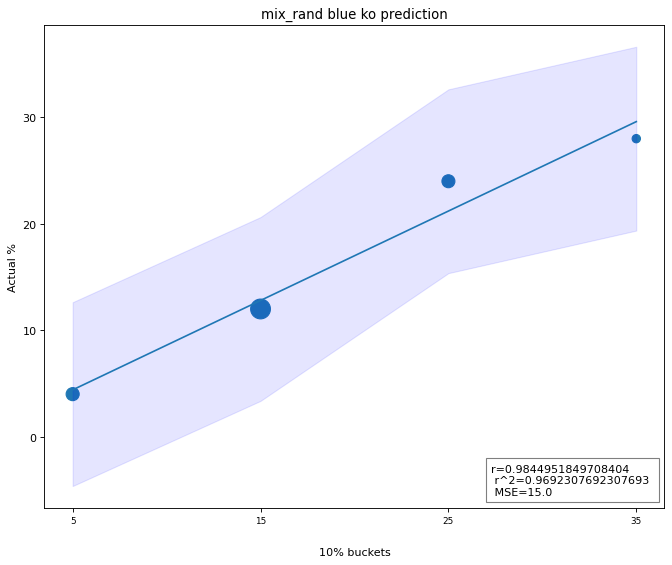

['mix_up']
mix_up
0% to 10%: 5% of 179 observations
10% to 20%: 14% of 318 observations
20% to 30%: 23% of 128 observations
30% to 40%: 33% of 24 observations
40% to 50%: 33% of 3 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


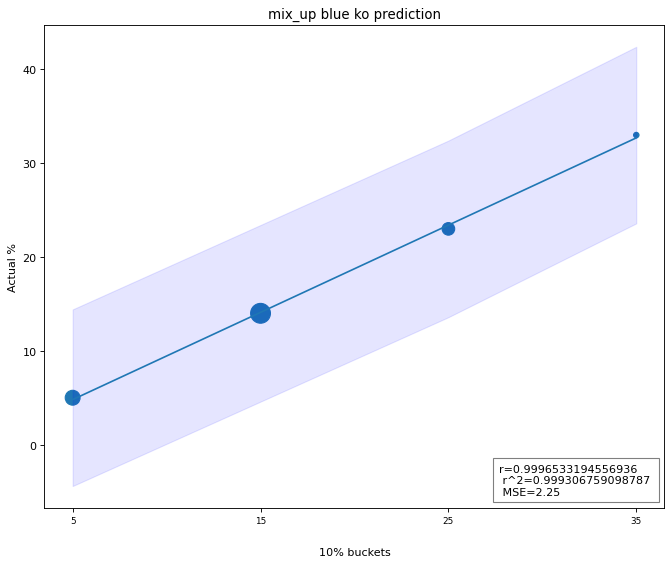

['combined']
combined
0% to 10%: 4% of 196 observations
10% to 20%: 15% of 330 observations
20% to 30%: 28% of 108 observations
30% to 40%: 40% of 15 observations
40% to 50%: 33% of 3 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


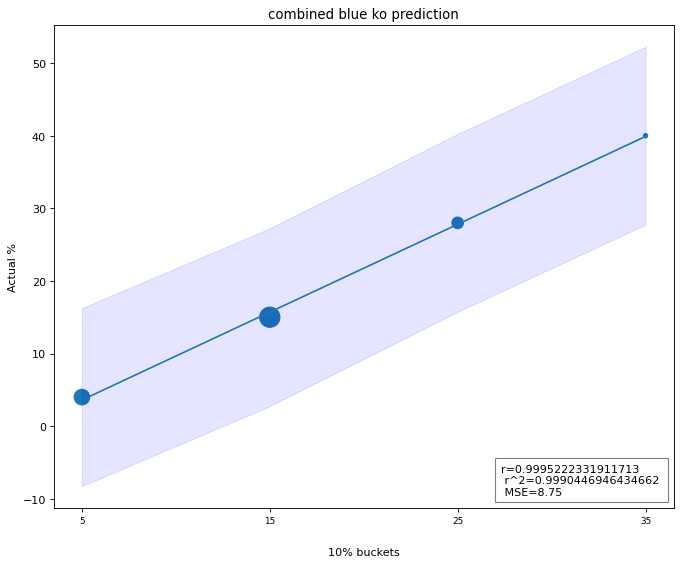

In [82]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["blue_ko_pct"] >= x]
        point_to_point = point_up[point_up["blue_ko_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - KO/TKO"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
 
    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} blue ko prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [83]:
blue_ko_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_ko_df = pd.DataFrame(blue_ko_dict)
blue_ko_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.533571   0.284698    107.500000
1     knn_rand  0.889988   0.792079     70.500000
2       knn_up  0.954096   0.910299    194.500000
3       log_no  0.761048   0.579194    200.833333
4     log_rand  0.925784   0.857076    115.666667
5       log_up  0.535046   0.286274    621.571429
6        rf_no       NaN        NaN     41.000000
7      rf_rand -0.211604   0.044776    106.000000
8        rf_up  0.914807   0.836873     29.666667
9       mlp_no  0.606936   0.368372    484.000000
10    mlp_rand  0.670434   0.449482    921.888889
11      mlp_up -0.216221   0.046752   1592.222222
12       nn_no  0.500073   0.250073    275.833333
13     nn_rand  0.977888   0.956264     57.333333
14       nn_up  0.303571   0.092156    922.500000
15      mix_no  0.929934   0.864776     62.250000
16    mix_rand  0.984495   0.969231     15.000000
17      mix_up  0.999653   0.999307      2.250000
18    combined  0.999522   0.999045      8.750000

['knn_no']
knn_no
0% to 10%: 7% of 420 observations
10% to 20%: 11% of 227 observations
20% to 30%: 0% of 5 observations
30% to 40%: 0% of 0 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


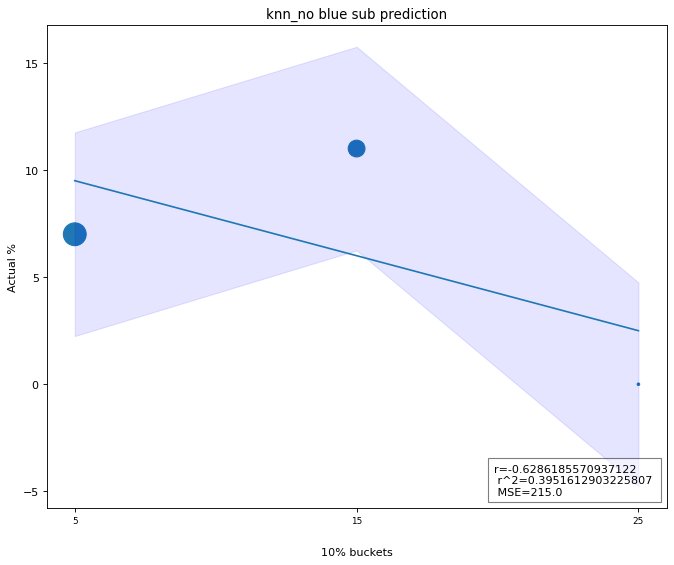

['knn_rand']
knn_rand
0% to 10%: 8% of 325 observations
10% to 20%: 8% of 295 observations
20% to 30%: 13% of 30 observations
30% to 40%: 0% of 2 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


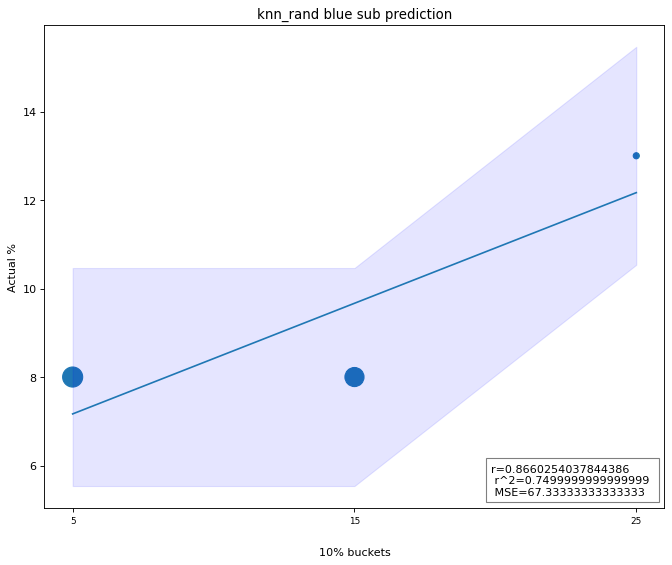

['knn_up']
knn_up
0% to 10%: 6% of 393 observations
10% to 20%: 10% of 154 observations
20% to 30%: 12% of 74 observations
30% to 40%: 18% of 22 observations
40% to 50%: 28% of 7 observations
50% to 60%: 0% of 2 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


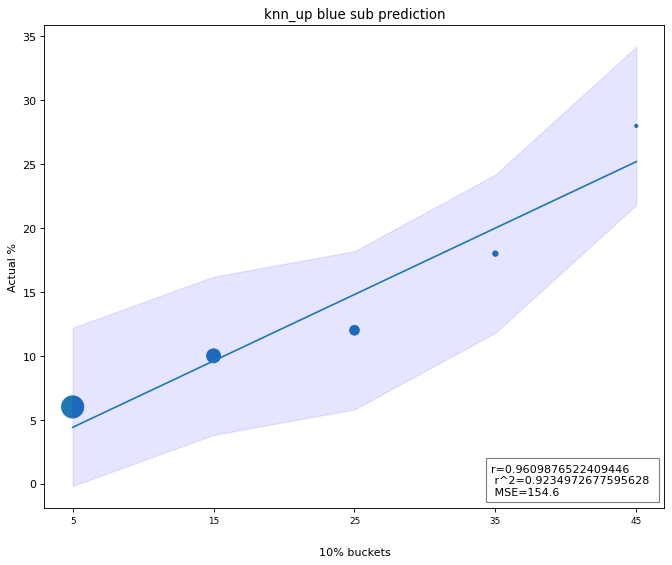

['log_no']
log_no
0% to 10%: 6% of 531 observations
10% to 20%: 18% of 101 observations
20% to 30%: 31% of 13 observations
30% to 40%: 0% of 3 observations
40% to 50%: 0% of 1 observations
50% to 60%: 33% of 3 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


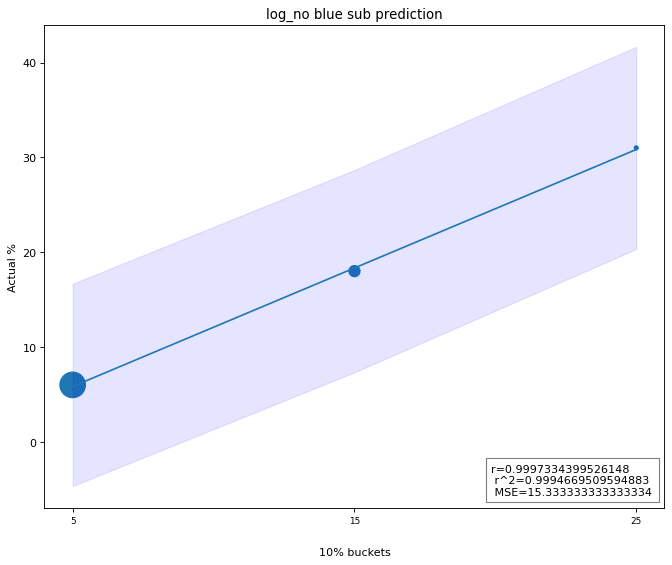

['log_rand']
log_rand
0% to 10%: 6% of 412 observations
10% to 20%: 10% of 172 observations
20% to 30%: 17% of 48 observations
30% to 40%: 21% of 14 observations
40% to 50%: 50% of 4 observations
50% to 60%: 50% of 2 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


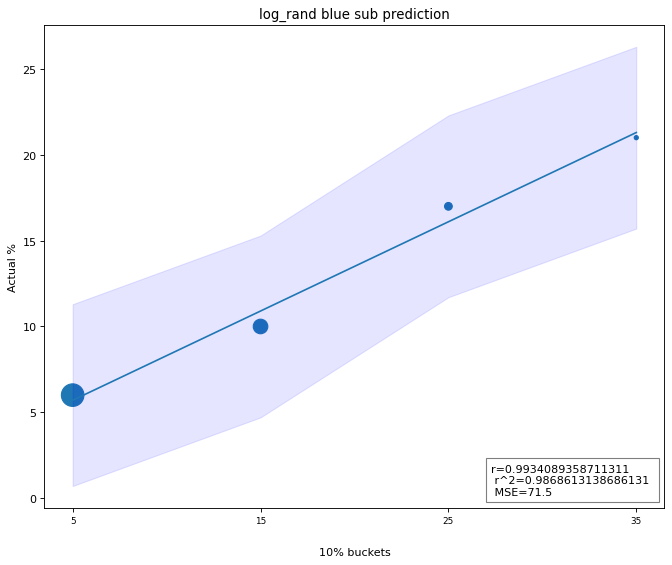

['log_up']
log_up
0% to 10%: 6% of 434 observations
10% to 20%: 12% of 155 observations
20% to 30%: 26% of 43 observations
30% to 40%: 25% of 12 observations
40% to 50%: 0% of 2 observations
50% to 60%: 0% of 1 observations
60% to 70%: 0% of 3 observations
70% to 80%: 0% of 1 observations
80% to 90%: 0% of 1 observations
90% to 100%: 0% of 0 observations


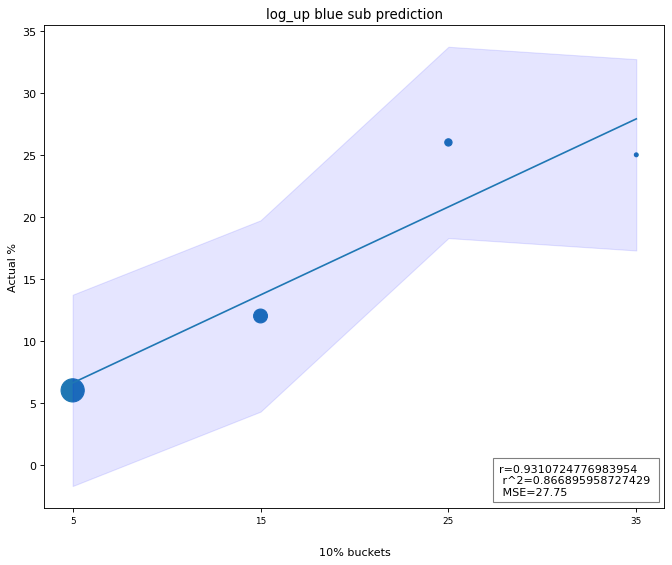

['rf_no']
rf_no
0% to 10%: 8% of 370 observations
10% to 20%: 9% of 280 observations
20% to 30%: 0% of 2 observations
30% to 40%: 0% of 0 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


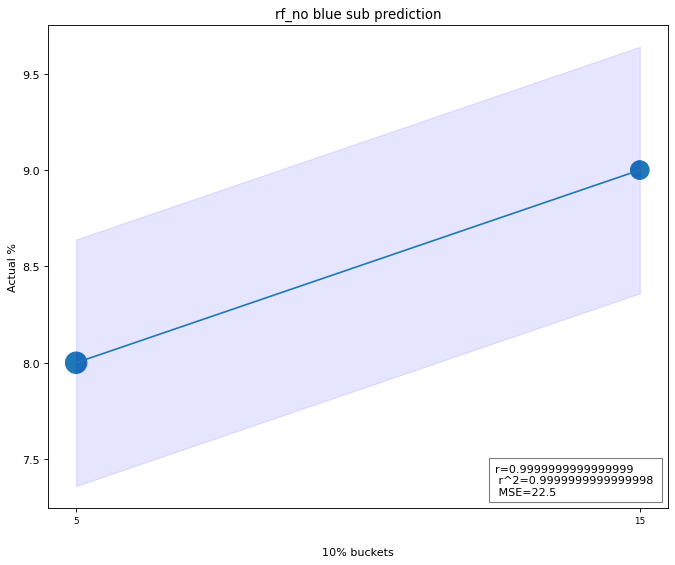

['rf_rand']
rf_rand
0% to 10%: 11% of 74 observations
10% to 20%: 7% of 486 observations
20% to 30%: 13% of 91 observations
30% to 40%: 0% of 1 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


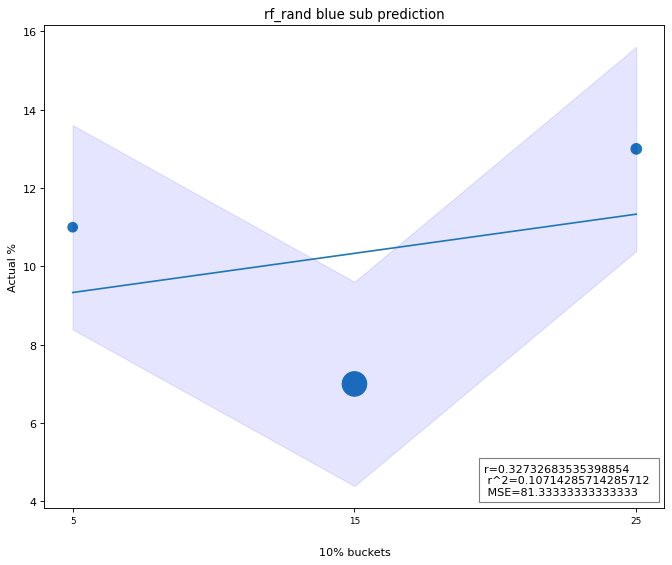

['rf_up']
rf_up
0% to 10%: 8% of 279 observations
10% to 20%: 9% of 360 observations
20% to 30%: 15% of 13 observations
30% to 40%: 0% of 0 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


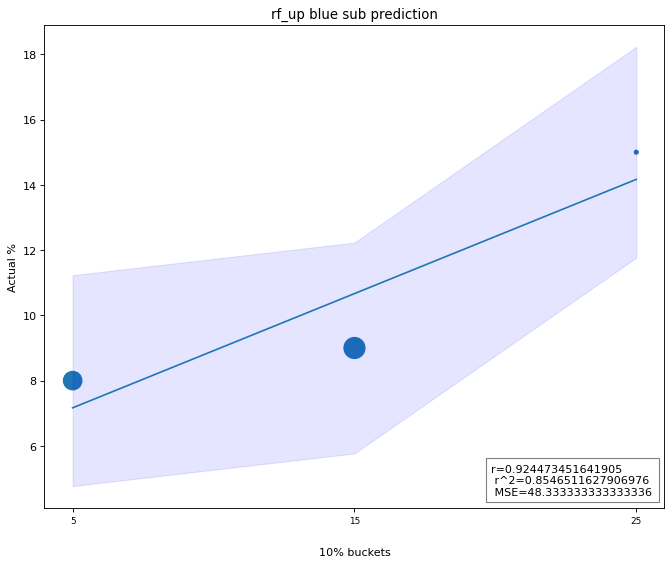

['mlp_no']
mlp_no
0% to 10%: 8% of 529 observations
10% to 20%: 11% of 80 observations
20% to 30%: 17% of 24 observations
30% to 40%: 22% of 9 observations
40% to 50%: 0% of 5 observations
50% to 60%: 33% of 3 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 2 observations
90% to 100%: 0% of 0 observations


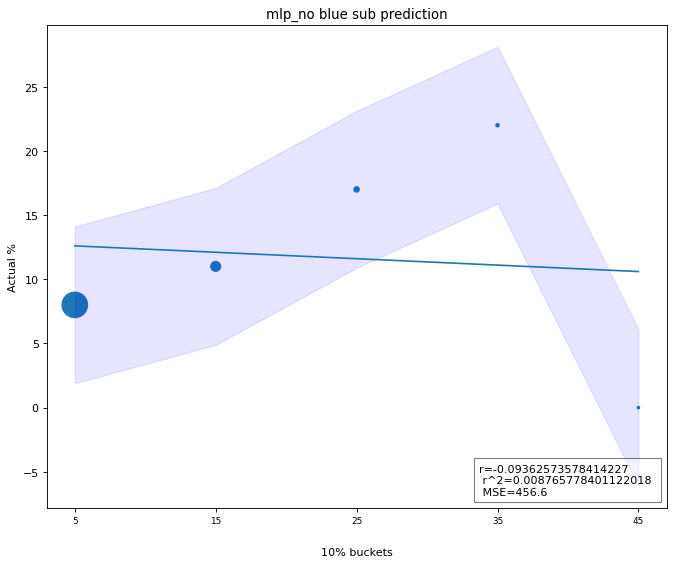

['mlp_rand']
mlp_rand
0% to 10%: 6% of 453 observations
10% to 20%: 12% of 97 observations
20% to 30%: 11% of 46 observations
30% to 40%: 21% of 19 observations
40% to 50%: 11% of 19 observations
50% to 60%: 25% of 8 observations
60% to 70%: 17% of 6 observations
70% to 80%: 50% of 2 observations
80% to 90%: 0% of 2 observations
90% to 100%: 0% of 0 observations


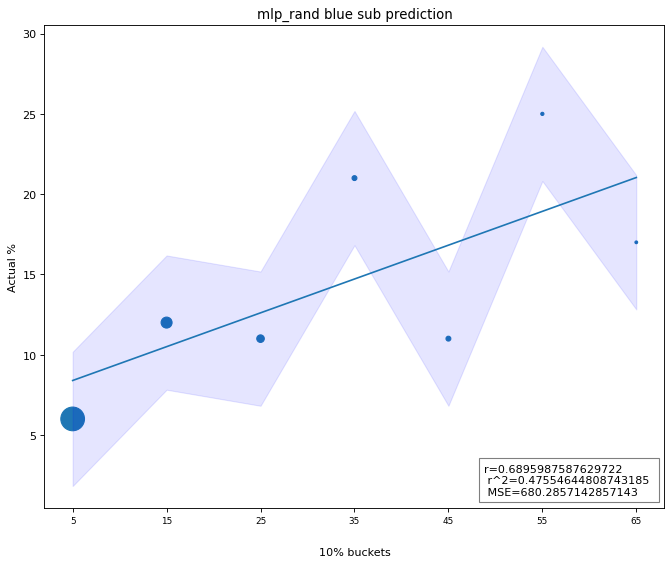

['mlp_up']
mlp_up
0% to 10%: 6% of 533 observations
10% to 20%: 18% of 55 observations
20% to 30%: 8% of 24 observations
30% to 40%: 21% of 14 observations
40% to 50%: 25% of 8 observations
50% to 60%: 25% of 4 observations
60% to 70%: 33% of 6 observations
70% to 80%: 0% of 3 observations
80% to 90%: 60% of 5 observations
90% to 100%: 0% of 0 observations


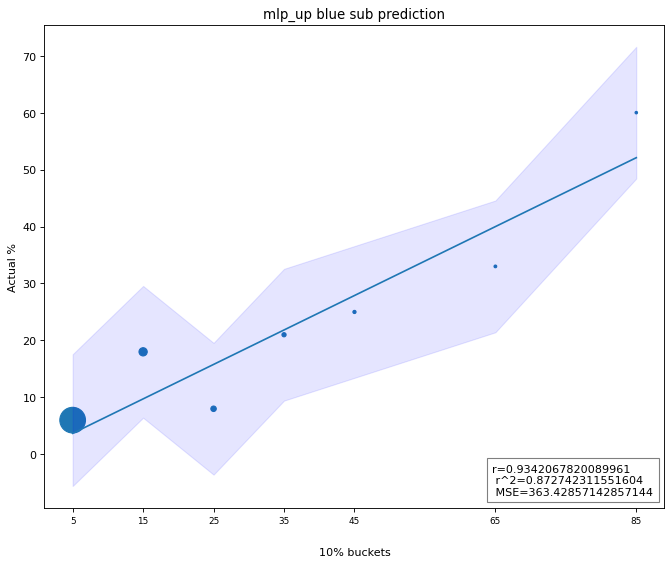

['nn_no']
nn_no
0% to 10%: 6% of 531 observations
10% to 20%: 18% of 98 observations
20% to 30%: 19% of 16 observations
30% to 40%: 50% of 6 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 1 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


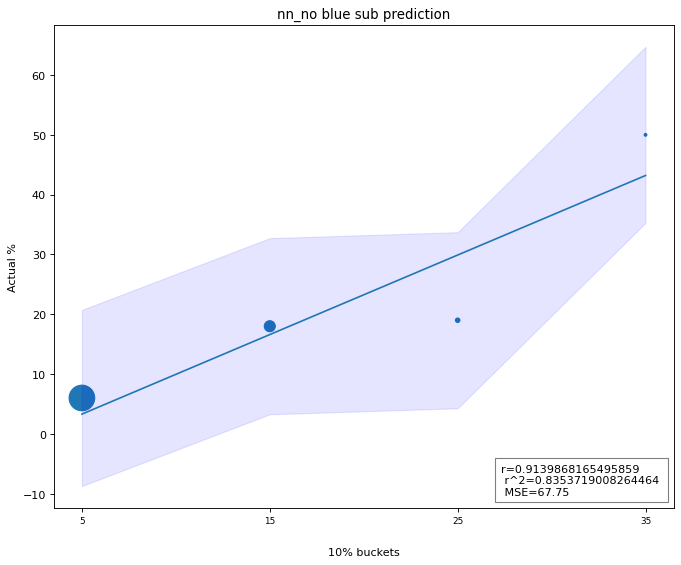

['nn_rand']
nn_rand
0% to 10%: 7% of 433 observations
10% to 20%: 9% of 147 observations
20% to 30%: 17% of 53 observations
30% to 40%: 23% of 13 observations
40% to 50%: 20% of 5 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 1 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


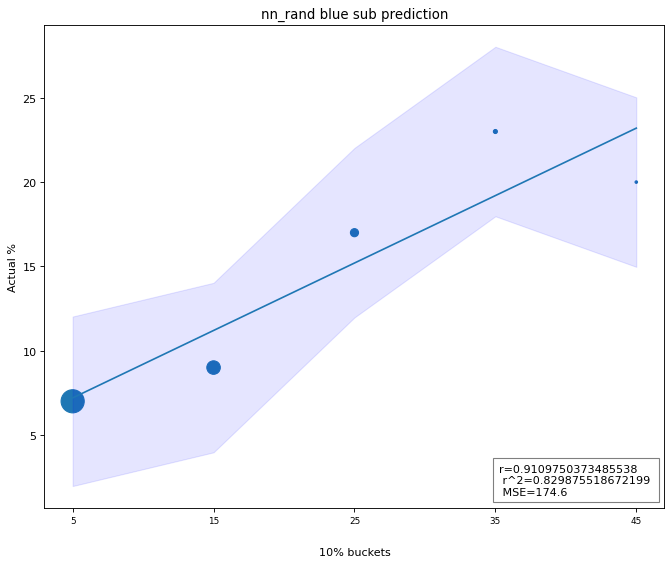

['nn_up']
nn_up
0% to 10%: 6% of 499 observations
10% to 20%: 16% of 74 observations
20% to 30%: 24% of 38 observations
30% to 40%: 11% of 19 observations
40% to 50%: 11% of 9 observations
50% to 60%: 12% of 8 observations
60% to 70%: 20% of 5 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


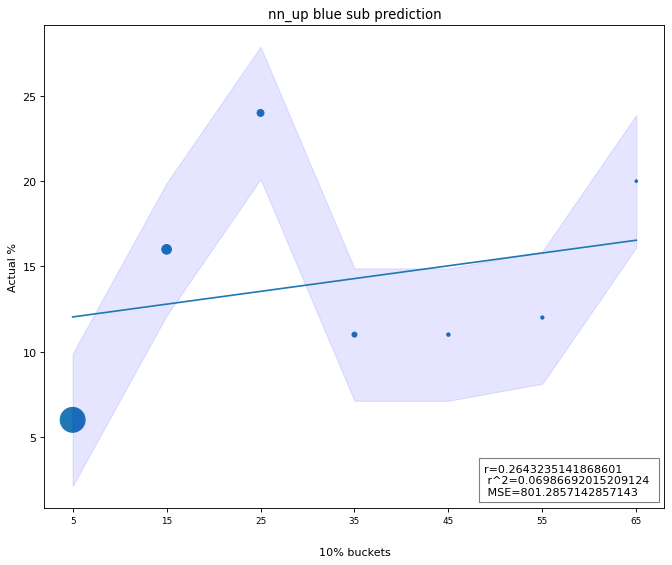

['mix_no']
mix_no
0% to 10%: 7% of 551 observations
10% to 20%: 22% of 87 observations
20% to 30%: 8% of 12 observations
30% to 40%: 0% of 0 observations
40% to 50%: 0% of 2 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


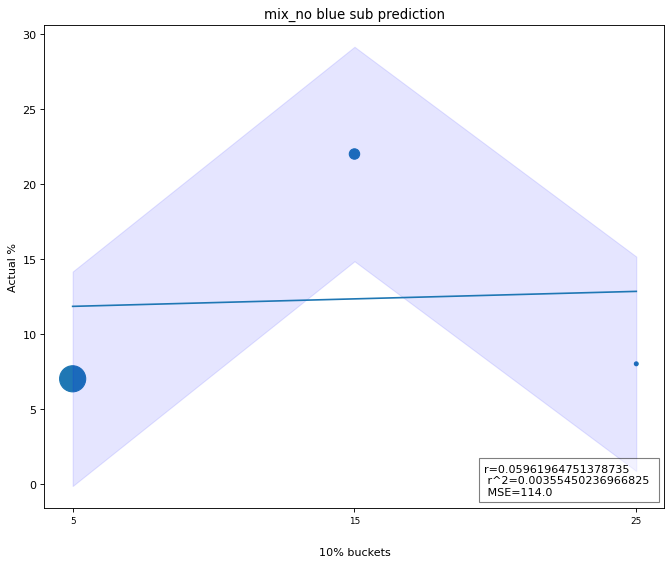

['mix_rand']
mix_rand
0% to 10%: 6% of 396 observations
10% to 20%: 12% of 199 observations
20% to 30%: 20% of 46 observations
30% to 40%: 20% of 10 observations
40% to 50%: 0% of 1 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


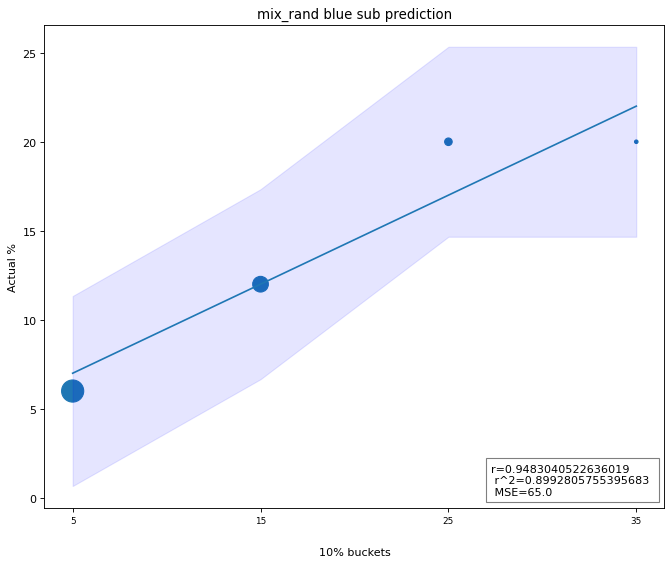

['mix_up']
mix_up
0% to 10%: 7% of 485 observations
10% to 20%: 13% of 151 observations
20% to 30%: 31% of 13 observations
30% to 40%: 0% of 3 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


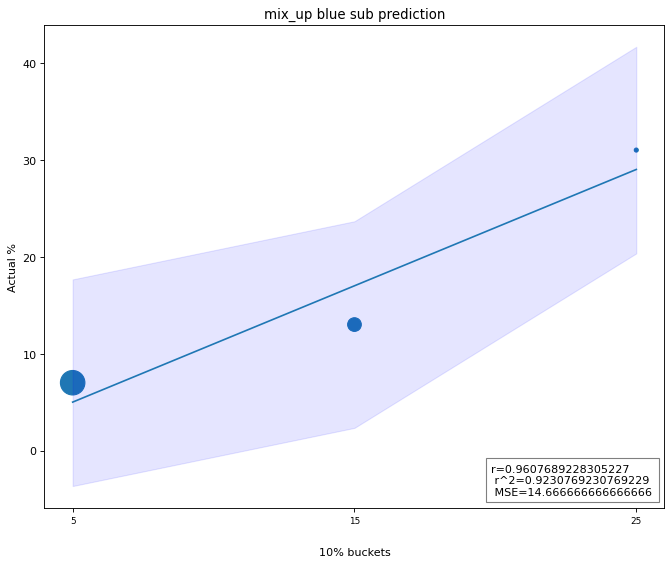

['combined']
combined
0% to 10%: 6% of 469 observations
10% to 20%: 13% of 156 observations
20% to 30%: 33% of 24 observations
30% to 40%: 0% of 3 observations
40% to 50%: 0% of 0 observations
50% to 60%: 0% of 0 observations
60% to 70%: 0% of 0 observations
70% to 80%: 0% of 0 observations
80% to 90%: 0% of 0 observations
90% to 100%: 0% of 0 observations


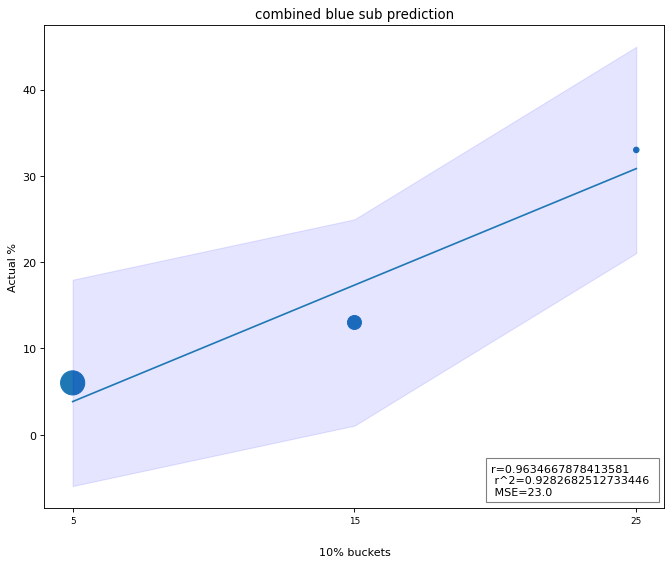

In [84]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["blue_sub_pct"] >= x]
        point_to_point = point_up[point_up["blue_sub_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Submission"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    
    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} blue sub prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [85]:
blue_sub_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_sub_df = pd.DataFrame(blue_sub_dict)
blue_sub_df

model_combo   r_score  r_squared  mean_squared
0       knn_no -0.628619   0.395161    215.000000
1     knn_rand  0.866025   0.750000     67.333333
2       knn_up  0.960988   0.923497    154.600000
3       log_no  0.999733   0.999467     15.333333
4     log_rand  0.993409   0.986861     71.500000
5       log_up  0.931072   0.866896     27.750000
6        rf_no  1.000000   1.000000     22.500000
7      rf_rand  0.327327   0.107143     81.333333
8        rf_up  0.924473   0.854651     48.333333
9       mlp_no -0.093626   0.008766    456.600000
10    mlp_rand  0.689599   0.475546    680.285714
11      mlp_up  0.934207   0.872742    363.428571
12       nn_no  0.913987   0.835372     67.750000
13     nn_rand  0.910975   0.829876    174.600000
14       nn_up  0.264324   0.069867    801.285714
15      mix_no  0.059620   0.003555    114.000000
16    mix_rand  0.948304   0.899281     65.000000
17      mix_up  0.960769   0.923077     14.666667
18    combined  0.963467   0.928268     23.000000

In [86]:
concat_frames = [red_win_df, blue_win_df, red_dec_df, red_ko_df, red_sub_df, blue_dec_df, blue_ko_df, blue_sub_df]
concat_df = pd.concat(concat_frames)
concat_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.856098   0.732904    202.750000
1     knn_rand  0.891585   0.794924    200.857143
2       knn_up  0.830836   0.690288    342.500000
3       log_no  0.894162   0.799526    139.125000
4     log_rand  0.960160   0.921907    127.750000
..         ...       ...        ...           ...
14       nn_up  0.264324   0.069867    801.285714
15      mix_no  0.059620   0.003555    114.000000
16    mix_rand  0.948304   0.899281     65.000000
17      mix_up  0.960769   0.923077     14.666667
18    combined  0.963467   0.928268     23.000000

[152 rows x 4 columns]

In [87]:
concat_mean = concat_df.groupby(["model_combo"]).mean().sort_values(by="mean_squared")
concat_mean

r_score  r_squared  mean_squared
model_combo                                   
mix_rand     0.909084   0.840587     61.510714
combined     0.860552   0.790648     64.563393
mix_up       0.860072   0.767055     68.814583
mix_no       0.812385   0.744408     77.356250
log_rand     0.847539   0.750813    121.838542
rf_no        0.326232   0.585872    122.552083
log_no       0.867232   0.756057    129.269196
nn_rand      0.862572   0.752813    129.515724
knn_rand     0.731238   0.628060    154.060714
rf_rand      0.359770   0.411723    177.489583
knn_no       0.528021   0.511835    209.471131
rf_up        0.102994   0.669822    222.656250
log_up       0.678226   0.635320    255.948710
nn_no        0.607113   0.505683    322.900050
knn_up       0.671699   0.535242    329.312054
mlp_no       0.536967   0.434882    526.516468
mlp_rand     0.764476   0.603323    541.558631
nn_up        0.558701   0.513203    554.293502
mlp_up       0.575100   0.441310    911.375794